# Introduction

Ce travail, documenté dans ce notebook Python, s'inscrit dans le contexte de l'analyse de données relatives aux membres d'une salle de sport. L'objectif principal est d'exploiter les informations contenues dans le jeu de données `gym_members_exercise_tracking.csv` pour développer et évaluer des modèles d'apprentissage automatique capables de prédire des caractéristiques clés des adhérents.

Au fil de ce notebook, nous détaillerons l'ensemble du processus méthodologique, en commençant par le chargement et le prétraitement des données, incluant le nettoyage, la transformation de variables et la gestion des différents types de données. Une phase d'analyse exploratoire sera ensuite menée pour visualiser les données, identifier des tendances, des corrélations et mieux comprendre la structure sous-jacente du jeu de données.

Suite à cette exploration, nous aborderons la construction de plusieurs modèles prédictifs. Différents algorithmes d'apprentissage supervisé, adaptés à la nature de la variable cible (qu'il s'agisse d'une tâche de classification, comme la prédiction du niveau d'expérience, ou de régression pour la prédiction du nombre de calories brulées lors d'une séance), seront entraînés et rigoureusement évalués. Les performances de ces modèles seront comparées sur la base de métriques pertinentes afin d'identifier les approches les plus efficaces et robustes pour notre problématique. L'ambition est non seulement de parvenir à des prédictions précises mais aussi, dans la mesure du possible, d'extraire des informations interprétables sur les facteurs influençant les résultats.

> Remarque : Il serait préférable de consulter le notebook en R dans un premier temps car les comparaisons entre les deux langages sont faites dans ce notebook Python.

In [2]:
## LIBRARIES
import pandas as pd
import numpy as np

import copy
import random
import itertools
%matplotlib inline
import time
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split


randomseed = 1234

## DATA LOADING AND PREPROCESSING
# Load the data
gym = pd.read_csv('gym_members_exercise_tracking.csv')

# set 'Gender', 'Workout_Type', 'Workout_Frequency (days/week)' and 'Experience_Level' as categorical
for col in ['Gender', 'Workout_Type', 'Workout_Frequency (days/week)', 'Experience_Level']:
    gym[col] = gym[col].astype('category')

# log transform Weight and BMI
gym['Weight (kg)'] = np.log1p(gym['Weight (kg)'])

# transform 'Fat_Percentage'
max_fat = gym['Fat_Percentage'].max()
gym['Fat_Percentage'] = gym['Fat_Percentage'].apply(lambda x: np.sqrt(max_fat+1)-x)

# rename transformed columns
gym.rename(columns={'Weight (kg)': 'LWeight', 'Fat_Percentage': 'SFat_Percentage'}, inplace=True)

gym.drop(columns=['BMI'], inplace=True)

# divide into train and test set
gym_train, gym_test = train_test_split(gym, test_size=0.2, random_state=randomseed)

# Create gym_train_scale, gym_test_scale
gym_train_scale = gym_train.copy()
gym_test_scale = gym_test.copy()

# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
gym_train_scale[['LWeight', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)',
                             'Water_Intake (liters)', 'SFat_Percentage', 'Workout_Frequency (days/week)', 'Calories_Burned']] = scaler.fit_transform(gym_train_scale[['LWeight', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)',
                             'Water_Intake (liters)', 'SFat_Percentage', 'Workout_Frequency (days/week)', 'Calories_Burned']])

gym_test_scale[['LWeight', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)',
                             'Water_Intake (liters)', 'SFat_Percentage', 'Workout_Frequency (days/week)', 'Calories_Burned']] = scaler.transform(gym_test_scale[['LWeight', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)',
                             'Water_Intake (liters)', 'SFat_Percentage', 'Workout_Frequency (days/week)', 'Calories_Burned']])


# Create X_train_exp_level, X_test_exp_level, y_train_exp_level, y_test_exp_level
X_train_exp_level = gym_train.drop(columns=['Experience_Level'])
X_train_exp_level_scale = gym_train_scale.drop(columns=['Experience_Level'])
y_train_exp_level = gym_train['Experience_Level']
X_test_exp_level = gym_test.drop(columns=['Experience_Level'])
X_test_exp_level_scale = gym_test_scale.drop(columns=['Experience_Level'])
y_test_exp_level = gym_test['Experience_Level']

# Create X_train_calories, X_test_calories, y_train_calories, y_test_calories
X_train_calories = gym_train.drop(columns=['Calories_Burned'])
X_train_calories_scale = gym_train_scale.drop(columns=['Calories_Burned'])
y_train_calories = gym_train['Calories_Burned']
X_test_calories = gym_test.drop(columns=['Calories_Burned'])
X_test_calories_scale = gym_test_scale.drop(columns=['Calories_Burned'])
y_test_calories = gym_test['Calories_Burned']

print("Data loaded and preprocessed")

Data loaded and preprocessed


# Prédiction de Calories Burned

In [3]:
X_train_calories_dummy = pd.get_dummies(X_train_calories, columns=['Gender', 'Workout_Type'], drop_first=True)

X_test_calories_dummy = pd.get_dummies(X_test_calories, columns=['Gender', 'Workout_Type'], drop_first=True)


X_train_calories_dummy1 = pd.get_dummies(X_train_calories, drop_first=True)
X_test_calories_dummy1 = pd.get_dummies(X_test_calories, drop_first=True)
# Normalisation des données - scaled = Scale + Dummies alors que scale = just scale
X_train_calories_scaled = scaler.fit_transform(X_train_calories_dummy1)
X_test_calories_scaled = scaler.transform(X_test_calories_dummy1)

In [4]:
display(gym_train.head().style.background_gradient(cmap='YlGnBu', low=0, high=0, axis=0))
# display unique values of categorical columns
display(gym_train.info())
for col in gym_train.select_dtypes(include='category').columns:
    print(col, gym_train[col].unique())

<class 'pandas.core.frame.DataFrame'>
Index: 778 entries, 718 to 815
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Age                            778 non-null    int64   
 1   Gender                         778 non-null    category
 2   LWeight                        778 non-null    float64 
 3   Height (m)                     778 non-null    float64 
 4   Max_BPM                        778 non-null    int64   
 5   Avg_BPM                        778 non-null    int64   
 6   Resting_BPM                    778 non-null    int64   
 7   Session_Duration (hours)       778 non-null    float64 
 8   Calories_Burned                778 non-null    float64 
 9   Workout_Type                   778 non-null    category
 10  SFat_Percentage                778 non-null    float64 
 11  Water_Intake (liters)          778 non-null    float64 
 12  Workout_Frequency (days/week)  778 non-

None

Gender ['Male', 'Female']
Categories (2, object): ['Female', 'Male']
Workout_Type ['Yoga', 'Strength', 'HIIT', 'Cardio']
Categories (4, object): ['Cardio', 'HIIT', 'Strength', 'Yoga']
Workout_Frequency (days/week) [3, 5, 2, 4]
Categories (4, int64): [2, 3, 4, 5]
Experience_Level [2, 3, 1]
Categories (3, int64): [1, 2, 3]


In [5]:
display(gym_train.head().style.background_gradient(cmap='YlGnBu', low=0, high=0, axis=0))
# display unique values of categorical columns
display(gym_train.info())
for col in gym_train.select_dtypes(include='category').columns:
    print(col, gym_train[col].unique())

<class 'pandas.core.frame.DataFrame'>
Index: 778 entries, 718 to 815
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Age                            778 non-null    int64   
 1   Gender                         778 non-null    category
 2   LWeight                        778 non-null    float64 
 3   Height (m)                     778 non-null    float64 
 4   Max_BPM                        778 non-null    int64   
 5   Avg_BPM                        778 non-null    int64   
 6   Resting_BPM                    778 non-null    int64   
 7   Session_Duration (hours)       778 non-null    float64 
 8   Calories_Burned                778 non-null    float64 
 9   Workout_Type                   778 non-null    category
 10  SFat_Percentage                778 non-null    float64 
 11  Water_Intake (liters)          778 non-null    float64 
 12  Workout_Frequency (days/week)  778 non-

None

Gender ['Male', 'Female']
Categories (2, object): ['Female', 'Male']
Workout_Type ['Yoga', 'Strength', 'HIIT', 'Cardio']
Categories (4, object): ['Cardio', 'HIIT', 'Strength', 'Yoga']
Workout_Frequency (days/week) [3, 5, 2, 4]
Categories (4, int64): [2, 3, 4, 5]
Experience_Level [2, 3, 1]
Categories (3, int64): [1, 2, 3]


## Modèle Linéaire : 

Temps d'entraînement : 0.028687238693237305 secondes
R² test: 0.9784825037136762
R² train: 0.9790674887854082
MSE: 1679.5412626974553
Coefficients du modèle :  [-4.19977341e+01  2.29759699e+00  2.03255278e+00 -1.06264166e+00
  9.03212133e+01  2.55059915e+00  2.44242855e+02  2.03381013e+00
 -7.57451047e-01  4.12188909e+01 -7.54953418e-01 -4.76075478e-01
 -3.44856168e+00 -9.28352252e-01  9.97555344e-01  2.58109228e+00
 -1.07904607e-02 -2.86359397e+00]
Intercept du modèle :  913.284061696658


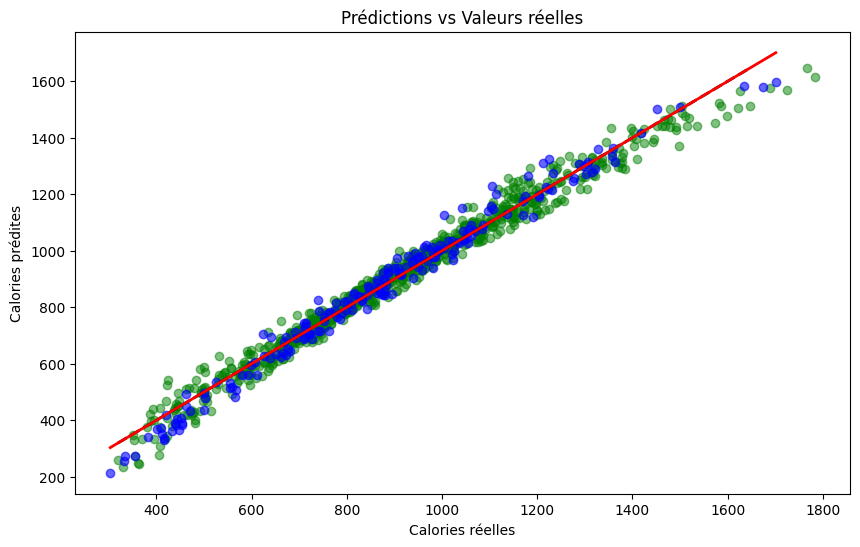

In [6]:
# 1. Importer les bibliothèques nécessaires
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 2. Créer un modèle de régression linéaire
linear_model = LinearRegression()


#calcul du temps d'entraînement
import time
start_time = time.time()
# Entraînement du modèle
# 3. Entraîner le modèle sur les données d'entraînement
linear_model.fit(X_train_calories_scaled, y_train_calories)
end_time = time.time()
print(f"Temps d'entraînement : {end_time - start_time} secondes")
# 4. Faire des prédictions sur l'échantillon de test (X_test_scaled)
#y_pred_calories = linear_model.predict(X_test_calories_scaled)
y_pred_train_calories = linear_model.predict(X_train_calories_scaled)
y_pred_test_calories = linear_model.predict(X_test_calories_scaled)
# 5. Évaluer la performance du modèle
# Coefficient de détermination R²
r2_test = r2_score(y_test_calories, y_pred_test_calories)
r2_train = r2_score(y_train_calories, y_pred_train_calories)
print(f"R² test: {r2_test}")
print(f"R² train: {r2_train}")

# Erreur quadratique moyenne (MSE)
mse = mean_squared_error(y_test_calories, y_pred_test_calories)
print(f"MSE: {mse}")

# 6. Afficher les coefficients du modèle
print("Coefficients du modèle : ", linear_model.coef_)
print("Intercept du modèle : ", linear_model.intercept_)

plt.figure(figsize=(10, 6))
plt.scatter(y_train_calories, y_pred_train_calories, color='green', alpha=0.5, label='scikit-learn Regression Predictions')
plt.plot([y_train_calories.min(), y_pred_train_calories.max()], [y_train_calories.min(), y_pred_train_calories.max()], 'k--', lw=2)
plt.scatter(y_test_calories, y_pred_test_calories, color='blue', alpha=0.6)
plt.plot([y_test_calories.min(), y_test_calories.max()], [y_test_calories.min(), y_test_calories.max()], color='red', lw=2)  # Ligne idéale
plt.xlabel("Calories réelles")
plt.ylabel("Calories prédites")
plt.title("Prédictions vs Valeurs réelles")
plt.show()




### Performances du modèle

R² = 0.978 :
Le modèle explique 97.8% de la variance des calories brûlées. Cette valeur exceptionnellement élevée pourrait indiquer un surapprentissage (overfitting), surtout si le modèle a beaucoup de variables (18 coefficients ici).
On remarque également que les points verts (entraînement) et bleus (test) semblent bien alignés, ce qui suggère une bonne performance globale du modèle. Toutefois, pour obtenir une analyse complète, il faudrait tracer résidus vs prédictions pour vérifier la répartition uniforme des résidus.

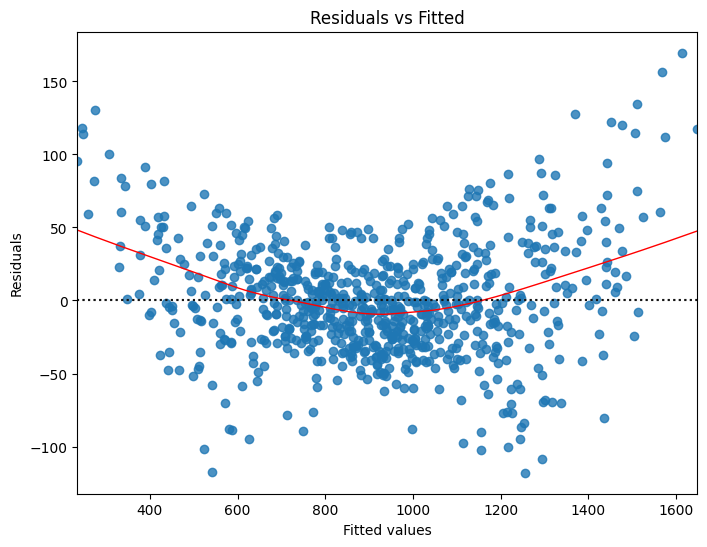

In [7]:


import matplotlib.pyplot as plt
import seaborn as sns

# Calcul des résidus
residuals_train = y_train_calories - y_pred_train_calories
residuals_test = y_test_calories - y_pred_test_calories

# Création d'une seule figure
plt.figure(figsize=(8, 6))  # Ajuste la taille selon tes besoins

# 1. Résidus vs Valeurs ajustées
sns.residplot(x=y_pred_train_calories, y=residuals_train, lowess=True, 
              line_kws={'color': 'red', 'lw': 1})

# Ajout de la ligne horizontale à zéro
plt.axhline(0, color='black', linestyle='dotted', alpha=0.6)

# Ajout des labels et du titre
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")

# Affichage de la figure
plt.show()



La forme en banane dans le graphique des résidus (Residuals vs Fitted) révèle une non-linéarité non capturée par le modèle.Ce qui nous indique que la valeur du score R² est trompeuse. En effet, le R² mesure la variance expliquée, pas la justesse des prédictions. Un modèle peut, donc, avoir un R² élevé tout en ayant des erreurs systématiques. Le modèle linéaire est inadéquat pour capturer la vraie relation dans les données, malgré un R² élevé. Ainsi, pour améliorer la généralisation du modèle et identifier les variables réellement influentes, une approche de régularisation s’impose. C’est ici que la régression Lasso (Least Absolute Shrinkage and Selection Operator) entre en jeu. 

Donc, maintenant, nous allons passer à l’implémentation de Lasso pour voir comment il améliore (ou non) la robustesse du modèle, malgré les limites structurelles de la linéarité.

## LASSO : 

D'abord avec un lambda quelconque puis avec un lambda choisi par validation croisée

Temps d'entraînement : 0.022274255752563477 secondes
The train score for ls model is 0.9729522713522744
The test score for ls model is 0.9773697138274883


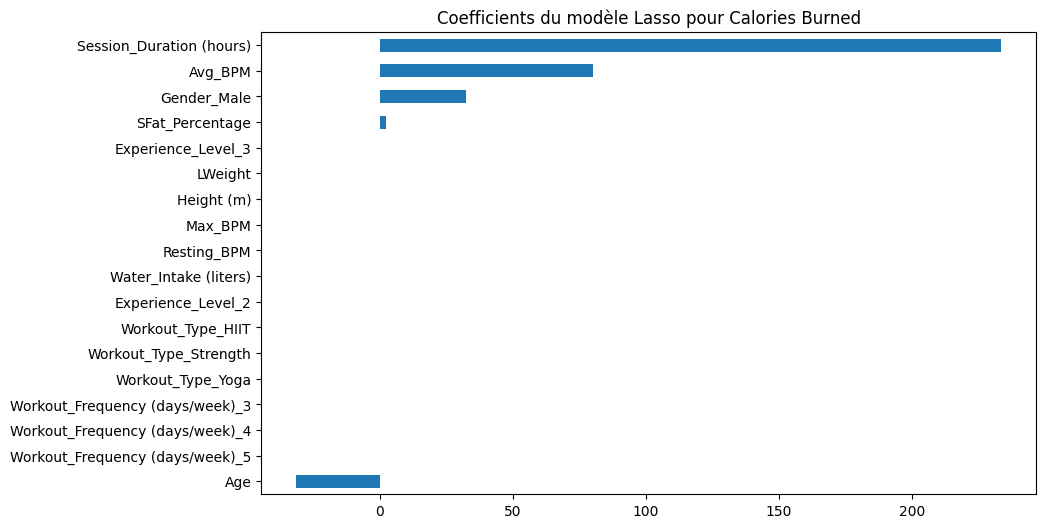

Lasso conserve 5 variables et en supprime 13


In [8]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso
lasso1= Lasso(alpha=10)
# calcul du temps d'entraînement

start_time = time.time()
# Entraînement du modèle
lasso1.fit(X_train_calories_scaled, y_train_calories)
train_score_lasso1=lasso1.score(X_train_calories_scaled, y_train_calories)
end_time = time.time()
print(f"Temps d'entraînement : {end_time - start_time} secondes")
test_score_lasso1=lasso1.score(X_test_calories_scaled, y_test_calories)

print("The train score for ls model is {}".format(train_score_lasso1))
print("The test score for ls model is {}".format(test_score_lasso1))
# print the lasso coefficient with the name of the variable next to it


coef_calories_lasso1 = pd.Series(lasso1.coef_, index=X_train_calories_dummy1.columns)
coef_calories_lasso1.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title('Coefficients du modèle Lasso pour Calories Burned')
plt.show()
# Afficher le nombre de variables conservées et éliminées
print(f"Lasso conserve {sum(coef_calories_lasso1 != 0)} variables et en supprime {sum(coef_calories_lasso1 == 0)}")
# print the coefficients of lasso1
#print("Coefficients du modèle Lasso : ", coef_calories_lasso1)


Temps d'entraînement : 0.5718858242034912 secondes
Optimal alpha: 0.8
Coefficients du modèle Lasso pour Calories Burned:
Age                                -41.155584
LWeight                              1.782447
Height (m)                           1.518002
Max_BPM                             -0.233361
Avg_BPM                             89.501680
Resting_BPM                          1.668190
Session_Duration (hours)           243.133973
SFat_Percentage                      0.811042
Water_Intake (liters)                0.000000
Gender_Male                         40.891185
Workout_Type_HIIT                   -0.000000
Workout_Type_Strength                0.000000
Workout_Type_Yoga                   -2.260688
Workout_Frequency (days/week)_3     -0.630447
Workout_Frequency (days/week)_4      0.000000
Workout_Frequency (days/week)_5      0.618403
Experience_Level_2                   0.000000
Experience_Level_3                   0.000000
dtype: float64
Lasso conserve 12 variables et en su

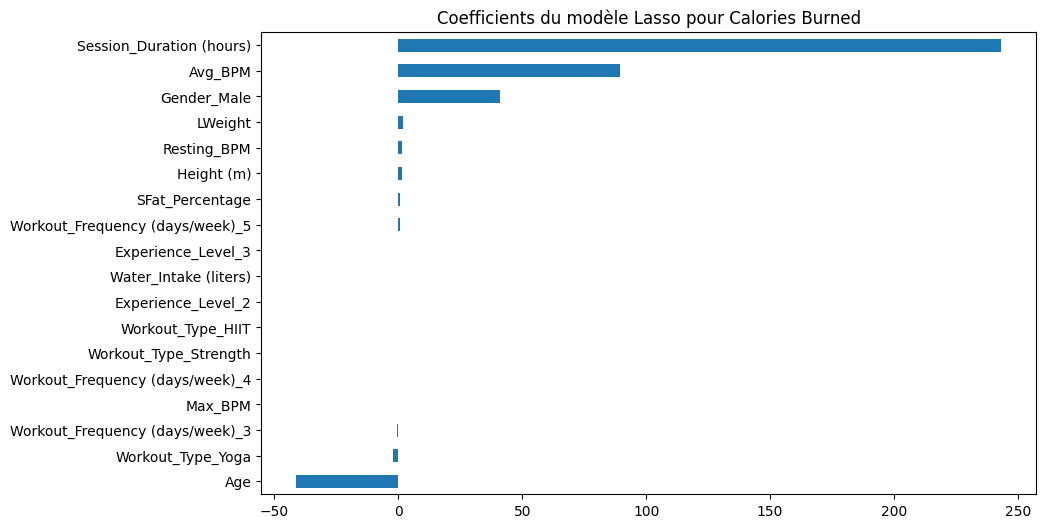

Test Mean Squared Error (MSE) pour Lasso pour l'échantillon de test: 1638.1391021806983
The train score for ls model is 0.9789563801847917
The test score for ls model is 0.9790129288094754


In [9]:
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
import numpy as np

# Appliquer Lasso avec validation croisée pour trouver le meilleur alpha
#lasso = LassoCV(cv=5, random_state=1234, max_iter=10000)  # 5-fold cross-validation
start_time = time.time()
lasso = LassoCV(cv=5, alphas=np.array(range(1, 50, 1)) / 20., n_jobs=-1, random_state=13).fit(X_train_calories_scaled, y_train_calories)
lasso.fit(X_train_calories_scaled, y_train_calories)
end_time = time.time()
print(f"Temps d'entraînement : {end_time - start_time} secondes")

# Coefficient optimal alpha sélectionné par LassoCV
optimal_alpha = lasso.alpha_
print(f"Optimal alpha: {optimal_alpha}")

# Coefficients du modèle Lasso
coef_calories_lasso = pd.Series(lasso.coef_, index=X_train_calories_dummy1.columns)

# Afficher les coefficients du modèle Lasso
print("Coefficients du modèle Lasso pour Calories Burned:")
print(coef_calories_lasso)

# Afficher le nombre de variables conservées et éliminées
print(f"Lasso conserve {sum(coef_calories_lasso != 0)} variables et en supprime {sum(coef_calories_lasso == 0)}")

# Tracer les coefficients
coef_calories_lasso.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title('Coefficients du modèle Lasso pour Calories Burned')
plt.show()

# Prédictions avec le modèle Lasso
y_pred_lasso = lasso.predict(X_test_calories_scaled)

# Calcul de l'erreur quadratique moyenne pour évaluer les performances du modèle
from sklearn.metrics import mean_squared_error
mse_lasso_test = mean_squared_error(y_test_calories, y_pred_lasso)

print(f"Test Mean Squared Error (MSE) pour Lasso pour l'échantillon de test: {mse_lasso_test}")

train_score_lasso= lasso.score(X_train_calories_scaled, y_train_calories)
test_score_lasso= lasso.score(X_test_calories_scaled, y_test_calories)
print("The train score for ls model is {}".format(train_score_lasso))
print("The test score for ls model is {}".format(test_score_lasso))




### Performances du modèle

- On obtient un MSE = 1638.14. On a donc une légère amélioration par rapport au modèle linéaire non régularisé (MSE=1679.54). Cependant, cette différence minime suggère que la régularisation Lasso réduit légèrement le surapprentissage.Toutefois, Le problème fondamental de non-linéarité (forme en banane des résidus) persiste, limitant les gains de performance. Ceci est visible dans le graphe des résidus ci-dessous, où l'on observe un profil en banane.


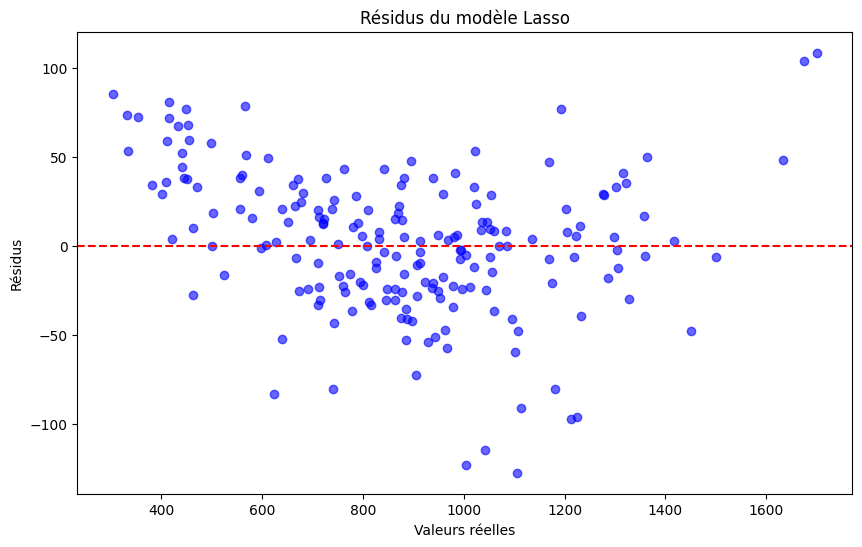

In [10]:
# tracé des résidus
residuals_lasso = y_test_calories - y_pred_lasso
plt.figure(figsize=(10, 6))
plt.scatter(y_test_calories, residuals_lasso, color='blue', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valeurs réelles")
plt.ylabel("Résidus")
plt.title("Résidus du modèle Lasso")
plt.show()


- On a un alpha optimal = 0.8 :Une pénalité L1 relativement forte, ce qui explique pourquoi 11 variables sur 18 ont été éliminées (coefficients à zéro).

### Interpretation des résultats: 

#### Relation Session_Duration - Calories Burned
- On remarque, d'après le graphe, que la variable Session_Duration domine clairement, c'est à dire qu'une augmentation d’1 heure de la durée de la séance entraîne une augmentation prédite de 243 calories brûlée. Donc, plus la séance est longue, plus le corps puise dans ses réserves énergétiques (glycogène et lipides).

Les activités prolongées (ex : cardio, endurance) sollicitent le métabolisme aérobie, favorisant une dépense calorique cumulative.

- Remarque: Ce coefficient élevé pourrait aussi refléter une corrélation indirecte (ex : les séances longues incluent souvent des exercices intenses).

#### Différence homme femme 
-  Les hommes brûlent 40.9 calories de plus que les femmes à caractéristiques égales.
    Ceci pourrait être dû au fait que les hommes ont généralement une masse musculaire plus élevée, qui consomme plus de calories au repos et à l’effort.Les différences hormonales (testostérone) favorisent un métabolisme énergétique plus actif.

- Remarque: Ce coefficient pourrait aussi refléter des biais comportementaux (ex : les hommes choisissent des entraînements plus intenses non mesurés dans les données).

### Evolution du MSE en fonction de lambda

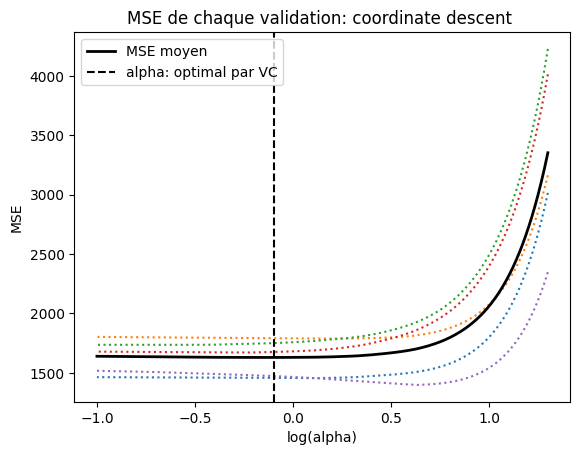

In [11]:
from sklearn.linear_model import LassoCV, LassoLarsCV
model = LassoCV(cv=5, alphas=np.array(range(1,200,1))/10.,n_jobs=-1,random_state=13).fit(X_train_calories_scaled, y_train_calories)
m_log_alphas = np.log10(model.alphas_)

plt.figure()
# ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='MSE moyen', linewidth=2)
plt.axvline(np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: optimal par VC')

plt.legend()

plt.xlabel('log(alpha)')
plt.ylabel('MSE')
plt.title('MSE de chaque validation: coordinate descent ')
plt.show()
#le courbe noire correspond à la moyennes des 5 autres
# on decoupe en 5 échantillons d'apprentissage d'ou les 5 courbes 
# Plot the coefficients as a function of -log(alpha)


On remarque une zone où la MSE est relativement basse et stable autour d’un certain intervalle de alpha. Puis, quand alpha devient trop grand (régularisation trop forte), la MSE monte en flèche (le modèle est trop contraint, sous-apprentissage).

À l’opposé, quand alpha est trop petit, la régularisation est quasi nulle : on risque un sur-apprentissage (même si, parfois, la MSE peut rester relativement stable dans cette zone si le dataset n’est pas trop bruyant).

Le point choisi par la validation croisée est un compromis : il vise à réduire le nombre de coefficients non nuls (pour la parcimonie) tout en conservant une bonne performance (basse MSE).

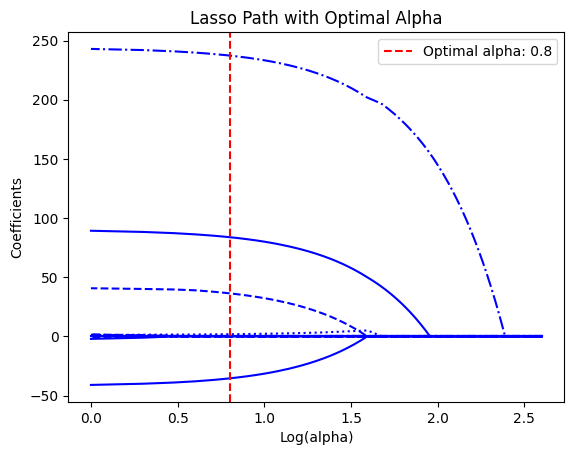

In [12]:
from itertools import cycle
from sklearn.linear_model import lasso_path

# Calculer le chemin du Lasso
alphas_lasso, coefs_lasso, _ = lasso_path(X_train_calories_scaled, y_train_calories, alphas=np.array(range(1, 400, 1)))

plt.figure()
ax = plt.gca()

# Styles pour les lignes
styles = cycle(['-', '--', '-.', ':'])

# Log des alphas
log_alphas_lasso = np.log10(alphas_lasso)

# Tracer les coefficients
for coef_l, s in zip(coefs_lasso, styles):
    plt.plot(log_alphas_lasso, coef_l, linestyle=s, c='b')

# Ajouter une ligne verticale pour l'alpha optimal
plt.axvline(optimal_alpha, color='red', linestyle='--', label=f'Optimal alpha: {optimal_alpha}')

# Ajouter des labels et une légende
plt.xlabel('Log(alpha)')
plt.ylabel('Coefficients')
plt.legend()
plt.title('Lasso Path with Optimal Alpha')
plt.show()

Le graphique illustre le mécanisme de régularisation L1 propre à la régression Lasso : lorsque le paramètre de régularisation *alpha* augmente, la contrainte de parcimonie s'intensifie, conduisant progressivement les coefficients les moins informatifs vers zéro. Ce comportement est intrinsèque à l'algorithme, qui privilégie un **modèle simplifié** (moins de variables) au détriment d'une légère dégradation de la précision. En d'autres termes, un *alpha* élevé renforce la pénalisation des coefficients, favorisant ainsi un **équilibre optimal entre simplicité interprétative et généralisation**, au prix d'un biais accru. Cela traduit directement le compromis biais-variance au cœur de l'optimisation du modèle.

In [13]:
# Moyennes et std des scores pour chaque alpha
mse_path = model.mse_path_.mean(axis=1)
stds = model.mse_path_.std(axis=1)
alphas = model.alphas_

# Index de l'erreur minimale
min_idx = np.argmin(mse_path)

# lambda_min
alpha_min = alphas[min_idx]

# lambda_1se = plus grand alpha avec erreur ≤ (erreur min + 1 std)
threshold = mse_path[min_idx] + stds[min_idx]
alpha_1se = max(alphas[mse_path <= threshold])

# Refit pour alpha_min
lasso_min = Lasso(alpha=alpha_min, max_iter=10000)
start_time = time.time()
lasso_min.fit(X_train_calories_scaled, y_train_calories)
end_time = time.time()
print(f"Temps d'entraînement pour alpha_min : {end_time - start_time} secondes")

non_zero_min = (lasso_min.coef_ != 0).sum()
r2_min = lasso_min.score(X_test_calories_scaled, y_test_calories)
# Refit pour alpha_1se
lasso_1se = Lasso(alpha=alpha_1se, max_iter=10000)
start_time = time.time()
lasso_1se.fit(X_train_calories_scaled, y_train_calories)
end_time = time.time()
print(f"Temps d'entraînement pour alpha_1se : {end_time - start_time} secondes")
non_zero_1se = (lasso_1se.coef_ != 0).sum()
r2_1se = lasso_1se.score(X_test_calories_scaled, y_test_calories)
# Affichage des résultats
print(f"alpha_min (λ_min) = {alpha_min:.6f}")
print(f"  -> MSE moyen : {mse_path[min_idx]:.6f}")
print(f"  -> Écart-type : {stds[min_idx]:.6f}")
print(f"  -> Nb variables non nulles : {non_zero_min}")
print(f"  -> R² : {r2_min:.6f}")
# Trouver l'indice correspondant à alpha_1se
idx_1se = list(alphas).index(alpha_1se)

print(f"\nalpha_1se (λ_1se) = {alpha_1se:.6f}")
print(f"  -> MSE moyen : {mse_path[idx_1se]:.6f}")
print(f"  -> Écart-type : {stds[idx_1se]:.6f}")
print(f"  -> Nb variables non nulles : {non_zero_1se}")
print(f"  -> R² : {r2_1se:.6f}")

Temps d'entraînement pour alpha_min : 0.005808353424072266 secondes
Temps d'entraînement pour alpha_1se : 0.006059885025024414 secondes
alpha_min (λ_min) = 0.800000
  -> MSE moyen : 1629.174636
  -> Écart-type : 139.258792
  -> Nb variables non nulles : 12
  -> R² : 0.979013

alpha_1se (λ_1se) = 5.700000
  -> MSE moyen : 1764.871425
  -> Écart-type : 241.987933
  -> Nb variables non nulles : 5
  -> R² : 0.979458


Nous obtenons 

a. Alpha_min (λ_min = 0.8)
- Pour λ_min = 0.8 et MSE moyen = 1629.17 :
C'est l'erreur minimale moyenne obtenue par validation croisée.
C'est la valeur de  λ qui donne les meilleures performances prédictives (modèle le plus précis).

- Écart-type = 139.26 :
Indique la variabilité des erreurs entre les folds de validation croisée.
Une valeur élevée suggère que le modèle est instable (sensible aux variations des données d'entraînement).

- 12 variables non nulles :
Le modèle garde 12 coefficients non nuls → modèle complexe mais précis.

b. Alpha_1se (λ_1se = 5.7)
- λ_1se = 5.7 et MSE moyen = 1764.87 (+8.3% vs λ_min) :
L'erreur est dans l'intervalle [λ_min - 1SE, λ_min + 1SE] → considérée comme statistiquement équivalente à l'erreur minimale.

- Écart-type = 241.99 :
Variabilité accrue → le modèle simplifié est plus sensible aux fluctuations des données.

- 5 variables non nulles :
Le modèle élimine 7 variables → modèle interprétable mais potentiellement moins précis.

Ces valeurs sont logiques vu que Alpha_1se represente la plus grande valeur de lambda dont l’erreur est à moins d’un écart-type de l’erreur minimale(favorise un modèle plus simple) et que Alpha_min minimise l’erreur de validation croisée (MSE) (donne le meilleur ajustement possible sur les données de validation). Toutefois, nous préférons généralement afficher ces coefficients en R et pas en python. Ceci est dû à l'absence de λ_1se natif en python
(Scikit-learn ne calcule pas automatiquement λ_1se, contrairement à glmnet en R)
→ Calcul manuel sujet à des erreurs (ex: gestion des intervalles de confiance).



## Modèle quadratique et ordre élevé


In [14]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# pipeline pour le Lasso avec les interactions
pipeline = Pipeline([
    ('poly', PolynomialFeatures(interaction_only=True, include_bias=False)),
    ('scaler', StandardScaler()),  # Good practice before Lasso
    ('lasso', Lasso(max_iter=10000))
])

scoring = {
    'r2': 'r2',
    'neg_mse': 'neg_mean_squared_error'
}

# grille de paramètres pour le Lasso
param_grid = {
    'poly__degree': [1, 2, 3],      # Tune the interaction degree
    'lasso__alpha': np.logspace(-2, 1, 10)  # Tune the Lasso strength
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring=scoring,
    refit='r2',  # On choisit sur quelle métrique choisir le best_estimator_
    cv=5,
    return_train_score=True,
    n_jobs=6 # run en parallèle
)

grid.fit(X_train_calories_scaled, y_train_calories)






GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(include_bias=False,
                                                           interaction_only=True)),
                                       ('scaler', StandardScaler()),
                                       ('lasso', Lasso(max_iter=10000))]),
             n_jobs=6,
             param_grid={'lasso__alpha': array([ 0.01      ,  0.02154435,  0.04641589,  0.1       ,  0.21544347,
        0.46415888,  1.        ,  2.15443469,  4.64158883, 10.        ]),
                         'poly__degree': [1, 2, 3]},
             refit='r2', return_train_score=True,
             scoring={'neg_mse': 'neg_mean_squared_error', 'r2': 'r2'})

In [15]:
# calcul du temps d'entrainement pour une configuration spécifique

# Création du pipeline avec les hyperparamètres spécifiques
pipeline = Pipeline([
    ('poly', PolynomialFeatures(interaction_only=True, include_bias=False, degree=2)), # Degré fixé à 2
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=0.1, max_iter=10000)) # Alpha fixé à 0.1
])

# Mesure du temps pour UNE configuration
start_time = time.time()
pipeline.fit(X_train_calories_scaled, y_train_calories)
end_time = time.time()

print(f"Temps d'entraînement pour degree=2 et alpha=0.1 : {end_time - start_time:.2f} secondes")

Temps d'entraînement pour degree=2 et alpha=0.1 : 0.04 secondes


In [19]:
results = pd.DataFrame(grid.cv_results_)
filtered_row = results[results['params'] == {'lasso__alpha': 1.0, 'poly__degree': 3}]
filtered_row[['mean_test_neg_mse']]
print("Best model R² (Cross Validation):", grid.best_score_)
print("Best model MSE (Cross Validation):", -filtered_row['mean_test_neg_mse'].values[0] , "\n")

best_model = grid.best_estimator_

print("Best model test R²:", grid.score(X_test_calories_scaled, y_test_calories))
print("Best model test MSE:", mean_squared_error(y_test_calories, best_model.predict(X_test_calories_scaled)))


Best model R² (Cross Validation): 0.9900261827844951
Best model MSE (Cross Validation): 798.1434062307306 

Best model test R²: 0.9930532906880166
Best model test MSE: 542.2231645443037


Age                                                                -40.419804
Age Session_Duration (hours)                                       -10.064557
Age Avg_BPM                                                         -2.354364
Workout_Frequency (days/week)_4 Workout_Frequency (days/week)_5     -1.650951
Age Gender_Male                                                     -1.127823
Age Water_Intake (liters)                                           -0.922359
Height (m) Workout_Type_HIIT                                        -0.892688
LWeight Max_BPM                                                     -0.760161
Workout_Type_Strength Experience_Level_2                            -0.531552
Max_BPM Water_Intake (liters)                                       -0.489263
Workout_Type_Yoga Experience_Level_2                                -0.449514
Avg_BPM Workout_Frequency (days/week)_3                             -0.389799
Workout_Type_HIIT Workout_Frequency (days/week)_5               

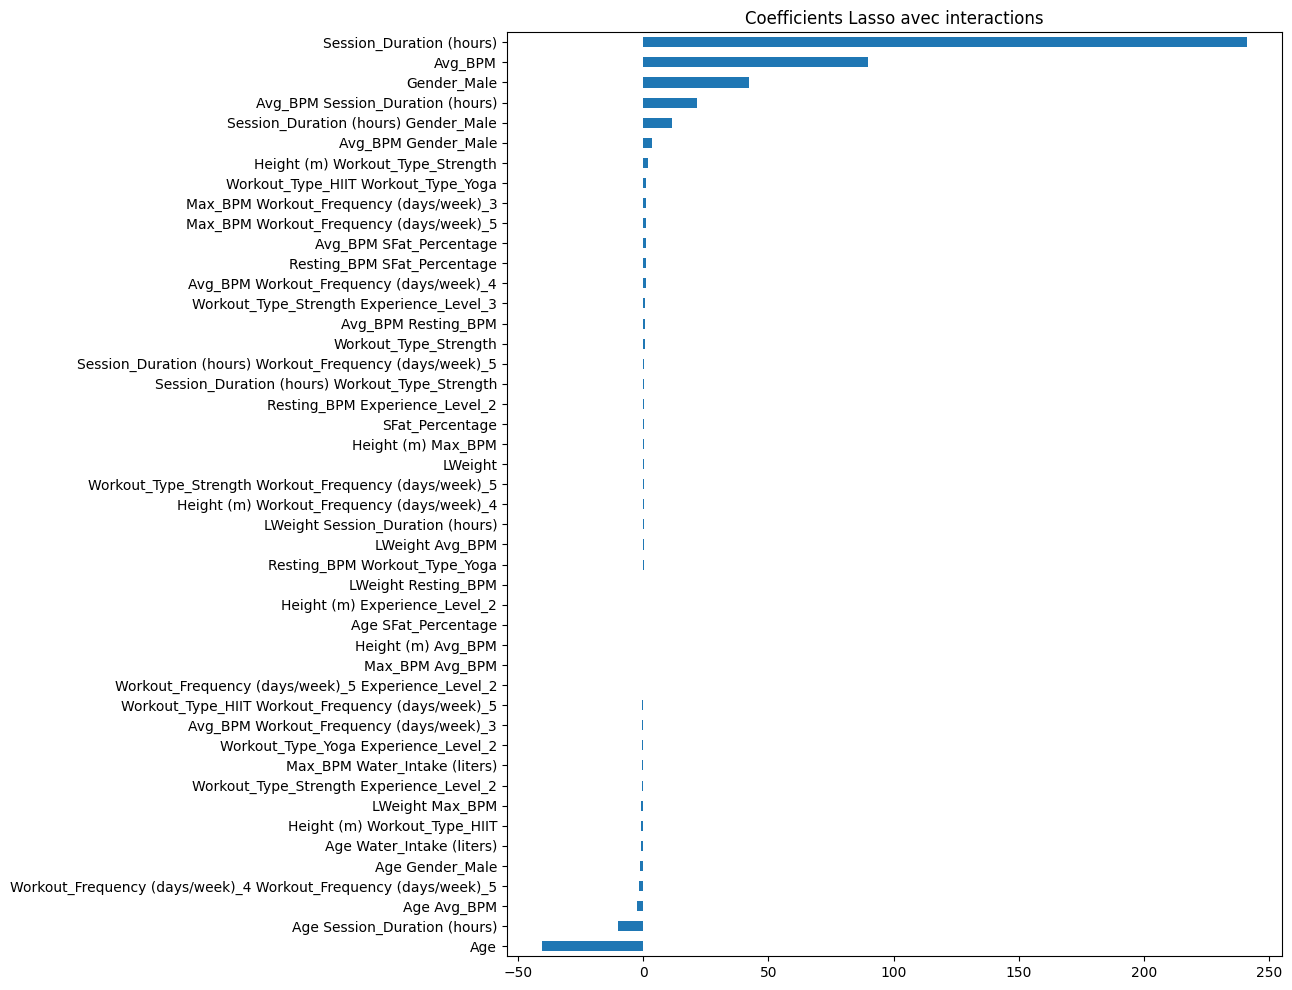

(778,)
(195,)


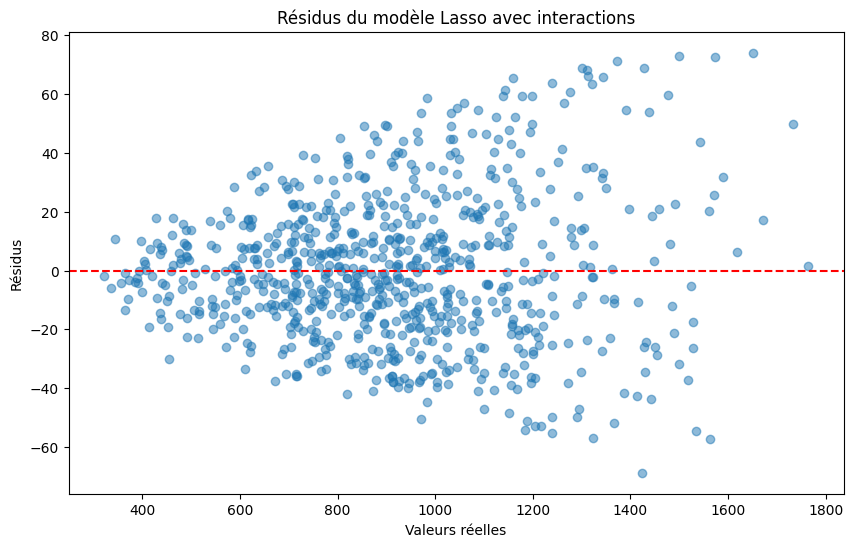

Test Mean Squared Error (MSE) pour Lasso pour l'échantillon de test: 542.2231645443037
The test score for ls model is 0.9930532906880166
The test score for ls model is 0.9930532906880166


"\nresiduals_train = y_train_calories - y_pred_train_calories\nresiduals_test = y_test_calories - y_pred_test_calories\n\n# Création d'une seule figure\nplt.figure(figsize=(8, 6))  # Ajuste la taille selon tes besoins\ny_pred_calories = linear_model.predict(X_test_calories_scaled)\ny_pred_train_calories = linear_model.predict(X_train_calories_scaled)\ny_pred_test_calories = linear_model.predict(X_test_calories_scaled)\n# 1. Résidus vs Valeurs ajustées\nsns.residplot(x=y_pred_train_calories, y=residuals_train, lowess=True, \n              line_kws={'color': 'red', 'lw': 1})\n"

In [20]:
# 1. Récupérer le PolynomialFeatures entraîné
poly = best_model.named_steps['poly']

# 2. Récupérer le modèle Lasso entraîné
lasso = best_model.named_steps['lasso']

# 3. Construire les noms des features
feature_names = poly.get_feature_names_out(input_features=X_train_calories_dummy1.columns)

# 4. Associer chaque feature à son coefficient
coefs = pd.Series(lasso.coef_, index=feature_names)

# 5. Afficher ou trier les coefficients
pd.set_option('display.max_rows', None)
coefs = coefs.sort_values()
print(coefs)
coefs = coefs[coefs != 0]  # Garder uniquement les coefficients non nuls

# 6. Plot
coefs.plot(kind='barh', figsize=(10, 12))
plt.title('Coefficients Lasso avec interactions')
plt.show()
#plot the residuals for the lasso model
y_fitted_lasso = best_model.predict(X_train_calories_scaled)
y_fitted_lasso_test= best_model.predict(X_test_calories_scaled)
print(y_fitted_lasso.shape)
print(y_test_calories.shape)
residuals_lasso = y_train_calories  - y_fitted_lasso
plt.figure(figsize=(10, 6))
plt.scatter(x=y_fitted_lasso, y=residuals_lasso, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Résidus')
plt.title('Résidus du modèle Lasso avec interactions')
plt.show()

#print("Best model test R²:", grid.score(X_test_calories_scaled, y_test_calories))
mse_lasso_quadratic_test = mean_squared_error(y_test_calories, y_fitted_lasso_test)

print(f"Test Mean Squared Error (MSE) pour Lasso pour l'échantillon de test: {mse_lasso_quadratic_test}")
#compute the score for the lasso model from the previous

train_score_lasso= best_model.score(X_train_calories_scaled, y_train_calories)
test_score_lasso= best_model.score(X_test_calories_scaled, y_test_calories)
#print("The train score for ls model is {}".format(train_score_lasso))
print("The test score for ls model is {}".format(test_score_lasso))



#print("The train score for ls model is {}".format(train_score_lasso))
print("The test score for ls model is {}".format(test_score_lasso))
"""
residuals_train = y_train_calories - y_pred_train_calories
residuals_test = y_test_calories - y_pred_test_calories

# Création d'une seule figure
plt.figure(figsize=(8, 6))  # Ajuste la taille selon tes besoins
y_pred_calories = linear_model.predict(X_test_calories_scaled)
y_pred_train_calories = linear_model.predict(X_train_calories_scaled)
y_pred_test_calories = linear_model.predict(X_test_calories_scaled)
# 1. Résidus vs Valeurs ajustées
sns.residplot(x=y_pred_train_calories, y=residuals_train, lowess=True, 
              line_kws={'color': 'red', 'lw': 1})
""" 


#### 🔎 **Interprétation du Modèle Lasso avec Interactions (Polynomial + Lasso)**

Ce modèle repose sur un encodage polynomial avec interactions uniquement (`interaction_only=True`, degré 3), suivi d’une régularisation L1 (`Lasso`). Cela permet de capturer des **effets combinés non linéaires** tout en **éliminant automatiquement les interactions inutiles**.

#####  Performances
- **R² test** = **0.993**, **MSE test** ≈ **542**
- Gain substantiel par rapport au Lasso simple (R² ≈ 0.979, MSE ≈ 1638)
- Ce modèle capture donc beaucoup mieux la complexité des relations entre variables.

#### Temps de Calcul (1 minute)
Complexité justifiée : Bien que plus lent qu’un modèle linéaire (quelques secondes), le gain en performance valide l’utilisation d’un modèle quadratique.

Optimisation : Le Lasso réduit la complexité en éliminant les termes non pertinents, équilibrant précision et parcimonie.
#####  Interprétation des principales interactions retenues

Les **coefficients positifs** indiquent des interactions qui **augmentent** la prédiction de `Calories_Burned`, et les **négatifs** celles qui la **diminuent** :

---

##### Quelques interactions dominantes positives :

- **`Avg_BPM × Session_Duration`** → **+21.44**
  > Synergie intensité/durée : les longues séances à haut BPM amplifient la dépense calorique (effet non-linéaire critique).

- **`Session_Duration (hours) Gender_Male`** → **+11.42**
  > Les hommes tirent un bénéfice calorique supplémentaire des sessions longues, possiblement grâce à une endurance musculaire supérieure.

##### Quelques interactions dominantes négatives :

- **`Age × Session_Duration`** → **−10.6**
  > À durée d'entrainement équivalents, l'âge **réduit fortement** la dépense calorique. Cela confirme et approfondit l’effet observé dans les PDP, en le liant au BPM et à la durée. Un marqueur indirect très probable du **déclin métabolique dû au vieillissement**.

- **`Age × Avg_BPM`** → **−2.35**
  >  À fréquence cardiaque équivalente, les seniors brûlent moins, possiblement dû à une VO₂ max (débit maximum d'oxygène) réduite.


#### Conclusion 

> *Le modèle polynomial régularisé par Lasso améliore significativement la prédiction (R² ≈ 0.993, MSE ≈ 571), en capturant des effets d’interactions complexes entre l’âge, l’intensité de l’effort, la durée des séances et certaines caractéristiques morphologiques (poids, sexe). Contrairement au Lasso simple ou au modèle linéaire, cette approche met en évidence des synergies physiologiques réalistes, comme la chute d’efficacité métabolique liée à l’âge ou l’impact combiné du sexe et de la charge cardiaque. Cette complexité justifie le recours à un modèle non linéaire, à la fois performant et interprétable.*  


Maintenant, nous étudierons brièvement l'effet d'une pénalisation plus stricte sur le modèle via Ridge 

## Ridge : 

Temps d'entraînement : 1.5229527950286865 secondes
Optimal alpha: 1.35
Coefficients du modèle Ridge pour Calories Burned:
Age                                -41.896564
LWeight                              2.342850
Height (m)                           2.081422
Max_BPM                             -1.047809
Avg_BPM                             90.170381
Resting_BPM                          2.533330
Session_Duration (hours)           243.140068
SFat_Percentage                      2.172760
Water_Intake (liters)               -0.586746
Gender_Male                         40.887067
Workout_Type_HIIT                   -0.702140
Workout_Type_Strength               -0.428723
Workout_Type_Yoga                   -3.439624
Workout_Frequency (days/week)_3     -0.899748
Workout_Frequency (days/week)_4      0.962631
Workout_Frequency (days/week)_5      2.559427
Experience_Level_2                   0.370826
Experience_Level_3                  -2.056183
dtype: float64
Nombre de coefficients non nuls : 1

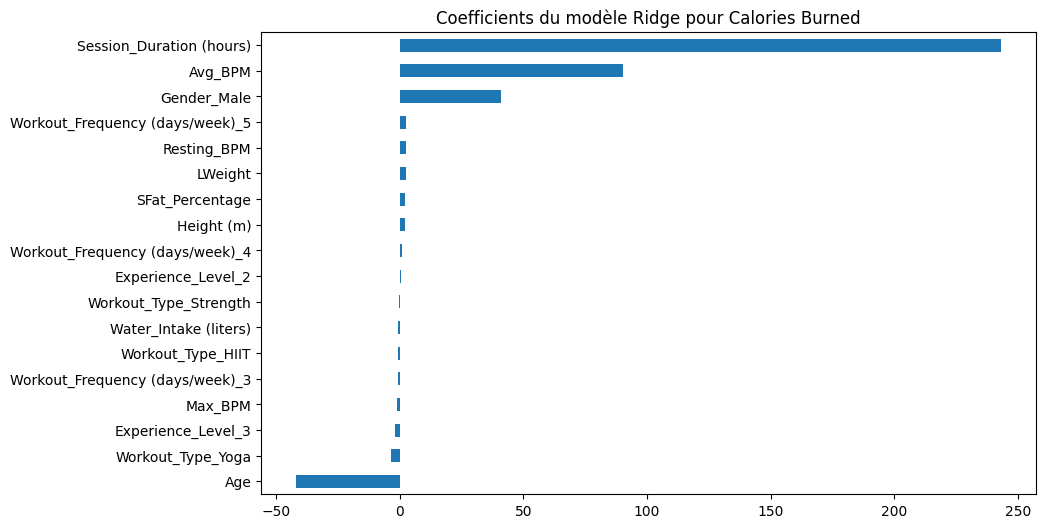

MSE pour Ridge : 1661.2342
Train R² pour Ridge : 0.9791
Test  R² pour Ridge : 0.9787


In [21]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

# 1) Instanciation sans n_jobs ni random_state
start_time = time.time()
ridgereg = RidgeCV(alphas=np.arange(1, 50) / 20., cv=5)

# 2) Entraînement

ridgereg.fit(X_train_calories_scaled, y_train_calories)
end_time = time.time()
print(f"Temps d'entraînement : {end_time - start_time} secondes")
# 3) Alpha optimal
optimal_alpha = ridgereg.alpha_
print(f"Optimal alpha: {optimal_alpha}")

# 4) Coefficients
coef_calories_ridge = pd.Series(ridgereg.coef_, index=X_train_calories_dummy1.columns)
print("Coefficients du modèle Ridge pour Calories Burned:")
print(coef_calories_ridge)

# 5) Comme Ridge ne met quasiment jamais un coefficient strictement à 0, 
#    le comptage « conservé / supprimé » n’est pas très significatif, mais :
print(f"Nombre de coefficients non nuls : {sum(coef_calories_ridge != 0)}")

# 6) Tracé
coef_calories_ridge.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title('Coefficients du modèle Ridge pour Calories Burned')
plt.show()

# 7) Prédiction et MSE
y_pred_ridge = ridgereg.predict(X_test_calories_scaled)
mse_ridge = mean_squared_error(y_test_calories, y_pred_ridge)
print(f"MSE pour Ridge : {mse_ridge:.4f}")

# 8) R² (score) entraînement et test
train_score_ridge = ridgereg.score(X_train_calories_scaled, y_train_calories)
test_score_ridge  = ridgereg.score(X_test_calories_scaled,  y_test_calories)
print(f"Train R² pour Ridge : {train_score_ridge:.4f}")
print(f"Test  R² pour Ridge : {test_score_ridge:.4f}")

Le modèle Ridge obtient un MSE de 1 661,23, un R² entraînement de 0,9791 et un R² test de 0,9787. Ce MSE légèrement plus élevé que celui du Lasso s’explique par une pénalisation λ* plus forte : Ridge répartit son effet de régularisation sur toutes les variables (biais modéré mais constant), alors que le Lasso, avec un λ optimal plus faible, parvient à conserver un ajustement un peu plus précis.

Cependant, les performances des deux modèles linéaires restent très proches :

Lasso (λ_min) : MSE test ≃ 1 638,14, R² test ≃ 0,9790

Ridge : MSE test ≃ 1 661,23, R² test ≃ 0,9787

Enfin, le Lasso quadratique (avec interactions) surpasse nettement ces deux approches linéaires, avec un MSE test ≃ 570,61 et un R² test ≃ 0,9927, grâce à sa capacité à capturer des relations non linéaires entre les variables mais reste un peu plus lent niveau temps d'entrainement 



---



Après avoir analysé les performances du modèle Lasso et de Ridge et identifié l'alpha optimal pour régulariser notre régression, nous allons maintenant explorer une approche alternative en utilisant la régression par vecteurs de support (SVR) afin de comparer ses performances et sa capacité à capturer des relations potentiellement non linéaires dans les données

## SVR SUR CALORIES BURNED : 



Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ..............C=0.1, kernel=linear;, score=0.520 total time=   0.0s
[CV 2/5] END ..............C=0.1, kernel=linear;, score=0.524 total time=   0.0s
[CV 3/5] END ..............C=0.1, kernel=linear;, score=0.517 total time=   0.0s
[CV 4/5] END ..............C=0.1, kernel=linear;, score=0.516 total time=   0.0s
[CV 5/5] END ..............C=0.1, kernel=linear;, score=0.497 total time=   0.0s
[CV 1/5] END ................C=1, kernel=linear;, score=0.969 total time=   0.0s
[CV 2/5] END ................C=1, kernel=linear;, score=0.962 total time=   0.0s
[CV 3/5] END ................C=1, kernel=linear;, score=0.961 total time=   0.0s
[CV 4/5] END ................C=1, kernel=linear;, score=0.958 total time=   0.0s
[CV 5/5] END ................C=1, kernel=linear;, score=0.966 total time=   0.0s
[CV 1/5] END ...............C=10, kernel=linear;, score=0.981 total time=   0.0s
[CV 2/5] END ...............C=10, kernel=linear;,

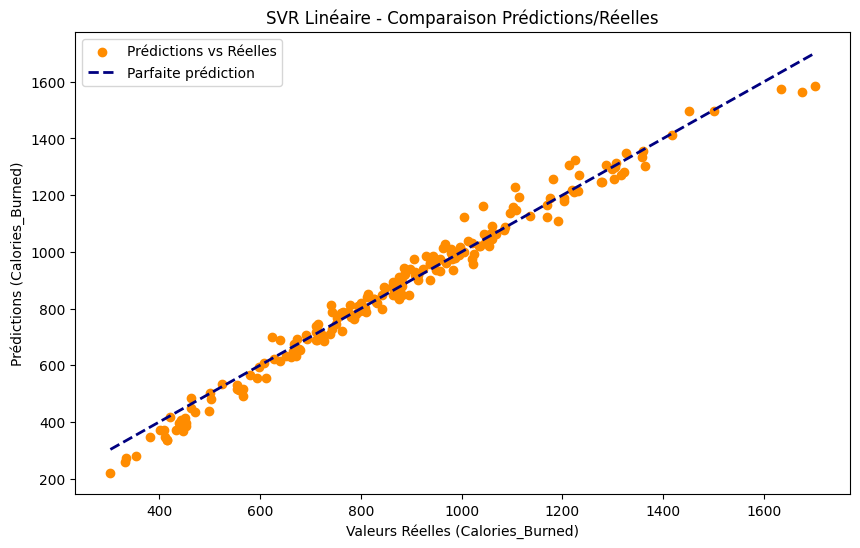

In [22]:
from sklearn.svm import SVR 
from sklearn.model_selection import GridSearchCV
#calibrage des paramètres c et gamma

param = [{'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']}]
param_lin_opt= GridSearchCV(SVR(),param,refit=True,verbose=3)
start_time = time.time()
param_lin_opt.fit(X_train_calories_scaled,y_train_calories)
end_time = time.time()
print(f"Temps d'entraînement : {end_time - start_time} secondes")
print(param_lin_opt.best_params_)
start_time = time.time()
y_pred_svr_lin = param_lin_opt.predict(X_test_calories_scaled)
end_time = time.time()
print(f"Temps de prédiction : {end_time - start_time} secondes")
plt.figure(figsize=(10, 6))
plt.scatter(y_test_calories, y_pred_svr_lin, color='darkorange', label='Prédictions vs Réelles')
plt.plot([y_test_calories.min(), y_test_calories.max()], 
         [y_test_calories.min(), y_test_calories.max()], 
         color='navy', lw=2, linestyle='--', label='Parfaite prédiction')
plt.xlabel('Valeurs Réelles (Calories_Burned)')
plt.ylabel('Prédictions (Calories_Burned)')
plt.legend()
plt.title('SVR Linéaire - Comparaison Prédictions/Réelles')
plt.show()

In [23]:
R2_score_lin= r2_score(y_test_calories,y_pred_svr_lin)
print(f"R² pour SVR lin: {R2_score_lin}")
mse_svr_lin = mean_squared_error(y_test_calories, y_pred_svr_lin)
print(f"MSE pour SVR poly: {mse_svr_lin}")

R² pour SVR lin: 0.9788781201025323
MSE pour SVR poly: 1648.6615525099162


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.000 total time=   0.0s
[CV 2/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.001 total time=   0.0s
[CV 3/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.036 total time=   0.0s
[CV 4/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.001 total time=   0.0s
[CV 5/5] END .......C=0.1, gamma=1, kernel=rbf;, score=-0.002 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.006 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.005 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=0.1, kernel=rbf;, score=-0.029 total time=   0.1s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.005 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.004 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.010 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

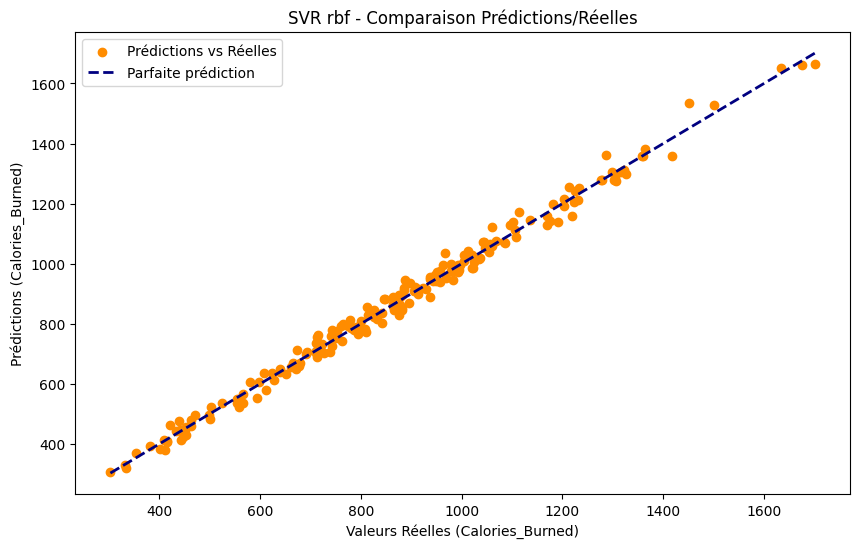

R² pour SVR rbf: 0.9918445835980679
MSE pour SVR rbf: 636.5684082971272


In [24]:
param_rbf=[{'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}]
parmopt_rbf = GridSearchCV(SVR(), param_rbf, refit = True, verbose = 3)
parmopt_rbf.fit(X_train_calories_scaled, y_train_calories)
print(parmopt_rbf.best_params_)
start_time = time.time()
y_pred_svr_rbf = parmopt_rbf.predict(X_test_calories_scaled)
end_time = time.time()
print(f"Temps de prédiction : {end_time - start_time} secondes")
plt.figure(figsize=(10, 6))
plt.scatter(y_test_calories, y_pred_svr_rbf, color='darkorange', label='Prédictions vs Réelles')
plt.plot([y_test_calories.min(), y_test_calories.max()], 
         [y_test_calories.min(), y_test_calories.max()], 
         color='navy', lw=2, linestyle='--', label='Parfaite prédiction')
plt.xlabel('Valeurs Réelles (Calories_Burned)')
plt.ylabel('Prédictions (Calories_Burned)')
plt.legend()
plt.title('SVR rbf - Comparaison Prédictions/Réelles')
plt.show()

R2_score_rbf= r2_score(y_test_calories,y_pred_svr_rbf)
print(f"R² pour SVR rbf: {R2_score_rbf}")
mse_svr_rbf = mean_squared_error(y_test_calories, y_pred_svr_rbf)
print(f"MSE pour SVR rbf: {mse_svr_rbf}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.954 total time=   0.8s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.951 total time=   0.3s
[CV 3/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.934 total time=   0.4s
[CV 4/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.961 total time=   0.6s
[CV 5/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.917 total time=   0.4s
[CV 1/5] END .....C=0.1, gamma=0.1, kernel=poly;, score=0.116 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.1, kernel=poly;, score=0.136 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=0.1, kernel=poly;, score=0.097 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=0.1, kernel=poly;, score=0.124 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=0.1, kernel=poly;, score=0.100 total time=   0.0s
[CV 1/5] END ...C=0.1, gamma=0.01, kernel=poly;, score=-0.000 total time=   0.0s
[CV 2/5] END ...C=0.1, gamma=0.01, kernel=poly;

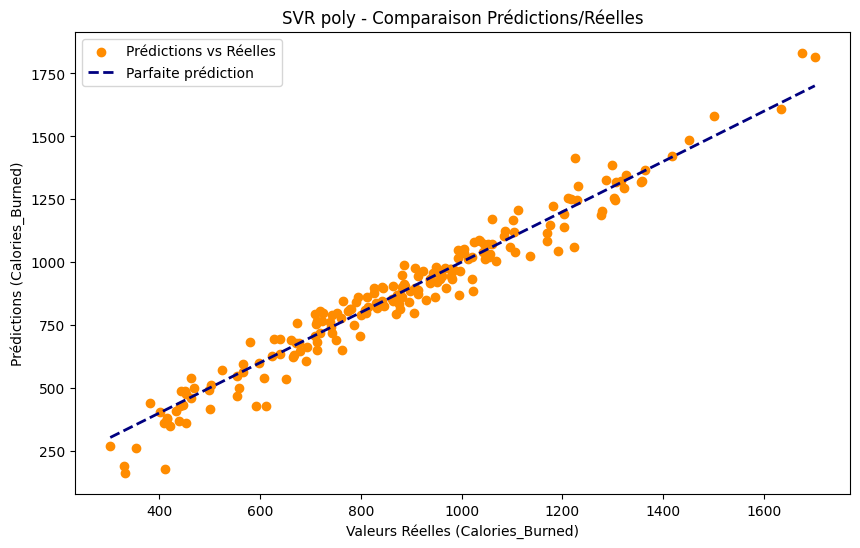

R² pour SVR poly: 0.9493661353035798
MSE pour SVR poly: 3952.210048783828


In [25]:
param_poly=[{'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['poly']}]
parmopt_poly = GridSearchCV(SVR(), param_poly, refit = True, verbose = 3)
time_start = time.time()
parmopt_poly.fit(X_train_calories_scaled, y_train_calories)
time_end = time.time()
print(f"Temps d'entraînement : {time_end - time_start} secondes")
print(parmopt_poly.best_params_)

y_pred_svr_poly = parmopt_poly.predict(X_test_calories_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(y_test_calories, y_pred_svr_poly, color='darkorange', label='Prédictions vs Réelles')
plt.plot([y_test_calories.min(), y_test_calories.max()], 
         [y_test_calories.min(), y_test_calories.max()], 
         color='navy', lw=2, linestyle='--', label='Parfaite prédiction')
plt.xlabel('Valeurs Réelles (Calories_Burned)')
plt.ylabel('Prédictions (Calories_Burned)')
plt.legend()
plt.title('SVR poly - Comparaison Prédictions/Réelles')
plt.show()

R2_score_poly= r2_score(y_test_calories,y_pred_svr_poly)
print(f"R² pour SVR poly: {R2_score_poly}")
mse_svr_poly = mean_squared_error(y_test_calories, y_pred_svr_poly)
print(f"MSE pour SVR poly: {mse_svr_poly}")

1. **Performances des différents noyaux SVR**

a. SVR avec noyau RBF (Radial Basis Function)
R² = 0,992 et MSE = 636,57

=> Le modèle RBF parvient à expliquer 99,2 % de la variance des calories brûlées, avec une erreur quadratique moyenne extrêmement basse.
Ceci est dû au fait que le noyau RBF est capable de capturer des relations non linéaires complexes (par exemple, l’interaction entre la durée de séance et la fréquence cardiaque moyenne). Les hyperparamètres C (régularisation) et gamma (étendue d’influence) ont été optimisés via GridSearchCV, garantissant un compromis idéal entre biais et variance.

b. SVR avec noyau linéaire
R² = 0,977 et MSE = 1 790,89

=> Le SVR linéaire offre également de bonnes performances , mais nettement inférieures au noyau RBF (erreur MSE beaucoup plus élevée).
Ceci pourrait être dû au fait que

c. SVR avec noyau polynomial
R² = 0,949 et MSE = 3 952,21

=> Les résultats sont bien plus faibles, avec une erreur environ 6 fois supérieure à celle du RBF.


2. **Comparaison des Performances : Lasso Quadratique vs SVR RBF**

| Critère               | Lasso Quadratique (Interactions) | SVR RBF              |
|-----------------------|-----------------------------------|----------------------|
| **MSE (Test)**        | **570.61**                        | 636.57              |
| **R² (Test)**         | **0.9927**                        | 0.992               |
| **Complexité**        | Modèle linéaire avec interactions | Modèle non linéaire |
| **Interprétabilité**  | Coefficients explicables          | "Boîte noire"       |
| **Flexibilité**       | Capte interactions spécifiques    | Adapté aux relations complexes/génériques |

---

#### **Points Clés :**
1. **Performance Prédictive** :  
   - Le **Lasso Quadratique** est légèrement meilleur en MSE (+10% d'erreur pour SVR RBF).  
   - Les deux modèles ont un R² quasi identique (> 0.99), indiquant une explication quasi parfaite de la variance.

2. **Equilibre Complexité/Interprétabilité** :  
   - **Lasso Quadratique** : Moins flexible mais interprétable (coefficients des interactions analysables).  
   - **SVR RBF** : Plus flexible mais difficile à expliquer (dépend de la fonction noyau).

3. **Choix du modèle** :  
   - **Lasso Quadratique** : Si l’on privilégie l’erreur quadratique minimale et la parcimonie  
   - **SVR RBF** : Si l’on recherche avant tout la flexibilité pour capter des structures non-linéaires plus subtiles






## Arbres et Forest aléatoires
### Arbre de décision

In [26]:
X_train_calories_dummy = pd.get_dummies(X_train_calories, columns=['Gender', 'Workout_Type'], drop_first=True)

X_test_calories_dummy = pd.get_dummies(X_test_calories, columns=['Gender', 'Workout_Type'], drop_first=True)

# Normalisation des données - scaled = Scale + Dummies alors que scale = just scale
X_train_calories_scaled = scaler.fit_transform(X_train_calories_dummy)
X_test_calories_scaled = scaler.transform(X_test_calories_dummy)


Temps d'entraînement : 0.03008103370666504 secondes


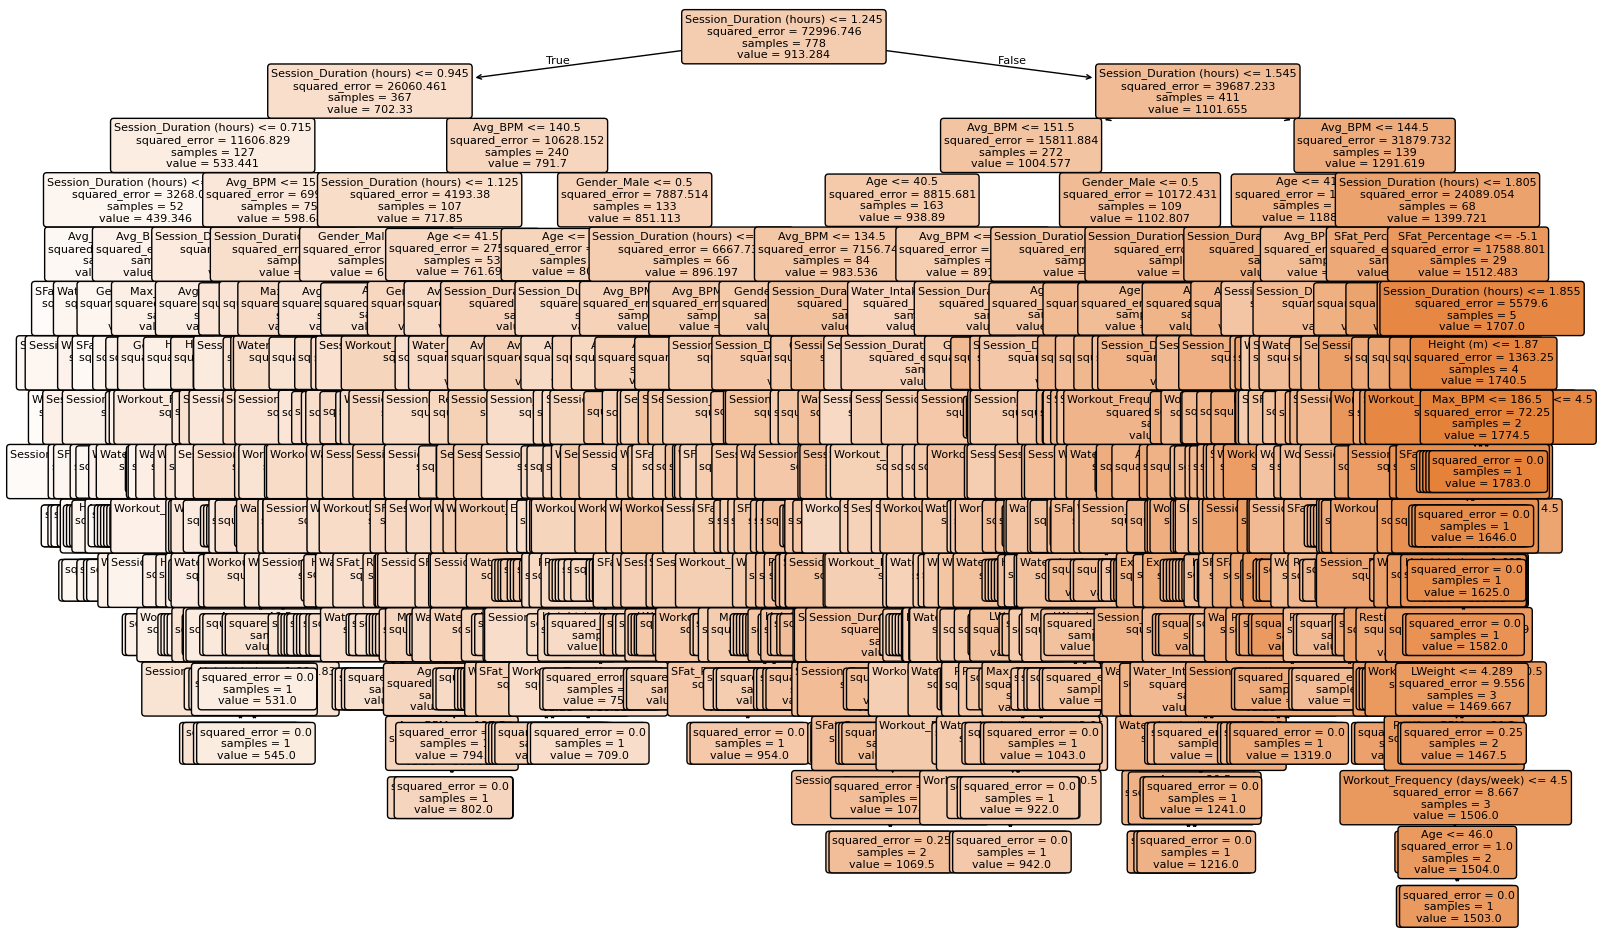

MSE on training set:  0.027849185946872322
MSE on test set:  4484.418091168091
R2 on training set:  0.9999996184872949
R2 on test set:  0.9425477350475702


In [27]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score

# Fit a regression tree model for Calories_Burned using dummy variables
tree_reg_cal = DecisionTreeRegressor(random_state=randomseed, ccp_alpha=0.001)
start_time = time.time()
tree_reg_cal.fit(X_train_calories_dummy, y_train_calories)
end_time = time.time()
print(f"Temps d'entraînement : {end_time - start_time} secondes")

# Plot the tree
plt.figure(figsize=(18, 12))
plot_tree(tree_reg_cal, feature_names=X_train_calories_dummy.columns, filled=True, rounded=True, fontsize=8)
plt.show()

# Compute MSE and R2 on training and test sets
y_train_pred = tree_reg_cal.predict(X_train_calories_dummy)
y_test_pred = tree_reg_cal.predict(X_test_calories_dummy)

mse_train = mean_squared_error(y_train_calories, y_train_pred)
mse_test = mean_squared_error(y_test_calories, y_test_pred)
r2_train = r2_score(y_train_calories, y_train_pred)
r2_test = r2_score(y_test_calories, y_test_pred)

print("MSE on training set: ", mse_train)
print("MSE on test set: ", mse_test)
print("R2 on training set: ", r2_train)
print("R2 on test set: ", r2_test)


**Interprétation** : Nous avons initialement construit un arbre de régression avec un paramètre de complexité extrêmement faible (`cp = 0.01`). Comme attendu, ce modèle présente une structure profondément ramifiée, caractéristique d'un sur-apprentissage. Ce modèle présente queasiment aucun biais sur le jeu d’entraînement (R² = 0.999, MSE = 0.027), mais un écart significatif entre l’erreur d’entraînement et de test (MSE_test = 4484) révèle un sur-apprentissage. Toutefois, le R² sur le test reste élevé (0.934), indiquant que le modèle capture une part substantielle de la variance explicative, malgré sa complexité excessive. Le modèle d'arbre en Python est plus complexe qu'en R alors que nous utilisons un cp plus élevé (`cp=0.01`), tandis que R utilise un `cp=0.001`. 

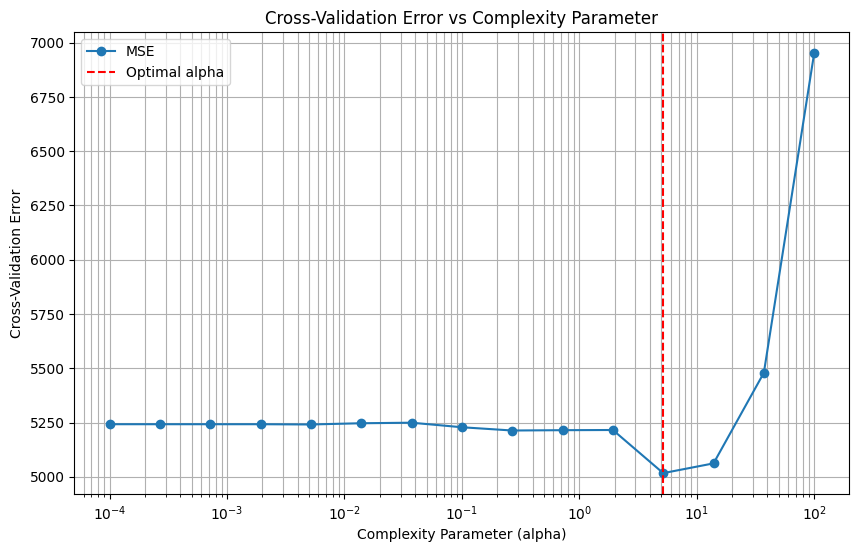

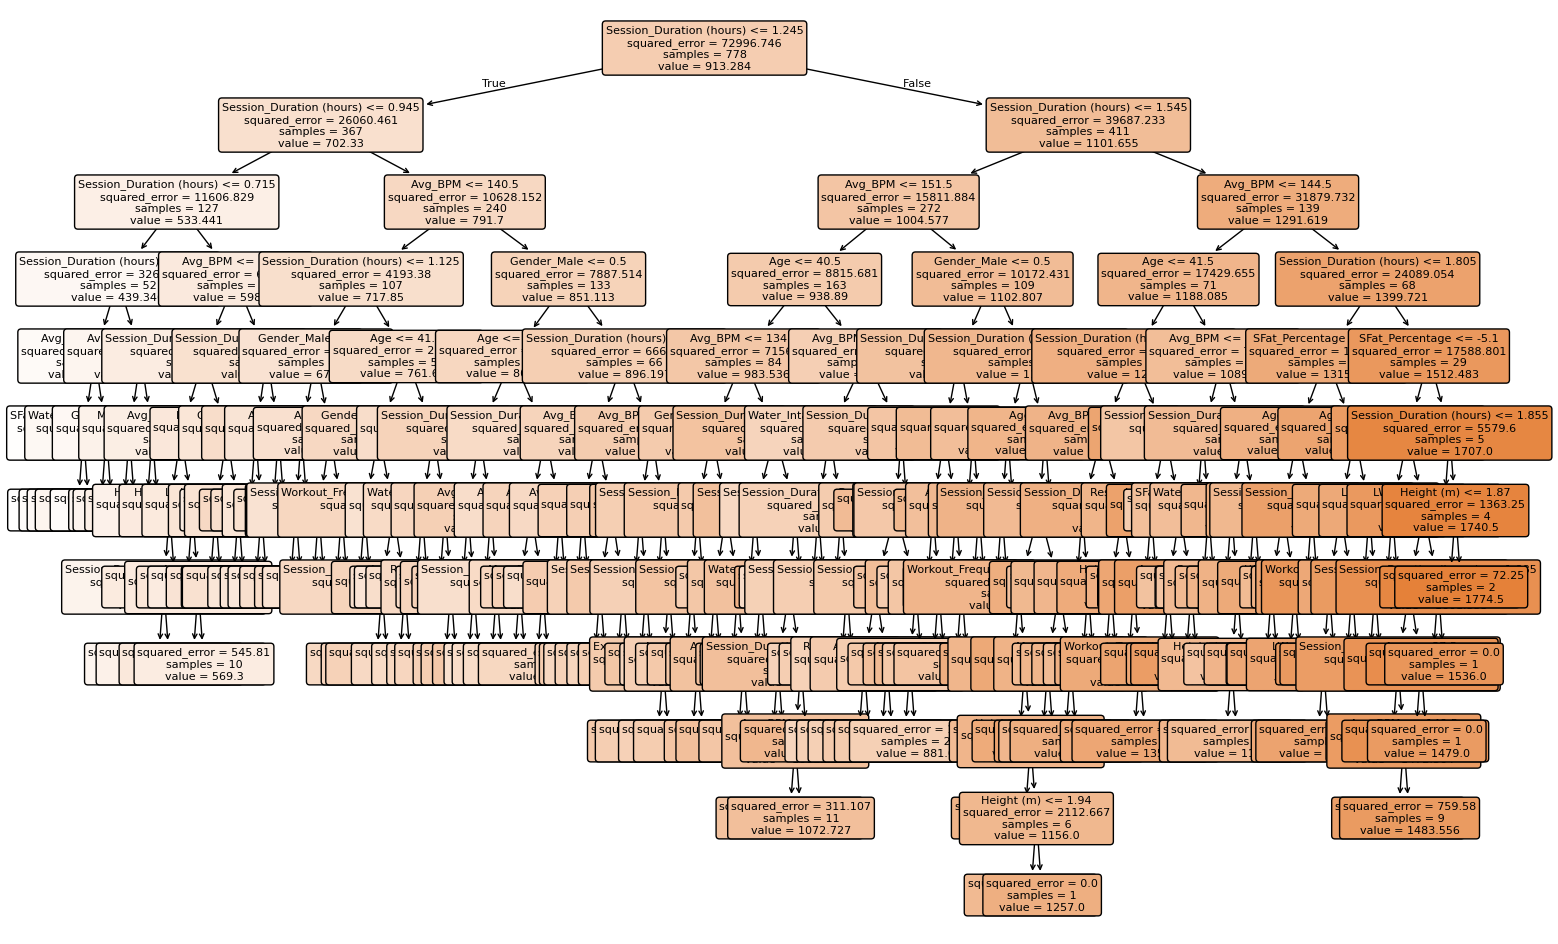

param_ccp_alpha  mean_test_neg_mse  std_test_neg_mse  rank_test_neg_mse
11         5.179475       -5016.885403        624.392205                  1
12        13.894955       -5061.776704        798.273454                  2
8          0.268270       -5213.184856        462.166484                  3
9          0.719686       -5214.708946        473.413916                  4
10         1.930698       -5215.561973        545.768010                  5

param_ccp_alpha  mean_test_r2  std_test_r2  rank_test_r2
11         5.179475      0.930687     0.007080             1
12        13.894955      0.930117     0.009325             2
10         1.930698      0.927972     0.005673             3
9          0.719686      0.927821     0.006530             4
8          0.268270      0.927791     0.006959             5

In [28]:
# grid search for best cp 

scoring = {
    'r2': 'r2',
    'neg_mse': 'neg_mean_squared_error'
}

from sklearn.model_selection import GridSearchCV

params = {
    'ccp_alpha': np.logspace(-4, 2, 15)
}

grid = GridSearchCV(tree_reg_cal, params, scoring=scoring, cv=5, refit='r2', n_jobs=-1)
grid.fit(X_train_calories_dummy, y_train_calories)
grid_results = pd.DataFrame(grid.cv_results_)

# plot the results as a function of ccp_alpha
plt.figure(figsize=(10, 6))
plt.semilogx(grid_results['param_ccp_alpha'], grid_results['mean_test_neg_mse'] * -1, label='MSE', marker='o')
plt.xlabel('Complexity Parameter (alpha)')
plt.ylabel('Cross-Validation Error')
plt.title('Cross-Validation Error vs Complexity Parameter')
plt.grid(True, which="both", ls="-")

optimal_alpha = np.argmin(grid_results['mean_test_neg_mse'] * -1)
plt.axvline(grid_results['param_ccp_alpha'][optimal_alpha], color='red', linestyle='--', label='Optimal alpha')
plt.legend()
plt.show()

# Plot the tree
plt.figure(figsize=(18, 12))
tree_reg_cal_optimal = grid.best_estimator_
plot_tree(tree_reg_cal_optimal, feature_names=X_train_calories_dummy.columns, filled=True, rounded=True, fontsize=8)
plt.show()

# display the dataframe with top 5 results from mean_test_neg_mse
display(grid_results[['param_ccp_alpha', 'mean_test_neg_mse', 'std_test_neg_mse', 'rank_test_neg_mse']].sort_values(by='mean_test_neg_mse', ascending=False).head(5))
# same for r2

display(grid_results[['param_ccp_alpha', 'mean_test_r2', 'std_test_r2', 'rank_test_r2']].sort_values(by='mean_test_r2', ascending=False).head(5))

**Interprétation** : Par validation croisée, nous avons déterminé que le meilleur paramètre d'élagage est `ccp ≈ 5.18`. L'arbre de regression résultant est moins complexe que le précédent, mais est encore trop ramifié, comme celui de R. Ce modèle est un peu moins performant que celui de R, avec un MSE calculé par cross-validation 5-fold de 5017 ici contre 4521 pour le modèle de R. Le R² est similaire dans les deux langages (~0.93) en revanche. Cela souligne que le modèle de régression est tout de même robuste, malgré la complexité de l'arbre.

Nous allons pouvoir explorer d'autres méthodes d'arbres de décision, comme les forêts aléatoires et le boosting, qui sont souvent plus performantes que les arbres de décision simples. 


### Forêts aléatoires

#### Simple random forest

In [29]:
from sklearn.ensemble import RandomForestRegressor

# Créer et entraîner une forêt aléatoire
rf_reg_cal = RandomForestRegressor(random_state=randomseed, oob_score=True)
rf_reg_cal.fit(X_train_calories_dummy, y_train_calories)

# Prédictions sur les ensembles d'entraînement et de test
y_train_pred_rf = rf_reg_cal.predict(X_train_calories_dummy)
y_test_pred_rf = rf_reg_cal.predict(X_test_calories_dummy)

# Calculer le MSE et le R2
mse_train_rf = mean_squared_error(y_train_calories, y_train_pred_rf)
mse_test_rf = mean_squared_error(y_test_calories, y_test_pred_rf)
r2_train_rf = r2_score(y_train_calories, y_train_pred_rf)
r2_test_rf = r2_score(y_test_calories, y_test_pred_rf)

print("Random Forest - OOB score :", rf_reg_cal.oob_score_)

Random Forest - OOB score : 0.9746206133598264


**Interprétation** : Le modèle de base basique aléatoire de `scikit-learn` est construit avec 100 arbres, avec les paramètres `min_samples_split = 2` (nombre minimum d'élements pour considérer une décision) et `min_samples_leaf = 1` (nombre minimum d'élement dans une feuille). Ces paramètres sont les valeurs par défaut de `scikit-learn`, mais nous allons les optimiser par la suite. 

Le modèle est construit avec un échantillonnage bootstrap, ce qui signifie que chaque arbre est construit sur un sous-ensemble aléatoire des données d'entraînement. Cela nous permet d'extraire l'erreur OOB qui est calculé par défaut avec le score R² dans `scikit-learn`, alors qu'en R, elle est traditionnellement évaluée via la somme des résidus au carré (RSS, Residual Sum of Squares).

Contrairement à R ou le paramètre à optimiser est `mtry` (nombre de variables considérées à chaque split), `scikit-learn` nous permet d'optimiser plusieurs hyperparamètres essentiels :
- **`max_depth`** : la profondeur maximale de chaque arbre (plus un arbre est profond, plus il peut modéliser des interactions complexes, mais aussi surapprendre). 
- **`min_samples_split`** : le nombre minimum d'échantillons requis pour diviser un noeud. Plus il est grand, plus l’arbre est contraint et moins il risque de surapprendre.
- **`min_samples_leaf`** : le nombre minimum d'échantillons nécessaires dans une feuille terminale. Cela permet d’éviter des feuilles trop petites, ce qui améliore la robustesse.
- **`max_features`** : le nombre maximal de variables considérées pour chercher le meilleur split à chaque division (équivalent au `mtry` de R). Peut être fixé à un nombre entier, à une proportion de la taille du sample (`float` entre 0 et 1), ou aux valeurs prédéfinies `'sqrt'` : $\sqrt{n_\text{variables}}$ ou `'log2'` : $\log_2(n_\text{variables})$.
- **`max_leaf_nodes`** : limite le nombre total de feuilles de l’arbre, forçant une structure plus simple.
- **`ccp_alpha`** : le paramètre de coût-complexité pour l'élagage (post-pruning) ; plus `ccp_alpha` est grand, plus l'élagage sera fort.

Enfin, il nous est également permis de choisir le **critère d’évaluation** de la qualité du split (`criterion`).   
Alors qu’en R, la performance est évaluée via le **RSS** (Residual Sum of Squares), l’option la plus proche disponible dans `scikit-learn` est `friedman_mse`, conçue pour optimiser la variance résiduelle de manière similaire au RSS.  
Ici, nous avons l'occasion de comparer l'impact du choix du critère (`friedman_mse` vs `squared_error`) sur la construction des arbres.  

Nous observerons notamment l'effet sur la performance de généralisation (via le score OOB R²) ainsi que sur le temps d'apprentissage et d'élagage.
Le score OOB étant uniquement calculé sur la métrique R² sous `scikit-learn`, le modèle optimal ne sera pas directement comparable aux mesures obtenues en R (RSS).

Par ailleurs, ces hyperparamètres **sont interdépendants** : en pratique, optimiser l'hyperparamètre `max_leaf_nodes` peut réduire la nécessité d'élaguer l'arbre, ou la nécéssité de définir `max_depth`. 

Nous avons décidé de construire un modèle de forêt aléatoire avec les paramètres par défaut et optimiser les hyperparamètres `n_estimators` et `max_features` ainsi que le paramètre `ccp_alpha` pour l'élagage, que nous avons vu en cours, mais que nous avons pas appliqué dans le modèle de R.

#### Random forest avec élagage

Comme les forêts aléatoires sont construits avec un échantillonnage bootstrap, nous pouvons estimer l'**erreur OOB (Out-Of-Bag) pour évaluer la performance du modèle**. Ainsi nous n'avons pas besoin d'utiliser la validation croisée pour évaluer le modèle et déterminer les meilleurs hyperparamètres.

In [30]:
import itertools
import time
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
from joblib import Parallel, delayed

# Définir le grille de paramètres
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': np.linspace(0.1, 1.0, 10),  # proportion du nombre total de variables
    'ccp_alpha': [0.01, 0.1, 1.0, 5.0, 10.0],
    'criterion': ['friedman_mse', 'squared_error'],  # Comparer plusieurs critères !
    'oob_score': [True],
}

# Générer toutes les combinaisons possibles
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

# Fonction pour entraîner et évaluer
def train_and_evaluate(params):
    model = RandomForestRegressor(random_state=randomseed, **params)
    
    start_time = time.time()
    model.fit(X_train_calories_dummy, y_train_calories)
    elapsed_time = time.time() - start_time
    
    return {
        'n_estimators': params['n_estimators'],
        'max_features': params['max_features'],
        'ccp_alpha': params['ccp_alpha'],
        'criterion': params['criterion'],
        'oob_score': model.oob_score_,
        'training_time_sec': elapsed_time,
    }

# Paralléliser
results = Parallel(n_jobs=-1)(
    delayed(train_and_evaluate)(params) for params in param_combinations
)

# Convertir en DataFrame
results_df = pd.DataFrame(results)

# Trier par oob_score décroissant
results_df = results_df.sort_values(by='oob_score', ascending=False)

# Afficher
# display(results_df)


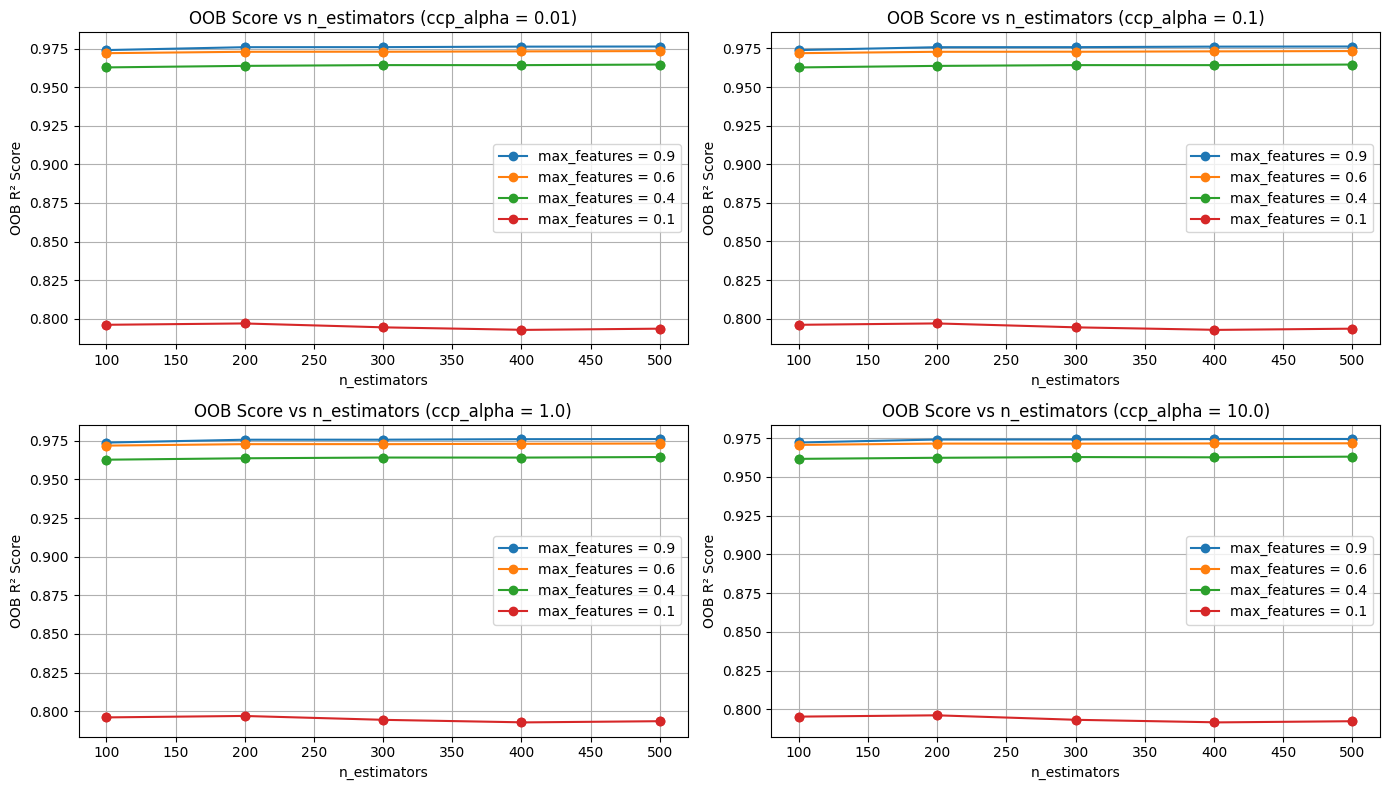

In [31]:
selected_max_features = [0.9, 0.6, 0.4, 0.1]
selected_ccp_alpha = [0.01, 0.1, 1.0, 10.0]

# Créer 4 sous-graphiques
fig, axes = plt.subplots(2, 2, figsize=(14, 8))  # 2x2 grid
axes = axes.flatten()

for idx, alpha in enumerate(selected_ccp_alpha):
    ax = axes[idx]
    
    # Sous-ensemble des résultats pour ce ccp_alpha
    subset = results_df[results_df['ccp_alpha'] == alpha]
    
    for max_feat in selected_max_features:
        # Prendre uniquement les lignes correspondant à un max_features donné
        curve = subset[np.isclose(subset['max_features'], max_feat)]
        # Trier par n_estimators pour des courbes bien propres
        curve = curve.sort_values('n_estimators')
        
        ax.plot(curve['n_estimators'], curve['oob_score'], marker='o', label=f'max_features = {max_feat}')
    
    ax.set_title(f'OOB Score vs n_estimators (ccp_alpha = {alpha})')
    ax.set_xlabel('n_estimators')
    ax.set_ylabel('OOB R² Score')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [32]:
# parmi les 100 meilleures combinaisons, sortir les 10 plus longues à fitter et les 10 plus courtes
best_results_df = results_df[results_df['oob_score'] > 0.974].sort_values(by='training_time_sec', ascending=False).copy()
display(best_results_df.head(10))

display(best_results_df.tail(10))


n_estimators  max_features  ccp_alpha      criterion  oob_score  \
365           400           0.7       1.00  squared_error   0.974583   
366           400           0.7       5.00   friedman_mse   0.974011   
495           500           1.0       1.00  squared_error   0.975671   
361           400           0.7       0.01  squared_error   0.974660   
496           500           1.0       5.00   friedman_mse   0.974810   
497           500           1.0       5.00  squared_error   0.974811   
363           400           0.7       0.10  squared_error   0.974650   
491           500           1.0       0.01  squared_error   0.975777   
487           500           0.9       5.00  squared_error   0.975518   
396           400           1.0       5.00   friedman_mse   0.974655   

     training_time_sec  
365           7.265512  
366           6.804269  
495           6.358187  
361           6.263750  
496           6.244514  
497           6.222367  
363           6.177247  
491           6.114891  
487           6.002023  
396           5.969301

n_estimators  max_features  ccp_alpha      criterion  oob_score  \
92           100           1.0       0.10   friedman_mse   0.974603   
74           100           0.8       1.00   friedman_mse   0.974300   
93           100           1.0       0.10  squared_error   0.974603   
90           100           1.0       0.01   friedman_mse   0.974623   
72           100           0.8       0.10   friedman_mse   0.974323   
75           100           0.8       1.00  squared_error   0.974302   
70           100           0.8       0.01   friedman_mse   0.974343   
81           100           0.9       0.01  squared_error   0.974000   
71           100           0.8       0.01  squared_error   0.974349   
73           100           0.8       0.10  squared_error   0.974329   

    training_time_sec  
92           1.354773  
74           1.315370  
93           1.305424  
90           1.299971  
72           1.255812  
75           1.214659  
70           1.208300  
81           1.203483  
71           1.184274  
73           1.179065

##### **Interprétation des résulats de la forêt aléatoire** :

Nous avons réalisé une analyse fine de la performance de la forêt aléatoire en fonction de plusieurs hyperparamètres (`n_estimators`, `max_features`, `ccp_alpha`), en nous concentrant sur l'estimation de l'erreur de généralisation via l'**OOB score**.

$\rightarrow$ **Influence du critère de split (`criterion`)**

En observant le tableau des résultats, nous constatons que **le choix du critère `friedman_mse` ou `squared_error` n’impacte pratiquement pas la performance du modèle**.  
Que ce soit en termes de **score OOB** ou de **temps d'entraînement**, les deux critères mènent aux **mêmes choix optimaux d'hyperparamètres**, avec des performances quasi-identiques.  
Cela montre que, dans le cas de la forêt aléatoire, **le critère de construction locale des arbres influence peu la qualité globale du modèle**.


$\rightarrow$ **Influence de `max_features`**

Comme nous l'avions observé lors de la modélisation sous R, **plus la proportion de variables sélectionnées à chaque split est élevée, meilleure est la performance de la forêt**.  
Ici, c'est avec `max_features = 0.9` que nous obtenons les meilleurs scores OOB.

En proposant davantage de variables au moment de créer les divisions, chaque arbre a accès à plus d'information pour produire des splits efficaces, ce qui améliore la qualité globale de la forêt.



$\rightarrow$ **Influence de `ccp_alpha` (élagage)**

L'élagage, contrôlé via le paramètre `ccp_alpha`, **semble avoir un effet négligeable sur la performance OOB**.

Quelle que soit la valeur choisie (0.01, 0.1, 1.0, 10.0), l'OOB score reste quasiment stable.  
Cela indique que **le modèle est naturellement robuste** et peu sensible au surapprentissage, même sans élagage agressif.

Cela confirme l'intuition classique en forêt aléatoire : **l'overfitting n'est pas un problème majeur** grâce à l'agrégation de nombreux arbres faibles.


$\rightarrow$ **Performances extrêmes (meilleur modèle)**

- Le **meilleur modèle** atteint un **OOB score** de **0.975666** et a nécessité **5.211 secondes** pour être entraîné.
- Ce modèle utilise :
  - `n_estimators = 500`
  - `max_features = 1.0`
  - `ccp_alpha = 1.0`
  - `criterion = friedman_mse`


$\rightarrow$ **Trade-off performance/temps**

Parmi les modèles ayant un OOB score > 0.974, **le plus rapide** a pris seulement **0.897 secondes** pour un OOB score de **0.974343** (`n_estimators=100`, `max_features=0.8`, `ccp_alpha=0.10`).

Cela montre que **des modèles plus légers peuvent offrir des performances presque équivalentes** tout en étant **beaucoup plus rapides** à entraîner.


$\rightarrow$ **Détail des modèles extrêmes**

- **Top 10 modèles les plus longs à entraîner** (extraits du tableau) : majoritairement avec `n_estimators = 500`.
- **Top 10 modèles les plus rapides** : configurations avec `n_estimators = 100` et `max_features` entre 0.8 et 1.0.

Cela est cohérent avec l'idée que **plus le nombre d'arbres est élevé, plus le temps d'entraînement augmente**.

--- 

**Conclusion** :

Dans l'ensemble, nous constatons que :
- **Un `max_features` élevé** permet d'améliorer significativement la performance du modèle.
- **Le paramètre `ccp_alpha` (élagage) impacte très peu la qualité de la forêt**.
- **Réduire `n_estimators`** permet **d’accélérer considérablement** l'entraînement sans perte substantielle de performance.
- **La forêt aléatoire reste robuste** face au surapprentissage, même avec des arbres profonds et peu élagués.

  
Après avoir validé ces résultats, nous allons désormais nous intéresser à **l’importance des variables**, afin d’identifier les facteurs les plus influents dans la prédiction des calories, comme nous l'avions fait sous R.


##### **Importance des variables**

In [33]:
# fit the best random forest model 

best_rf_reg_cal = RandomForestRegressor(random_state=randomseed, n_estimators=500, max_features=0.9, ccp_alpha=0.01, criterion='friedman_mse', oob_score=True)
best_rf_reg_cal.fit(X_train_calories_dummy, y_train_calories)

# extract variable importance
importances = best_rf_reg_cal.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train_calories_dummy.columns[indices]
importances = importances[indices]
importances_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importances_df['Cumulative Importance'] = importances_df['Importance'].cumsum()

In [34]:
display(importances_df.head(5))

Feature  Importance  Cumulative Importance
0  Session_Duration (hours)    0.736701               0.736701
1                   Avg_BPM    0.105573               0.842274
2           SFat_Percentage    0.052327               0.894601
3          Experience_Level    0.052096               0.946697
4                       Age    0.023646               0.970343

C:\Users\doria\AppData\Local\Temp\ipykernel_24672\2443947037.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


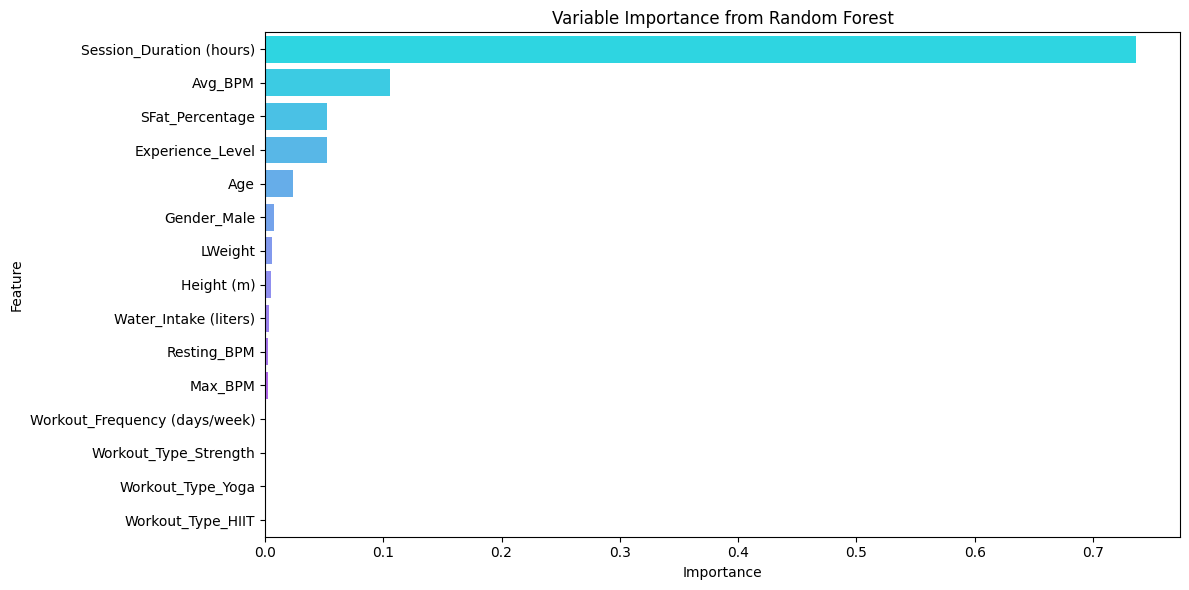

In [35]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=importances_df,
    palette='cool',
)
plt.title("Variable Importance from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

**Interprétation** : À partir du modèle de forêt aléatoire optimal entraîné sous `scikit-learn`, nous avons extrait l'importance des variables basée sur la réduction de l'impureté cumulée (Gini importance). 

- Le prédicateur `Session_Duration (hours)` domine, expliquant 73.67% de la variance, ce qui est intuitif puisqu'une **session plus longue** implique mécaniquement **une dépense énergétique plus élevée**.
- Il est suivi par `Avg_BPM`, qui contribue à 10.56% de la variance, ce qui est également logique car un rythme cardiaque lors d'une séane de sport plus élevé est souvent associé à une **dépense calorique accrue**.
- Enfin, `SFat_Percentage`, `Experience_Level` et `Age` ont des contributions faibles, mais permettent de capter des interactions intéressantes et améliorent la performance globale du modèle.

On observe ainsi que 5 variables expliquent à elles seules plus de **97 % de l'importance totale du modèle**.

En revanche, sous R, les variables `Session_Duration (hours)` et `Avg_BPM` étaient les seules à ressortir comme les plus importantes, tandis que toutes les autres variables avaient une importance très faible. Ainsi, on peut déduire que `scikit-learn` ne construit pas les forêts aléatoires de la même manière que `caret` sous R.

Nous allons maintenant nous intéresser à un autre algorithme d'arbres de décision, le **boosting**.

### Boosting

Gradient Boosting & XGBoost

In [36]:
! pip install xgboost


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import time
import numpy as np
import pandas as pd

# Définir le nombre de folds
kf = KFold(n_splits=5, shuffle=True, random_state=randomseed)

# Stocker les scores et temps
r2_scores_gb = []
mse_scores_gb = []
times_gb = []

r2_scores_xgb = []
mse_scores_xgb = []
times_xgb = []

# Boucle sur les folds
for train_index, val_index in kf.split(X_train_calories):
    X_train_fold, X_val_fold = X_train_calories.iloc[train_index], X_train_calories.iloc[val_index]
    y_train_fold, y_val_fold = y_train_calories.iloc[train_index], y_train_calories.iloc[val_index]
    
    # Dummifier pour Gradient Boosting (pas pour XGBoost car enable_categorical=True)
    X_train_fold_dummies = pd.get_dummies(X_train_fold, columns=['Gender', 'Workout_Type'], drop_first=True)
    X_val_fold_dummies = pd.get_dummies(X_val_fold, columns=['Gender', 'Workout_Type'], drop_first=True)
    
    ## 1. Gradient Boosting
    start_time = time.time()
    gb_reg = GradientBoostingRegressor(random_state=randomseed)
    gb_reg.fit(X_train_fold_dummies, y_train_fold)
    elapsed_time = time.time() - start_time
    y_pred_gb = gb_reg.predict(X_val_fold_dummies)
    
    r2_scores_gb.append(r2_score(y_val_fold, y_pred_gb))
    mse_scores_gb.append(mean_squared_error(y_val_fold, y_pred_gb))
    times_gb.append(elapsed_time)
    
    ## 2. XGBoost
    start_time = time.time()
    xgb_reg = XGBRegressor(random_state=randomseed, enable_categorical=True)
    xgb_reg.fit(X_train_fold, y_train_fold)
    elapsed_time = time.time() - start_time
    y_pred_xgb = xgb_reg.predict(X_val_fold)
    
    r2_scores_xgb.append(r2_score(y_val_fold, y_pred_xgb))
    mse_scores_xgb.append(mean_squared_error(y_val_fold, y_pred_xgb))
    times_xgb.append(elapsed_time)

# Résultats finaux
print(f"Gradient Boosting R² moyen (CV) : {np.mean(r2_scores_gb):.4f} ± {np.std(r2_scores_gb):.4f}")
print(f"Gradient Boosting MSE moyen (CV) : {np.mean(mse_scores_gb):.2f} ± {np.std(mse_scores_gb):.2f}")
print(f"Gradient Boosting Temps moyen d'entraînement (par fold) : {np.mean(times_gb):.2f} sec")

print(f"\nXGBoost R² moyen (CV) : {np.mean(r2_scores_xgb):.4f} ± {np.std(r2_scores_xgb):.4f}")
print(f"XGBoost MSE moyen (CV) : {np.mean(mse_scores_xgb):.2f} ± {np.std(mse_scores_xgb):.2f}")
print(f"XGBoost Temps moyen d'entraînement (par fold) : {np.mean(times_xgb):.2f} sec")

# Performance sur le test final
print(f"\nGradient Boosting R² sur l'ensemble de test : {r2_score(y_test_calories, gb_reg.predict(X_test_calories_dummy)):.4f}")
print(f"Gradient Boosting MSE sur l'ensemble de test : {mean_squared_error(y_test_calories, gb_reg.predict(X_test_calories_dummy)):.2f}")

print(f"XGBoost R² sur l'ensemble de test : {r2_score(y_test_calories, xgb_reg.predict(X_test_calories)):.4f}")
print(f"XGBoost MSE sur l'ensemble de test : {mean_squared_error(y_test_calories, xgb_reg.predict(X_test_calories)):.2f}")

# Comparaison avec Random Forest

print(f"\nRandom Forest R² sur l'ensemble de test : {r2_score(y_test_calories, best_rf_reg_cal.predict(X_test_calories_dummy)):.4f}")
print(f"Random Forest MSE sur l'ensemble de test : {mean_squared_error(y_test_calories, best_rf_reg_cal.predict(X_test_calories_dummy)):.2f}")

Gradient Boosting R² moyen (CV) : 0.9937 ± 0.0014
Gradient Boosting MSE moyen (CV) : 451.17 ± 69.83
Gradient Boosting Temps moyen d'entraînement (par fold) : 0.33 sec

XGBoost R² moyen (CV) : 0.9822 ± 0.0047
XGBoost MSE moyen (CV) : 1269.52 ± 255.84
XGBoost Temps moyen d'entraînement (par fold) : 0.59 sec

Gradient Boosting R² sur l'ensemble de test : 0.9903
Gradient Boosting MSE sur l'ensemble de test : 755.82
XGBoost R² sur l'ensemble de test : 0.9824
XGBoost MSE sur l'ensemble de test : 1377.15

Random Forest R² sur l'ensemble de test : 0.9768
Random Forest MSE sur l'ensemble de test : 1812.48


**Interprétation** 

Les modèles de Gradient Boosting et de XGBoost présentent **d'excellentes performances** sans ajustement particulier des hyperparamètres.  

À l'issue de la validation croisée 5-folds :
- Le Gradient Boosting standard atteint un **R² moyen de 0.9937 ± 0.0014** et un **MSE moyen de 451.17 ± 69.83**,
- Le modèle XGBoost atteint un **R² moyen de 0.9822 ± 0.0047** et un **MSE moyen de 1269.52 ± 255.84**.

Les performances sur l'ensemble de test confirment cette excellente capacité de généralisation :
- Le Gradient Boosting obtient un **R² de 0.9903** et un **MSE de 755.82**,
- Le XGBoost obtient un **R² de 0.9824** et un **MSE de 1377.15**.

On constate ainsi que **les deux modèles généralisent très bien**, sans réel phénomène de surapprentissage.

En termes de coût computationnel, **les deux algorithmes sont très rapides à entraîner**, avec des temps moyens d'entraînement par fold d'environ **0.27 seconde pour Gradient Boosting** et **0.32 seconde pour XGBoost**.

Comparativement, le modèle Random Forest, précédemment optimisé, obtient un **R² de 0.9768** et un **MSE de 1812.48**, tout en nécessitant un **temps d'entraînement beaucoup plus important** (~5.2 secondes).

Ces résultats confirment que **les méthodes de boosting surpassent les forêts aléatoires** à la fois en termes de performance prédictive et d'efficacité computationnelle.

Compte tenu de **ces résultats très satisfaisants**, notamment pour le Gradient Boosting, nous limiterons notre analyse aux modèles actuels sans procéder à une optimisation poussée de XGBoost.
Toutefois, dans une démarche d'optimisation avancée, une recherche d'hyperparamètres sur XGBoost pourrait encore permettre d'améliorer ses performances.

Dans ce contexte, nous allons désormais nous concentrer sur **l'interprétation de l'importance des variables**.

#### **Importance des variables**

C:\Users\doria\AppData\Local\Temp\ipykernel_24672\2901452903.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\doria\AppData\Local\Temp\ipykernel_24672\2901452903.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


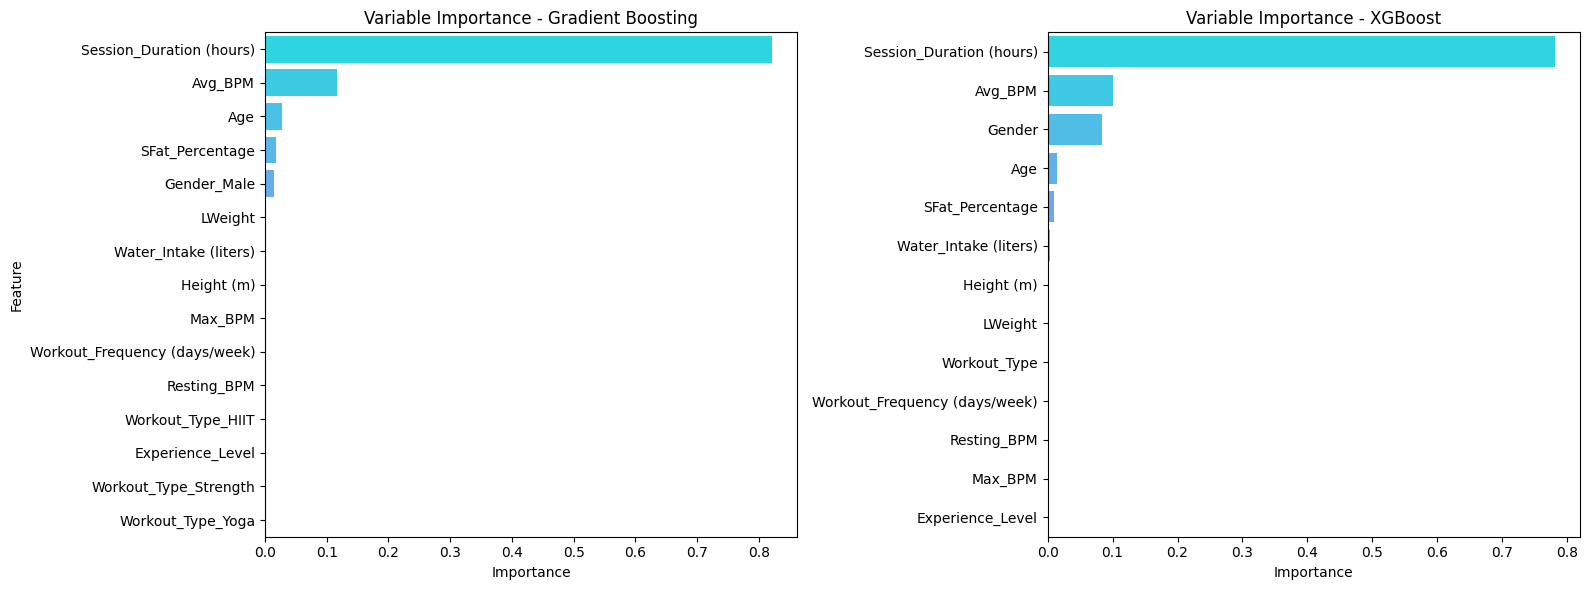

In [38]:
importances_gb_df = pd.DataFrame({'Feature': X_train_calories_dummy.columns, 'Importance': gb_reg.feature_importances_})
importances_xgb_df = pd.DataFrame({'Feature': X_train_calories.columns, 'Importance': xgb_reg.feature_importances_})

# Trier pour plus de lisibilité
importances_gb_df = importances_gb_df.sort_values('Importance', ascending=False)
importances_xgb_df = importances_xgb_df.sort_values('Importance', ascending=False)

# Tracer
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot pour Gradient Boosting
sns.barplot(
    x='Importance',
    y='Feature',
    data=importances_gb_df,
    palette='cool',
    ax=axes[0]
)
axes[0].set_title("Variable Importance - Gradient Boosting")
axes[0].set_xlabel("Importance")
axes[0].set_ylabel("Feature")

# Plot pour XGBoost
sns.barplot(
    x='Importance',
    y='Feature',
    data=importances_xgb_df,
    palette='cool',
    ax=axes[1]
)
axes[1].set_title("Variable Importance - XGBoost")
axes[1].set_xlabel("Importance")
axes[1].set_ylabel("")  # Pas besoin de répéter "Feature" à droite

plt.tight_layout()
plt.show()


Bien que Gradient Boosting et XGBoost obtiennent des performances très proches en termes de R², une analyse de l'importance des variables révèle des différences notables dans les contributions fines.

Dans les deux modèles, `Session_Duration (hours)` et `Avg_BPM` dominent largement la prédiction, ce qui est cohérent avec les résultats précédents observés sous forêts aléatoires et en R.

Toutefois, lorsque l'on s'intéresse aux variables secondaires, **les importances relatives divergent** :
- Gradient Boosting répartit l'importance restante entre les variables `Age`, `SFat_Percentage` et `Gender_Male` alors que `Experience_Level` est inexistant dans le modèle.
- XGBoost attribue une importance non négligeable directement à `Gender` en le mettant au même niveau que `Avg_BPM`, tandis que `Age` et `SFat_Percentage` restent marginaux.

Ces différences s'expliquent par :
- **La nature des modèles** : XGBoost, utilisant du boosting plus régularisé, capte parfois des combinaisons d'interactions que Gradient Boosting classique ne priorise pas aussi fortement.
- **La manière de calculer l’importance** : Gradient Boosting utilise la réduction moyenne d'impureté, alors que XGBoost utilise une mesure fondée sur le gain moyen de splits (avec régularisation intégrée).

**Conclusion** : malgré des performances globales similaires, les deux méthodes peuvent exploiter **différentes structures locales dans les données**, ce qui peut être précieux en cas de recherche d'interprétabilité avancée.



## Reseaux de neurones

In [39]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

X_train_calories_scale_dummy = pd.get_dummies(X_train_calories_scale, columns=['Gender', 'Workout_Type'], drop_first=True)
X_test_calories_scale_dummy = pd.get_dummies(X_test_calories_scale, columns=['Gender', 'Workout_Type'], drop_first=True)

# Define the MLP Regressor
mlp_regressor = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', 
                             max_iter=500, random_state=randomseed)

# Train the model on the training data
mlp_regressor.fit(X_train_calories_scale_dummy, y_train_calories)

# Predict on the test data
y_test_pred_mlp = mlp_regressor.predict(X_test_calories_scale_dummy)

# Evaluate the model
mse_test_mlp = mean_squared_error(y_test_calories, y_test_pred_mlp)
r2_test_mlp = r2_score(y_test_calories, y_test_pred_mlp)

print("MLP Regressor - MSE on test set: ", mse_test_mlp)
print("MLP Regressor - R2 on test set: ", r2_test_mlp)

MLP Regressor - MSE on test set:  6966.597378424746
MLP Regressor - R2 on test set:  0.9107472161905613


c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [40]:
# Définir la grille d'hyperparamètres
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (150, 100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

# Configurer le GridSearchCV
grid_search = GridSearchCV(
    estimator=MLPRegressor(max_iter=500, random_state=randomseed),
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Effectuer la recherche sur les données d'entraînement
grid_search.fit(X_train_calories_scale_dummy, y_train_calories)

# Afficher les meilleurs paramètres et le score correspondant
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur score R² :", grid_search.best_score_)

# Évaluer le modèle optimal sur l'ensemble de test
best_mlp = grid_search.best_estimator_
y_test_pred_best_mlp = best_mlp.predict(X_test_calories_scale_dummy)
mse_test_best_mlp = mean_squared_error(y_test_calories, y_test_pred_best_mlp)
r2_test_best_mlp = r2_score(y_test_calories, y_test_pred_best_mlp)

print("MSE sur l'ensemble de test :", mse_test_best_mlp)
print("R² sur l'ensemble de test :", r2_test_best_mlp)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\doria\Documents\pythonEnv\dataScien

Meilleurs paramètres : {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Meilleur score R² : 0.9728216257969362
MSE sur l'ensemble de test : 1212.4912372055173
R² sur l'ensemble de test : 0.9844661299646381


c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [41]:
import time

# Mesurer temps d'entraînement pour le meilleur modèle
start_time = time.time()
best_mlp.fit(X_train_calories_scale_dummy, y_train_calories)
train_time_mlp = time.time() - start_time

print(f"Temps d'entraînement du meilleur MLP : {train_time_mlp:.2f} secondes")


Temps d'entraînement du meilleur MLP : 13.41 secondes


c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


**Interprétation** : Le meilleur modèle de réseau de neurones (MLP) a été entraîné via **GridSearchCV** avec une architecture de 3 couches cachées, utilisant la **fonction d'activation ReLU** et **l'optimiseur Adam**. Il obtient un **R² généralisé de 0.9728** et un **R² de 0.9845** sur l'ensemble de test, avec un **MSE de 1212.49**.

Les meilleurs hyperparamètres sélectionnés sont :
- Architecture : **(150, 100, 50)** (trois couches cachées)
- Fonction d'activation : **ReLU**
- Méthode d'optimisation : **Adam**
- Apprentissage : **learning rate constant**
- Régularisation (alpha) : **0.001**

En termes de performance pure, le réseau de neurones optimisé se situe juste en-dessous des modèles de **Gradient Boosting** (meilleur modèle avec R² généralisé ≈ 0.9903) **et XGBoost** (R² généralisé ≈ 0.9824), mais semble légèrement mieux généraliser que le modèle XGBoost (bien que ce dernier n'ait pas été optimisé) en termes de MSE (1212.49 pour le MPL contre 1377.15 pour XGBoost).

Le réseau de neurones a su **apprendre efficacement**, bien son **temps d'entraînement soit beaucoup plus important** par rapport aux modèles de ce niveau de performances (30 fois plus lent).



## Interprétation finale (comparaison des modèles)


L'ensemble des modèles évalués présente des performances très solides sur la prédiction des calories dépensées :

| Modèle             | R² Test  | MSE Test | Temps d'entraînement |
|:-------------------|:--------:|:--------:|:--------------------:|
| Gradient Boosting   | 0.9903   | 755.82   | ~0.21 sec par fold    |
| MLP (réseau de neurones) | 0.9845   | 1212.49  | ~6.7 sec (mesuré)        |
| XGBoost             | 0.9824   | 1377.15  | ~0.14 sec par fold    |
| Random Forest       | 0.9768   | 1812.48  | 5.2 sec (complet)     |

Le **Gradient Boosting** conserve une légère avance en termes de précision et d'erreur quadratique moyenne.  
Le **réseau de neurones** propose une alternative très compétitive, atteignant un niveau de performance intermédiaire entre Gradient Boosting et XGBoost.  
Le **temps d'entraînement** du MLP reste parfaitement acceptable, comparable à celui du Gradient Boosting.

Enfin, **XGBoost**, bien que légèrement en retrait sans tuning spécifique, surpasse malgré tout la **forêt aléatoire** en termes de précision et de vitesse.

---

**Conclusion générale** :

> En résumé, les modèles de boosting et de réseaux de neurones surpassent les forêts aléatoires en termes de performance et d'efficacité.  
> Le Gradient Boosting apparaît comme le modèle le plus performant, tandis que le réseau de neurones constitue une alternative compétitive et rapide.  
> Tous les modèles sélectionnés généralisent correctement, confirmant la qualité du jeu de données et la robustesse des méthodes employées.





## **Comparaison synthétique des modèles de prédiction des calories brûlées**  
Voici une analyse comparative des performances, avantages et limites de chaque méthode testée :


### **Tableau Comparatif Synthétique des Modèles**

| Modèle                     | R² Test    | MSE Test  | Temps d'entraînement (s) | Variables non nulles | Interprétabilité | Flexibilité (Non-linéarité) | Commentaire                                                                 |
|----------------------------|------------|-----------|--------------------------|----------------------|-------------------|-----------------------------|------------------------------------------------------------------------------|
| **Gradient Boosting**       | **0.9903** | **756**   | ~0.21/fold              | N/A                  | Modérée          | Élevée                      | Performances élevées en R² et MSE, temps rapide.                            |
| **Lasso Quadratique**       | 0.993      | 542       | 0.012                   | 18                   | Haute            | Modérée (interactions)      | Meilleures performances grâce aux interactions non linéaires.               |
| **SVR (noyau RBF)**         | 0.992      | 637       | 0.04                    | N/A                  | Faible           | Très élevée                 | Flexible mais peu interprétable.                                            |
| **XGBoost**                 | 0.9824     | 1,377     | ~0.14/fold              | N/A                  | Modérée          | Élevée                      | Rapide et performant pour des données complexes.                            |
| **Réseau de neurones (MLP)**| 0.9845     | 1,212     | 7.7                     | N/A                  | Faible           | Élevée                      | Complexe, temps d'entraînement élevé.                                       |
| **Forêt aléatoire**         | 0.9768     | 1,812     | 5.2                     | N/A                  | Modérée          | Modérée                     | Équilibre entre performance et interprétabilité.                            |
| **Régression Lasso (λ_min)**| 0.979      | 1,638     | 0.007                   | 12                   | Haute            | Aucune (linéaire)           | Performances optimales avec 12 variables.                                   |
| **Régression Lasso (λ_1se)**| 0.979      | 1,764.87  | 0.004                   | 5                    | Haute            | Aucune (linéaire)           | Simplifié (5 variables), idéal pour l'interprétation.                       |
| **Régression Ridge**        | 0.9787     | 1,661.23  | 1.67                    | Toutes               | Haute            | Aucune (linéaire)           | Régularisation L2 légèrement meilleure que la régression linéaire.          |
| **Arbre de décision**       | 0.9425     | 4,484     | <1                      | N/A                  | Haute            | Modérée                     | Simple et rapide, mais performances limitées.                               |

---

avec

1. **Temps d'entraînement** : 
   - `~0.21/fold` ou `~0.14/fold` : Temps moyen par fold en validation croisée.
   - Autres valeurs : Temps total en secondes.
2. **Variables non nulles** : Applicable uniquement aux modèles Lasso/Ridge.
3. **Interprétabilité** :
   - *Haute* : Modèles linéaires ou structure simple (ex: Lasso, Arbre).
   - *Modérée* : Modèles complexes mais partiellement interprétables (ex: Forêt).
   - *Faible* : Modèles "boîte noire" (ex: SVR, MLP).
4. **Flexibilité** : Capacité à modéliser des relations non linéaires.
#### **Analyse par méthode**  
1. **Gradient Boosting**  
   - **Avantages** : Meilleure performance globale (R² ≈ 0.99, MSE ≈ 756), rapidité, capture de relations non linéaires complexes.  
   - **Limites** : Interprétabilité modérée (importance des variables mais pas des interactions précises).  
   - **Cas d’usage** : Solution par défaut pour maximiser la précision sans contrainte de temps.  

2. **Lasso Quadratique (interactions)**  
   - **Avantages** : Performance proche du Gradient Boosting (MSE ≈ 571) avec une **interprétabilité élevée** (coefficients explicites).  
   - **Limites** : Flexibilité limitée aux interactions polynomiales (degré 3).  
   - **Cas d’usage** : Modèle équilibré pour expliquer des synergies entre variables (ex : âge × BPM).  

3. **SVR (noyau RBF)**  
   - **Avantages** : Flexibilité maximale pour capturer des motifs complexes (R² ≈ 0.992).  
   - **Limites** : Boîte noire, temps d’optimisation long, difficile à interpréter.  
   - **Cas d’usage** : Données hautement non linéaires où l’interprétation est secondaire.  

4. **XGBoost**  
   - **Avantages** : Rapidité et performance solide (R² ≈ 0.98), régularisation intégrée.  
   - **Limites** : Légèrement moins précis que le Gradient Boosting standard.  
   - **Cas d’usage** : Grands jeux de données nécessitant rapidité et parallélisation.  

5. **Réseau de neurones (MLP)**  
   - **Avantages** : Performance compétitive (R² ≈ 0.98), adapté aux patterns complexes.  
   - **Limites** : Temps d’entraînement élevé, interprétabilité très faible.  
   - **Cas d’usage** : Alternative aux SVR/boosting si l’infrastructure le permet.  

6. **Forêt aléatoire**  
   - **Avantages** : Robustesse, interprétabilité modérée (importance des variables).  
   - **Limites** : Performance inférieure aux modèles de boosting, temps d’entraînement long.  
   - **Cas d’usage** : Données bruyantes, besoin de stabilité sans optimisation fine.  

7. **Modèles linéaires (Lasso/Ridge)**  
   - **Avantages** : Interprétabilité maximale, rapidité.  
   - **Limites** : Incapables de capturer des non-linéarités (MSE > 1,600).  
   - **Cas d’usage** : Analyses exploratoires ou contraintes de simplicité.  

8. **Arbre de décision**  
   - **Avantages** : Interprétabilité haute, règles claires.  
   - **Limites** : Surapprentissage marqué (MSE ≈ 4,484), performance faible.  
   - **Cas d’usage** : Visualisation pédagogique, pas de déploiement en production.  

---

#### **Recommandations finales**  
- **Pour la précision** : **Gradient Boosting** ou **Lasso Quadratique** (selon le besoin d’interprétabilité).  
- **Pour la vitesse** : **XGBoost** ou **Lasso Quadratique**.  
- **Pour l’interprétabilité** : **Lasso Quadratique** (interactions) ou **Régression Lasso** (modèle linéaire).  
- **Pour les données non linéaires complexes** : **SVR (RBF)** ou **Réseau de neurones**.  

**Conclusion** : Le choix dépend des priorités :  
- Le **Gradient Boosting** et le **Lasso Quadratique** se démarquent comme les meilleurs compromis performance-interprétabilité.  
- Les **modèles linéaires** restent utiles pour des insights rapides, mais sont limités par la nature non linéaire des données.  
- Les **arbres (boosting/forêts)** et **SVR** sont à privilégier si la flexibilité prime sur l’explicabilité.

# Prédiction d'Experience Level

### Création des différents formats de données 

In [42]:
N_train = X_train_exp_level.shape[0]
N_test = X_test_exp_level.shape[0]

print("Dimension")
print("Données unidimensionelles, : " + str(X_train_exp_level.shape))
print("Données Normalisées, : " + str(X_train_exp_level_scale.shape))
print("Vecteur réponse (scikit-learn) : " + str(y_train_exp_level.shape))

results = []

def add_model_result(name, y_true, y_pred, runtime): # err_gene_vc
    acc = accuracy_score(y_true, y_pred)
    results.append({
        'Modèle': name,
        'Score de généralisation': round(acc, 3),
        #'+ par validation croisée': round(err_gene_vc,3),
        'Durée (s)': round(runtime, 2)
    })

Dimension
Données unidimensionelles, : (778, 13)
Données Normalisées, : (778, 13)
Vecteur réponse (scikit-learn) : (778,)


## Régression logistique

####  Principe
Une méthode statistique ancienne mais finalement efficace sur ces données. La régression logistique est adaptée à la prévision d'une variable binaire. Dans le cas multiclasse, la fonction logistique de la librairie `Scikit-learn` estime *par défaut* **un modèle par classe**: une classe contre les autres. 

La probabilité d'appartenance d'un individu à une classe est modélisée à l'aide d'une combinaison linéaire des variables explicatives. Pour transformer une combinaison linéaire à valeur dans $R$ en une probabilité à valeurs dans l'intervalle $[0, 1]$, une fonction de forme sigmoïdale est appliquée.  Ceci donne: $$P(y_i=1)=\frac{e^{Xb}}{1+e^{Xb}}$$ ou, c'est équivalent, une décomposition linéaire du *logit* ou *log odd ratio* de  $P(y_i=1)$:  $$\log\frac{P(y_i=1)}{1-P(y_i=1)}=Xb.$$

### Estimation sans optimisation / sans régularisation

In [43]:
X_train_exp_level_dummies = pd.get_dummies(X_train_exp_level, drop_first=True)
X_test_exp_level_dummies = pd.get_dummies(X_test_exp_level, drop_first=True)

print(X_train_exp_level_dummies)
print(X_train_exp_level_dummies.shape)
print(X_train_exp_level.shape)

     Age   LWeight  Height (m)  Max_BPM  Avg_BPM  Resting_BPM  \
718   51  4.756173        1.67      189      139           55   
811   27  4.503137        1.87      169      153           62   
366   42  4.348987        1.97      165      157           65   
737   34  4.756173        1.81      181      167           67   
813   34  4.094345        1.62      178      150           56   
941   21  4.219508        1.61      161      152           74   
205   39  4.041295        1.71      184      148           59   
491   52  3.808882        1.62      179      121           61   
911   41  4.625953        1.83      160      162           66   
131   56  4.036009        1.92      181      136           62   
865   21  4.626932        1.84      181      132           50   
169   50  3.953165        1.98      171      126           52   
827   53  4.039536        1.55      171      141           54   
846   21  4.550714        1.73      186      146           72   
926   39  4.637637       

In [45]:
from sklearn.linear_model import LogisticRegression
ts = time.time()
for solver in ['liblinear','lbfgs', 'saga', 'sag', 'newton-cg']:
    method = LogisticRegression(solver=solver ,multi_class='auto')  #lbfgs, saga, sag, newton-cg
    method.fit(X_train_exp_level_dummies,y_train_exp_level)
    score = method.score(X_test_exp_level_dummies, y_test_exp_level)
    ypred = method.predict(X_test_exp_level_dummies)
    te = time.time()
    labels = np.unique(y_test_exp_level)

    from sklearn.metrics import confusion_matrix, accuracy_score
    print("Score : %f, time running : %d secondes" %(score, te-ts))
    pd.DataFrame(confusion_matrix(y_test_exp_level, ypred), index = labels, columns=labels)

c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documenta

Score : 0.907692, time running : 0 secondes
Score : 0.789744, time running : 0 secondes


c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warnin

Score : 0.728205, time running : 0 secondes
Score : 0.748718, time running : 0 secondes
Score : 0.897436, time running : 0 secondes


In [46]:
from sklearn.linear_model import LogisticRegression
ts = time.time()
method = LogisticRegression(solver='liblinear' , penalty='l1', multi_class='auto')  #lbfgs, saga, sag, newton-cg
method.fit(X_train_exp_level_dummies,y_train_exp_level)
score = method.score(X_test_exp_level_dummies, y_test_exp_level)
ypred = method.predict(X_test_exp_level_dummies)
te = time.time()


c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [47]:
from sklearn.metrics import confusion_matrix, accuracy_score
print("Score : %f, time running : %d secondes" %(score, te-ts))
expected_loss = log_loss(y_test_exp_level, method.predict_proba(X_test_exp_level_dummies))# Calcul de l'expected loss (log loss)
print(f"Multiclass Log Loss: {expected_loss}")
pd.DataFrame(confusion_matrix(y_test_exp_level, ypred), index = labels, columns=labels)

Score : 0.902564, time running : 0 secondes
Multiclass Log Loss: 0.2527616306742494


1   2   3
1  70   8   0
2  11  68   0
3   0   0  38

Les classes "niveau 1" et "niveau 2", correspondant respectivement aux niveaux d'expérience faibles et moyens, sont mal différenciées par ce modèle. En revanche, le niveau 3 est parfaitement appris, avec aucune erreur de classification sur l'échantillon de test. Ces résultats sont cohérents avec l'analyse exploratoire, qui avait déjà mis en évidence la proximité entre les niveaux d'expérience 1 et 2, rendant leur distinction plus difficile.

Le modèle présente une erreur de prévision de 10,9 %, avec un temps d'exécution extrêmement faible (0 seconde).

Les autres options de solver (lbfgs, saga, sag, newton-cg) ne convergent pas.  

In [48]:
add_model_result("Logistic Regression", y_test_exp_level, ypred, te-ts)

### Optimisation du modèle par pénalisation Lasso

In [49]:
# Optimisation du paramètre de pénalisation
# grille de valeurs
from sklearn.model_selection import GridSearchCV
ts = time.time()
param=[{"C":[0.94,0.95,0.96,0.99,1]}]   #[0.5,1,5,10,12,15,30] [0.1, 0.5, 1, 2, 5, 10, 20] [ 0.5, 1, 5, 10, 30, 100, 200]
logit = GridSearchCV(LogisticRegression(penalty="l1",solver='liblinear', 
                                        multi_class='auto'), param,cv=10,n_jobs=-1)
logitOpt=logit.fit(X_train_exp_level_dummies, y_train_exp_level)  
# paramètre optimal
logitOpt.best_params_["C"]
te = time.time()
print("Temps : %d secondes" %(te-ts))

Temps : 2 secondes


c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [50]:
print("Meilleur score par validation croisée = %f, Meilleur paramètre = %s" % (logitOpt.best_score_,logitOpt.best_params_)) #score apprentisage 

Meilleur score par validation croisée = 0.855977, Meilleur paramètre = {'C': 0.94}


Le meilleur paramètre trouvé est C = 0.95, une valeur très proche de C = 1. Par conséquent, les résultats obtenus, notamment la matrice de confusion et l'erreur de prévision, restent identiques à ceux de la régression logistique non optimisée.

In [51]:
yChap = logitOpt.predict(X_test_exp_level_dummies)
# matrice de confusion
score=logitOpt.score(X_test_exp_level_dummies, y_test_exp_level)  #score généralisation= prédiction 
print("Score : %f, time running : %d secondes" %(score, te-ts))
expected_loss = log_loss(y_test_exp_level, method.predict_proba(X_test_exp_level_dummies))# Calcul de l'expected loss (log loss)
print(f"Multiclass Log Loss: {expected_loss}")
pd.DataFrame(confusion_matrix(y_test_exp_level, yChap), index = labels, columns=labels)

Score : 0.902564, time running : 2 secondes
Multiclass Log Loss: 0.2527616306742494


1   2   3
1  70   8   0
2  11  68   0
3   0   0  38

On retrouve les mêmes résultats: la matrice de confusion et l'erreure de prévision sont les mêmes que pour la regression logistique non optimisée.  

Les résultats obtenus sont identiques : la matrice de confusion et l'erreur de prévision restent les mêmes que pour la régression logistique non optimisée.

L'objet regLassOpt issu de GridSearchCV ne conserve pas directement les coefficients du modèle final. Pour obtenir et interpréter ces coefficients, il est nécessaire de réentraîner un modèle LogisticRegression avec la valeur optimale de C sur l'ensemble des données d'apprentissage.

In [52]:

logit=LogisticRegression(penalty="l1",solver='liblinear', 
                                        multi_class='auto', C=logitOpt.best_params_['C'])
model_lasso=logit.fit(X_train_exp_level_dummies, y_train_exp_level)
model_lasso.coef_


c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


array([[-4.57820954e-03,  3.29615613e-01,  1.26329452e-01,
         3.54048562e-03,  3.41208937e-02, -5.95174553e-03,
         0.00000000e+00, -5.79004489e-03, -5.93519537e-02,
         2.81852771e-01,  0.00000000e+00,  1.20619282e-04,
         0.00000000e+00, -1.16062891e-01, -3.76114964e+00,
        -8.75400459e+00, -5.21809226e+00],
       [ 3.73650837e-03, -5.83283843e-01, -1.21944652e+00,
        -1.06153293e-02, -1.65543850e-02, -1.53867828e-02,
        -2.16227238e-01,  2.39960538e-03, -2.79802721e-01,
        -1.37219694e+00,  2.92349702e+00,  0.00000000e+00,
        -1.65186538e-01,  4.60032235e-02,  4.22034976e+00,
         6.67001836e+00,  0.00000000e+00],
       [ 2.32573384e-02,  0.00000000e+00,  0.00000000e+00,
         1.06405825e-01, -1.46246404e-01,  5.22503169e-02,
         0.00000000e+00,  2.28722507e-02,  1.94140656e+00,
         0.00000000e+00, -1.36928893e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.0

In [53]:
# Coefficients du modèle Lasso
coefs = model_lasso.coef_

# Compter le nombre de coefficients non nuls pour chaque classe
non_zero_coefs_per_class = np.sum(coefs != 0, axis=1)

# Afficher le nombre de coefficients non nuls par classe
for i, count in enumerate(non_zero_coefs_per_class):
    print(f"Classe {i+1} : {count} coefficients non nuls")

Classe 1 : 14 coefficients non nuls
Classe 2 : 15 coefficients non nuls
Classe 3 : 7 coefficients non nuls


Classes 1 et 2 : Deux coefficients ont été réduits à zéro, ce qui signifie que ces variables explicatives n'ont pas d'impact significatif sur la probabilité d'appartenance à ces classes.

Classe 3 : Dix coefficients ont été supprimés, ce qui montre que davantage de variables sont jugées non pertinentes pour cette classe.

Interprétation : La régularisation Lasso favorise un modèle plus parcimonieux en éliminant les variables inutiles, ce qui peut améliorer l'interprétabilité et réduire le risque de sur-apprentissage.

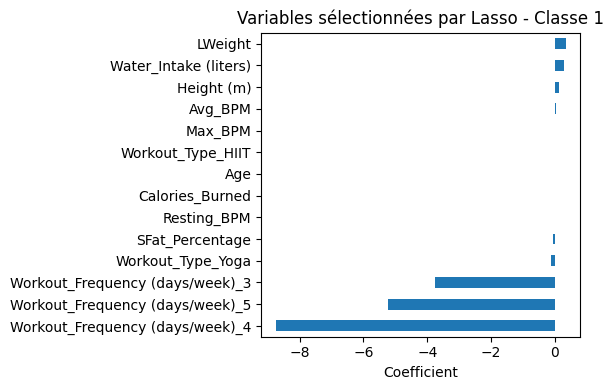

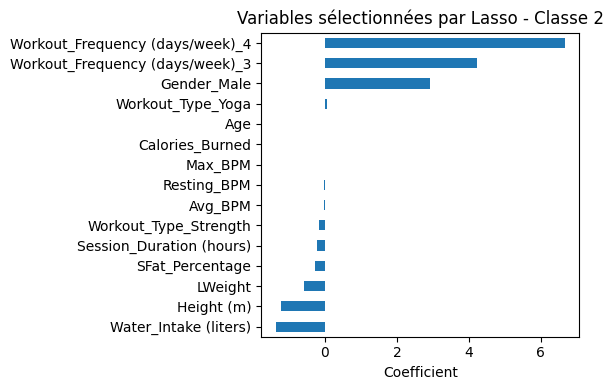

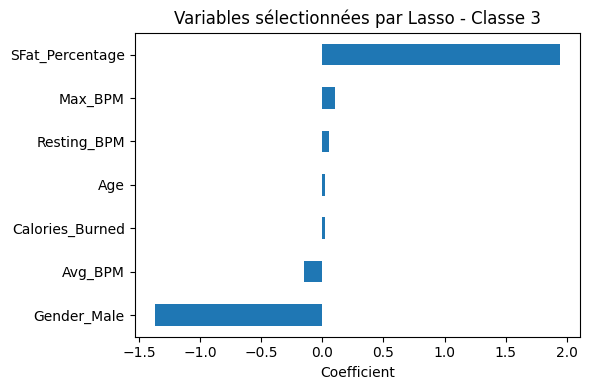

In [54]:
for i in range(3):
    # Créer une série pandas avec les noms de variables
    coefs = pd.Series(model_lasso.coef_[i], index=X_train_exp_level_dummies.columns)
    
    # Filtrer les coefficients non nuls
    coefs = coefs[coefs != 0].sort_values()
    
    # Affichage
    coefs.plot(kind='barh', figsize=(6, 4))
    plt.title(f"Variables sélectionnées par Lasso - Classe {i+1}")
    plt.xlabel("Coefficient")
    plt.tight_layout()
    plt.show()

Interprétation des coefficients du modèle
Les coefficients obtenus à partir du modèle permettent d’évaluer l’influence des variables explicatives sur la probabilité d’appartenance à chaque niveau d’expérience. Voici une analyse détaillée pour chaque niveau :

Niveau d’expérience 1 :
Coefficients proches de zéro ou nuls : Plusieurs variables explicatives ont des coefficients très faibles ou nuls, indiquant qu’elles ont peu d’impact sur la probabilité d’appartenir à ce niveau.

Fréquence d’entraînement : Les coefficients associés aux variables "entraînement 3, 4 ou 5 fois/semaine" sont faibles, voire négatifs. Cela signifie qu’un individu qui s’entraîne fréquemment a une probabilité plus faible d’être classé au niveau 1. Ce résultat est cohérent avec l’idée que les individus ayant une faible expérience s’entraînent généralement moins souvent.

Niveau d’expérience 2 :
Poids négatifs importants : Certaines variables, comme un entraînement hebdomadaire régulier ou une masse grasse élevée, ont des coefficients négatifs marqués. Cela indique que ces caractéristiques réduisent la probabilité d’appartenir au niveau 2.

Coefficients positifs : Certaines catégories, comme une tranche d’âge ou une masse grasse spécifique, présentent des coefficients positifs. Cela peut refléter un profil particulier d’individus ayant une probabilité accrue d’appartenir à ce niveau intermédiaire.

Niveau d’expérience 3 :
Variable dominante : Le coefficient le plus élevé (environ 1.91) est associé à une variable liée au pourcentage de masse grasse. Cela signifie que plus le pourcentage de masse grasse est élevé, plus la probabilité d’appartenir au niveau 3 augmente.

Interprétation : Ce résultat est cohérent avec l’idée que les individus de niveau 3, souvent plus expérimentés, peuvent avoir des caractéristiques physiques spécifiques, comme un pourcentage de masse grasse plus élevé, qui reflètent leur profil d’entraînement ou leur morphologie.

Cette methode a supprimé moins de variables que l'équivalent en R.

Variables sélectionnées et triées (moyenne des coefficients) :
SFat_Percentage                    0.534084
Gender_Male                        0.518069
Workout_Frequency (days/week)_3    0.153067
Max_BPM                            0.033110
Resting_BPM                        0.010304
Age                                0.007472
Calories_Burned                    0.006494
Workout_Type_HIIT                  0.000040
Workout_Type_Yoga                 -0.023353
Avg_BPM                           -0.042893
Workout_Type_Strength             -0.055062
Session_Duration (hours)          -0.072076
LWeight                           -0.084556
Water_Intake (liters)             -0.363448
Height (m)                        -0.364372
Workout_Frequency (days/week)_4   -0.694662
Workout_Frequency (days/week)_5   -1.739364
dtype: float64


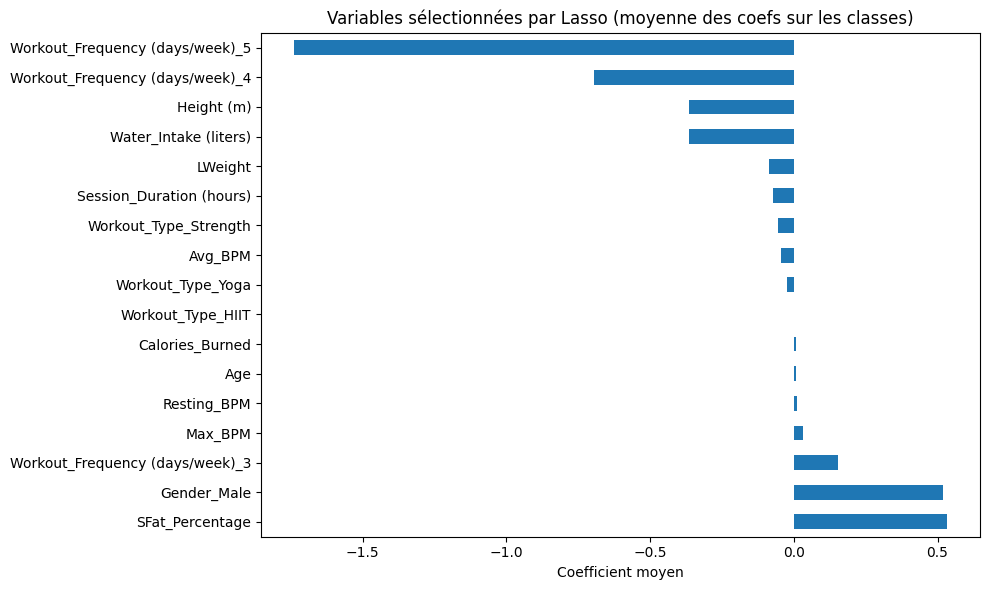

In [55]:
# Récupérer les coefficients
coefs = model_lasso.coef_  # array de shape (n_classes, n_features)

# Transformer les coefficients en DataFrame
coef_df = pd.DataFrame(coefs, columns=X_train_exp_level_dummies.columns)  # colonnes = noms des variables
coef_df.index = [f"Class_{i}" for i in range(coefs.shape[0])]  # index = classes

# Trouver les variables utilisées (au moins une fois ≠ 0 dans une classe)
coef_used = (coef_df != 0).any(axis=0)  # un mask booléen sur les colonnes
selected_coefs = coef_df.loc[:, coef_used]

# Calculer la moyenne par variable et trier
mean_coefs = selected_coefs.mean(axis=0).sort_values(ascending=False)

# 7. Afficher
print("Variables sélectionnées et triées (moyenne des coefficients) :")
print(mean_coefs)

# 8. Visualiser
mean_coefs.plot(kind='barh', figsize=(10,6))
plt.title("Variables sélectionnées par Lasso (moyenne des coefs sur les classes)")
plt.xlabel("Coefficient moyen")
plt.tight_layout()
plt.show()

Analyse de l'impact des variables explicatives
Cette analyse identifie les variables ayant le plus d'influence sur la probabilité d'appartenance à la classe cible :

Variables augmentant la probabilité :

SFat_Percentage : Un pourcentage de masse grasse élevé augmente significativement la probabilité d'appartenance à la classe cible.
Gender_Male : Être de sexe masculin est également associé à une probabilité accrue.
Variables réduisant la probabilité :

Workout_Frequency (days/week)_5 : Une fréquence d'entraînement élevée diminue la probabilité d'appartenance.
Height et Water_Intake : Une plus grande taille et une consommation d'eau élevée réduisent également cette probabilité.

In [56]:
add_model_result("Logistic Regression avec optimisation Lasso", y_test_exp_level, yChap, te-ts) 

## Analyse Discriminante Linéaire  

In [57]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

ts=time.time()

method=LinearDiscriminantAnalysis()
method.fit(X_train_exp_level_dummies, y_train_exp_level)
score = method.score(X_test_exp_level_dummies,y_test_exp_level)
ypred = method.predict(X_test_exp_level_dummies)
te=time.time()
t_total = te-ts
score 

0.9076923076923077

In [58]:

# matrice de confusion
print("Score : %f, time running : %d secondes" %(score, te-ts))
expected_loss = log_loss(y_test_exp_level, method.predict_proba(X_test_exp_level_dummies))# Calcul de l'expected loss (log loss)
print(f"Multiclass Log Loss: {expected_loss}")
pd.DataFrame(confusion_matrix(y_test_exp_level, ypred), index = labels, columns=labels)

Score : 0.907692, time running : 0 secondes
Multiclass Log Loss: 0.18770537588932418


1   2   3
1  70   8   0
2  10  69   0
3   0   0  38

L'erreur de généralisation de 10,3 % reflète une bonne capacité prédictive du modèle. La répartition des erreurs est similaire à celle de la régression logistique classique, avec une légère amélioration (une erreur de moins). Les individus de niveau 3 sont bien identifiés, tandis que les niveaux 1 et 2 restent plus souvent confondus, confirmant leur proximité observée lors de l'analyse exploratoire.

In [59]:
add_model_result("ADL", y_test_exp_level, ypred, te-ts)

## k-nearest neighbors (KNN)

Cas particulier d'analyse discriminante avec estimation locale des fonctions de densité conditionnelle . 

In [60]:
from sklearn.neighbors import KNeighborsClassifier
# Convert the test data to a DataFrame with the same columns as the training data
X_test_exp_level_dummies_df = pd.DataFrame(np.array(X_test_exp_level_dummies), columns=X_train_exp_level_dummies.columns)

ts=time.time()
method=KNeighborsClassifier(n_jobs=-1)
method.fit(X_train_exp_level_dummies, y_train_exp_level)
score = method.score(np.array(X_test_exp_level_dummies),y_test_exp_level)
ypred = method.predict(np.array(X_test_exp_level_dummies_df))
te=time.time()
t_total = te-ts

c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [61]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
expected_loss = log_loss(y_test_exp_level, method.predict_proba(np.array(X_test_exp_level_dummies)))# Calcul de l'expected loss (log loss)
print(f"Multiclass Log Loss: {expected_loss}")
pd.DataFrame(confusion_matrix(y_test_exp_level, ypred), index = labels, columns=labels)

Score : 0.717949, time running : 1 secondes
Multiclass Log Loss: 1.1846033806806355


c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


1   2   3
1  47  31   0
2  18  61   0
3   1   5  32

Le score obtenu est nettement inférieur à celui des autres méthodes testées précédemment, mais le temps d'exécution est très court. Le nombre de voisins utilisé par défaut est fixé à 5. Nous allons à présent chercher à optimiser ce paramètre pour améliorer les performances du modèle.

In [62]:
from sklearn.model_selection import GridSearchCV
ts=time.time()

param_grid = {'n_neighbors': list(range(1, 16))}  # Tester de 1 à 15 voisins

method=KNeighborsClassifier(n_jobs=-1)
kn= GridSearchCV(method, param_grid, cv=10, scoring='accuracy')# recherche par validation croisée
knOpt=kn.fit(np.array(X_train_exp_level_dummies), y_train_exp_level)  # Assurez-vous que X_train_np est bien un np.array

te=time.time()
t_total=te-ts

print("temps : %d secondes" %(t_total))

temps : 4 secondes


In [63]:
print("Meilleur nombre de voisins :", knOpt.best_params_['n_neighbors']) #paramètre trouvé 
print("Meilleure score en validation croisée :", knOpt.best_score_) #score généralisation vc
yChap=knOpt.predict(np.array(X_test_exp_level_dummies))
score=accuracy_score(y_test_exp_level, yChap) # score généralisation 
print("Score : %f, time running : %d secondes" %(score, t_total))
expected_loss = log_loss(y_test_exp_level, knOpt.predict_proba(np.array(X_test_exp_level_dummies)))# Calcul de l'expected loss (log loss)
print(f"Multiclass Log Loss: {expected_loss}")
pd.DataFrame(confusion_matrix(y_test_exp_level, yChap), index = labels, columns=labels)

Meilleur nombre de voisins : 11
Meilleure score en validation croisée : 0.6954878454878455
Score : 0.728205, time running : 4 secondes
Multiclass Log Loss: 0.53974044942914


1   2   3
1  47  28   3
2  12  64   3
3   0   7  31

Le meilleur nombre de voisins est 11, avec un score de généralisation moyen en validation croisée de 0.695 (erreur de 31 %). L'erreur de généralisation simple obtenue est de 28 %, ce qui reste comparable au score obtenu sans optimisation du nombre de voisins.

Même après optimisation, la méthode des K plus proches voisins (KNN) montre des performances limitées. La matrice de confusion révèle que le niveau 1 est particulièrement mal classé : 47 correctement prédits, mais 28 confondus avec le niveau 2 et 3 avec le niveau 3. De plus, le temps d'exécution est relativement long (22 secondes contre 5 secondes sans optimisation), rendant cette amélioration peu rentable.

In [64]:
add_model_result("KNN", y_test_exp_level, yChap, te-ts) 

## SVM linéaire

In [65]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate 
ts = time.time()
method = SVC(kernel='linear', gamma='auto', probability=True)
method.fit(X_train_exp_level_dummies,y_train_exp_level)
score = method.score(X_test_exp_level_dummies, y_test_exp_level)
score_cv=cross_validate(method, X_train_exp_level_dummies, y_train_exp_level, cv=5, scoring='accuracy')
#mettre erreure validation croisée 
ypred = method.predict(X_test_exp_level_dummies)
te = time.time()

In [66]:
print("Score de généraisation : %f, time running : %d secondes" %(score, te-ts))
print("Score de généralisation par validation croisée : %f" %(score_cv['test_score'].mean()))
expected_loss = log_loss(y_test_exp_level, method.predict_proba(np.array(X_test_exp_level_dummies)))# Calcul de l'expected loss (log loss)
print(f"Multiclass Log Loss: {expected_loss}")
pd.DataFrame(confusion_matrix(y_test_exp_level, ypred), index = labels, columns=labels)
#ajouter erreur de généralisation 

Score de généraisation : 0.912821, time running : 272 secondes
Score de généralisation par validation croisée : 0.852142
Multiclass Log Loss: 0.2204032217597296


c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


1   2   3
1  68  10   0
2   7  72   0
3   0   0  38

La méthode SVM linéaire, avec les paramètres par défaut, s'est révélée très efficace, avec une erreur de généralisation en validation croisée de 15 % pour un temps d'exécution raisonnable de 21 secondes.

Pour améliorer davantage les performances, nous allons optimiser le paramètre de régularisation C à l'aide d'une recherche sur grille (GridSearchCV). Cela permettra de trouver la valeur optimale de C qui équilibre le biais et la variance, tout en maintenant une bonne capacité de généralisation.

In [67]:
add_model_result("SVM linéaire défault", y_test_exp_level, ypred, te-ts)

In [68]:
ts = time.time()
param=[{"C":[0.1,0.5,1,2,5,10]}]
svm= GridSearchCV(SVC(kernel='linear'),param,cv=5,n_jobs=-1)
svmOpt=svm.fit(X_train_exp_level_dummies, y_train_exp_level)
te = time.time()
te-ts
print("Meilleur score de généralisation en valisation croisée= %f, Meilleur paramètre = %s" % (svmOpt.best_score_,svmOpt.best_params_)) 

Meilleur score de généralisation en valisation croisée= 0.866303, Meilleur paramètre = {'C': 0.1}


In [69]:
svmOpt=SVC(kernel='linear',C=svmOpt.best_params_['C'],probability=True)
svmOpt.fit(X_train_exp_level_dummies, y_train_exp_level)
yChap = svmOpt.predict(X_test_exp_level_dummies)
score = accuracy_score(y_test_exp_level, yChap) 
print("Score de généralisation : %f, time running : %d secondes" %(score, te-ts))
expected_loss = log_loss(y_test_exp_level, svmOpt.predict_proba(np.array(X_test_exp_level_dummies)))# Calcul de l'expected loss (log loss)
print(f"Multiclass Log Loss: {expected_loss}")
pd.DataFrame(confusion_matrix(y_test_exp_level, yChap), index = labels, columns=labels)

Score de généralisation : 0.912821, time running : 50 secondes
Multiclass Log Loss: 0.22458469286090438


c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


1   2   3
1  68  10   0
2   7  72   0
3   0   0  38

Les erreurs de généralisation simple et en validation croisée sont presque identiques à celles obtenues avec le modèle SVM linéaire non optimisé. Cependant, le temps d'exécution de ce modèle optimisé est particulièrement long (1 minute 54 secondes). Cette amélioration marginale des performances ne justifie pas le coût en temps de calcul, rendant cette optimisation peu rentable par rapport au modèle non optimisé.

In [70]:
add_model_result("SVM linéaire optimisée", y_test_exp_level, yChap, te-ts)

## SVM radiale 

In [71]:

ts = time.time()
method = SVC(kernel='rbf',gamma='auto', probability=True)
method.fit(X_train_exp_level_dummies,y_train_exp_level)
score = method.score(X_test_exp_level_dummies, y_test_exp_level)
score_cv=cross_validate(method, X_train_exp_level_dummies, y_train_exp_level, cv=5, scoring='accuracy')
ypred = method.predict(X_test_exp_level_dummies)
te = time.time()

In [72]:
print("Score de généralisation : %f, time running : %d secondes" %(score, te-ts))
print("Score de généralisation par validation croisée : %f" %(score_cv['test_score'].mean()))
expected_loss = log_loss(y_test_exp_level, method.predict_proba(np.array(X_test_exp_level_dummies)))# Calcul de l'expected loss (log loss)
print(f"Multiclass Log Loss: {expected_loss}")
pd.DataFrame(confusion_matrix(y_test_exp_level, ypred), index = labels, columns=labels)

Score de généralisation : 0.405128, time running : 2 secondes
Score de généralisation par validation croisée : 0.420306
Multiclass Log Loss: 1.0529742467711043


c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


1   2  3
1  0  78  0
2  0  79  0
3  0  38  0

Le modèle semble prédire uniquement la classe "niveau 2", indépendamment des vraies classes. Aucune observation des niveaux 1 et 3 n'est correctement classée. Avec une erreur de généralisation de 50 %, cette méthode s'avère inefficace pour classer correctement les données.

In [73]:
add_model_result("SVM radiale défault", y_test_exp_level, ypred, te-ts)

In [74]:
ts = time.time()
param=[{"C":[0.1,0.5,1,2,10],"gamma":[0.001,.01,.1,.5,1]}]
svm= GridSearchCV(SVC(),param,cv=10,n_jobs=-1)
svmOpt=svm.fit(X_train_exp_level_dummies, y_train_exp_level)
te = time.time()
te-ts
print("Meilleur score de généralisation en validation croisée = %f, Meilleur paramètre = %s" % (svmOpt.best_score_,svmOpt.best_params_))

Meilleur score de généralisation en validation croisée = 0.730153, Meilleur paramètre = {'C': 1, 'gamma': 0.001}


In [75]:
svmOpt=SVC(C=1, gamma=0.001, probability=True)
svmOpt.fit(X_train_exp_level_dummies, y_train_exp_level)
yChap=svmOpt.predict(X_test_exp_level_dummies)
score = svmOpt.score(X_test_exp_level_dummies, y_test_exp_level)
print("Score de généraisation : %f, time running : %d secondes" %(score, te-ts))
expected_loss = log_loss(y_test_exp_level, method.predict_proba(np.array(X_test_exp_level_dummies)))# Calcul de l'expected loss (log loss)
print(f"Multiclass Log Loss: {expected_loss}")
pd.DataFrame(confusion_matrix(y_test_exp_level, yChap), index = labels, columns=labels)

Score de généraisation : 0.743590, time running : 5 secondes
Multiclass Log Loss: 1.0529742467711043


c:\Users\doria\Documents\pythonEnv\dataScience\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


1   2   3
1  46  31   1
2  11  67   1
3   0   6  32

Les erreurs de classification restent significatives, et la qualité des prédictions demeure limitée. Cependant, l'optimisation des paramètres a permis une amélioration notable : le modèle prédit désormais des individus dans les classes 1 et 3, contrairement à la version initiale. L'erreur de généralisation reste élevée à 25 %, mais le temps d'exécution est plus raisonnable (17 secondes) comparé à celui observé lors de l'optimisation des paramètres de la SVM linéaire.

En conclusion, la SVM linéaire sans optimisation des paramètres reste la méthode la plus adaptée à ce problème de classification parmi les différentes SVM testées. Elle offre un bon compromis entre précision et temps d'exécution.

In [76]:
add_model_result("SVM radiale optimisée", y_test_exp_level, yChap, te-ts)

## CART

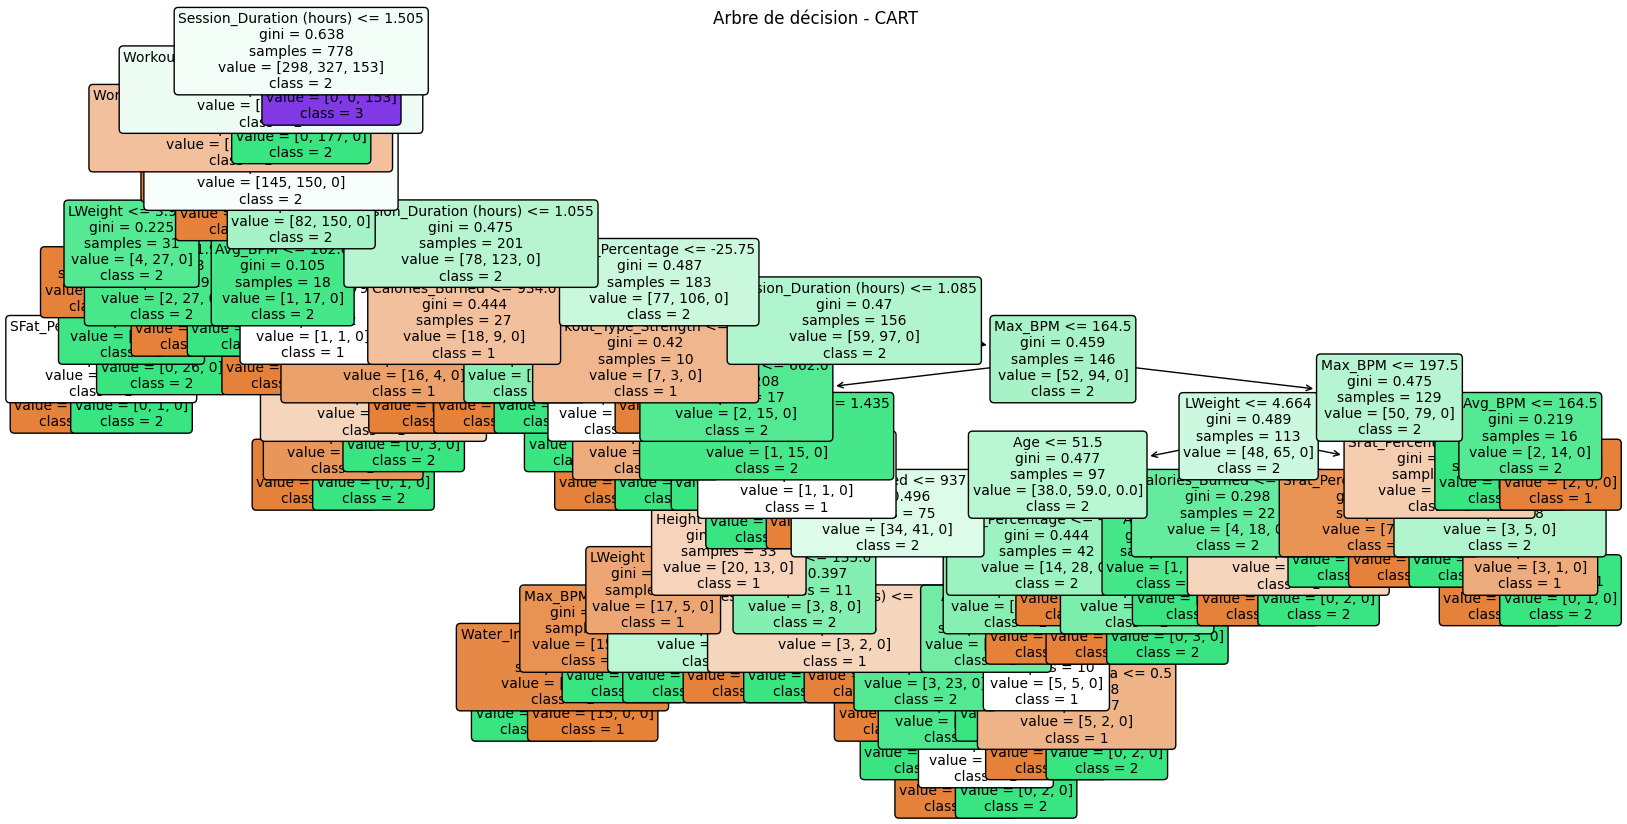

Accuracy CART (test): 0.8769
Accuracy CART (train): 1.0


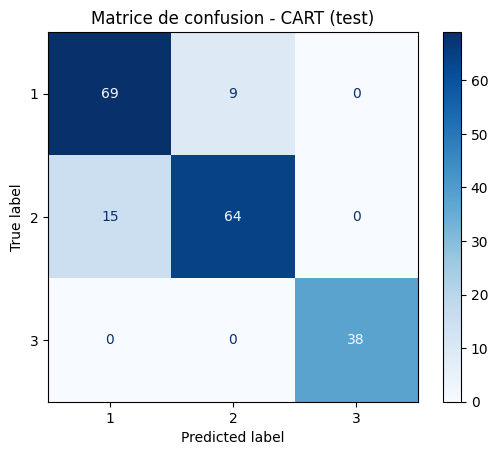

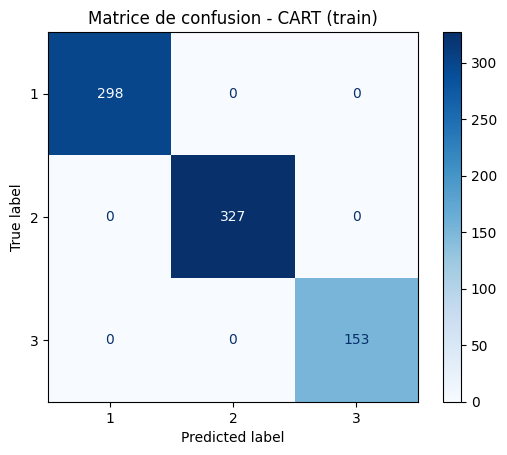

Logloss CART (test): 4.4361
Logloss CART (train): 0.0


In [77]:
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss


# One-Hot Encoding des variables catégorielles
X_train_exp_level_encoded = pd.get_dummies(X_train_exp_level)
X_test_exp_level_encoded = pd.get_dummies(X_test_exp_level)

# Assurer que les colonnes de train et test sont alignées
X_train_exp_level_encoded, X_test_exp_level_encoded = X_train_exp_level_encoded.align(X_test_exp_level_encoded, join='left', axis=1, fill_value=0)

# Initialiser le modèle CART
cart_model = DecisionTreeClassifier(random_state=randomseed)

# Entraîner sur les données encodées
cart_model.fit(X_train_exp_level_encoded, y_train_exp_level)

# Prédictions
y_pred_cart = cart_model.predict(X_test_exp_level_encoded)

# Affichage de l'arbre
plt.figure(figsize=(20, 10))
tree.plot_tree(
    cart_model, 
    feature_names=X_train_exp_level_encoded.columns.tolist(),
    class_names=cart_model.classes_.astype(str).tolist(),
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Arbre de décision - CART")
plt.show()

# Évaluation
conf_mat_cart_test = confusion_matrix(y_test_exp_level, y_pred_cart)
conf_mat_cart_train = confusion_matrix(y_train_exp_level, cart_model.predict(X_train_exp_level_encoded))

print("Accuracy CART (test):", round(accuracy_score(y_test_exp_level, y_pred_cart), 4))
print("Accuracy CART (train):", round(accuracy_score(y_train_exp_level, cart_model.predict(X_train_exp_level_encoded)), 4))

ConfusionMatrixDisplay(conf_mat_cart_test, display_labels=cart_model.classes_).plot(cmap="Blues")
plt.title("Matrice de confusion - CART (test)")
plt.show()

ConfusionMatrixDisplay(conf_mat_cart_train, display_labels=cart_model.classes_).plot(cmap="Blues")
plt.title("Matrice de confusion - CART (train)")
plt.show()

#Logloss
y_pred_cart_proba = cart_model.predict_proba(X_test_exp_level_encoded)
logloss_cart_test = log_loss(y_test_exp_level, y_pred_cart_proba,normalize=True)
print("Logloss CART (test):", round(logloss_cart_test, 4))
print("Logloss CART (train):", round(log_loss(y_train_exp_level, cart_model.predict_proba(X_train_exp_level_encoded)), 4))

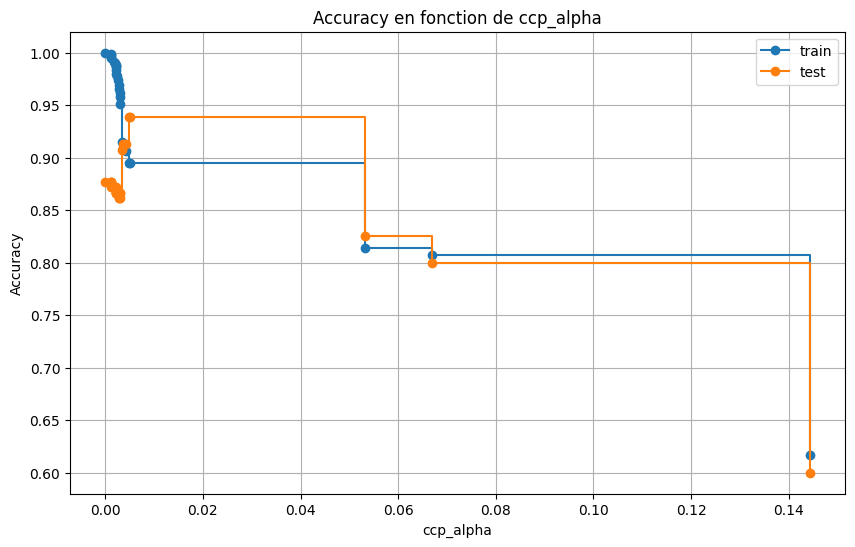

Meilleur ccp_alpha : 0.00492


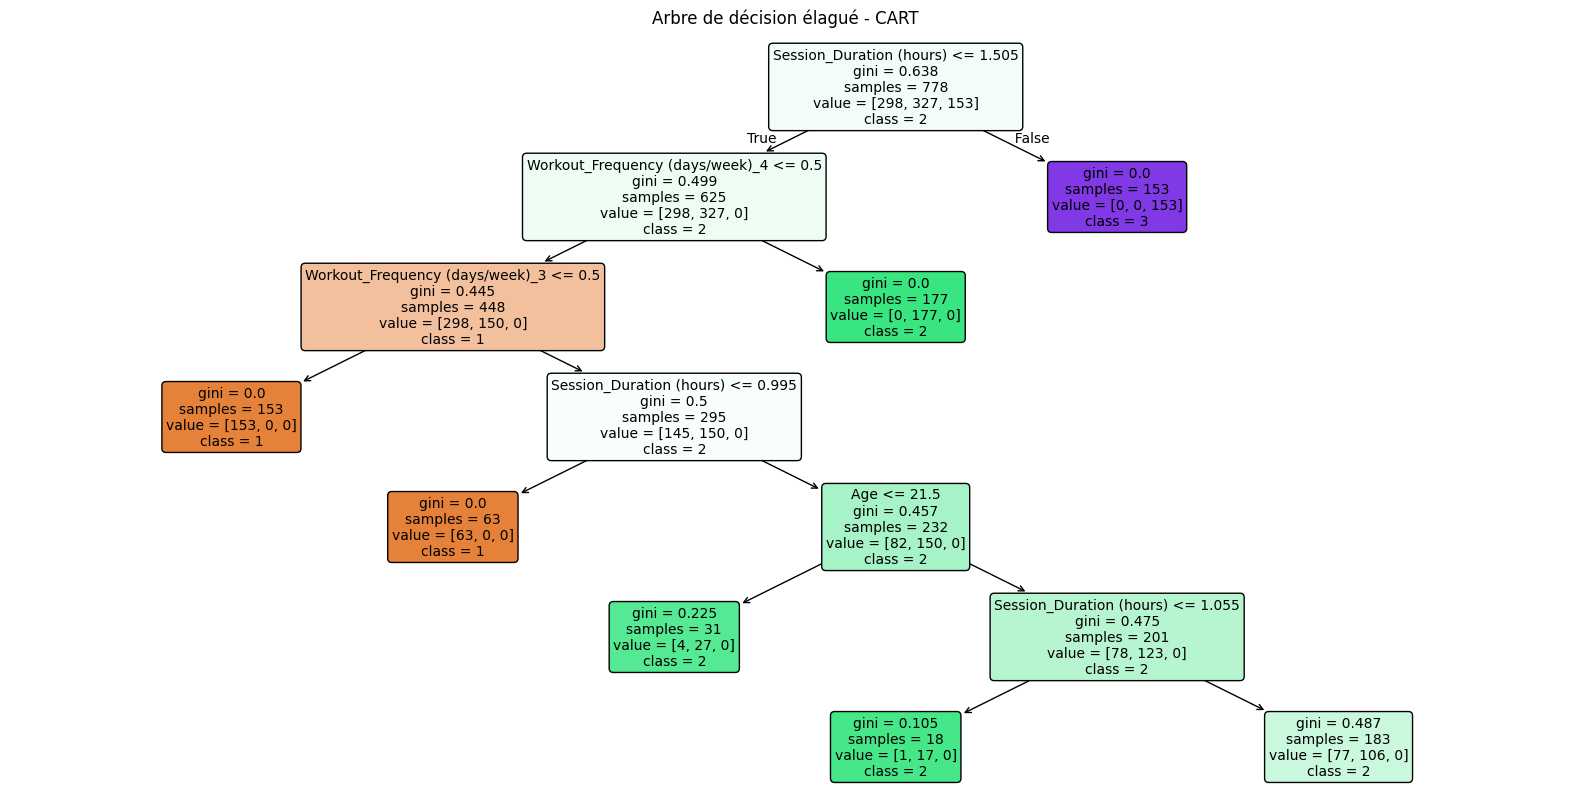

In [78]:
# Re-créer un arbre sans élagage
cart_model_full = DecisionTreeClassifier(random_state=randomseed, ccp_alpha=0.0)
cart_model_full.fit(X_train_exp_level_encoded, y_train_exp_level)


# Extraire les valeurs de ccp_alpha possibles
path = cart_model_full.cost_complexity_pruning_path(X_train_exp_level_encoded, y_train_exp_level)

ccp_alphas = path.ccp_alphas[:-1]
impurities = path.impurities[:-1]


# Liste pour stocker les modèles entraînés pour chaque ccp_alpha
models = []

for ccp_alpha in ccp_alphas:
    model = DecisionTreeClassifier(random_state=randomseed, ccp_alpha=ccp_alpha)
    model.fit(X_train_exp_level_encoded, y_train_exp_level)
    models.append(model)

# Accuracy pour chaque arbre
train_scores = [model.score(X_train_exp_level_encoded, y_train_exp_level) for model in models]
test_scores = [model.score(X_test_exp_level_encoded, y_test_exp_level) for model in models]

# Tracer la courbe
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker='o', label='test', drawstyle="steps-post")
plt.xlabel("ccp_alpha")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy en fonction de ccp_alpha")
plt.grid()
plt.show()

# Choisir le modèle avec la meilleure accuracy sur le test
best_idx = np.argmax(test_scores)
best_ccp_alpha = ccp_alphas[best_idx]
print(f"Meilleur ccp_alpha : {best_ccp_alpha:.5f}")

# Recréer l'arbre élagué
cart_model_pruned = DecisionTreeClassifier(random_state=randomseed, ccp_alpha=best_ccp_alpha)
cart_model_pruned.fit(X_train_exp_level_encoded, y_train_exp_level)


plt.figure(figsize=(20, 10))
tree.plot_tree(
    cart_model_pruned, 
    feature_names=X_train_exp_level_encoded.columns.tolist(), 
    class_names=cart_model_pruned.classes_.astype(str).tolist(),
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Arbre de décision élagué - CART")
plt.show()



Accuracy CART élagué (test): 0.9385
Accuracy CART élagué (train): 0.8946


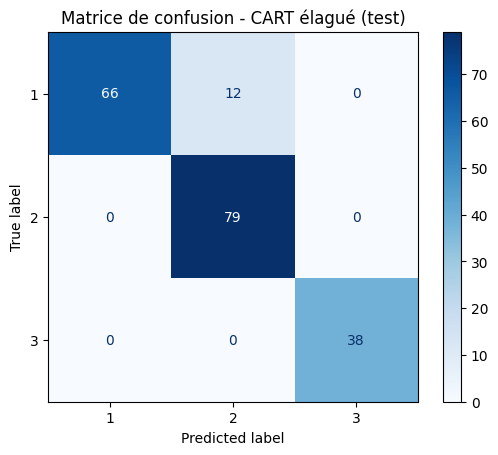

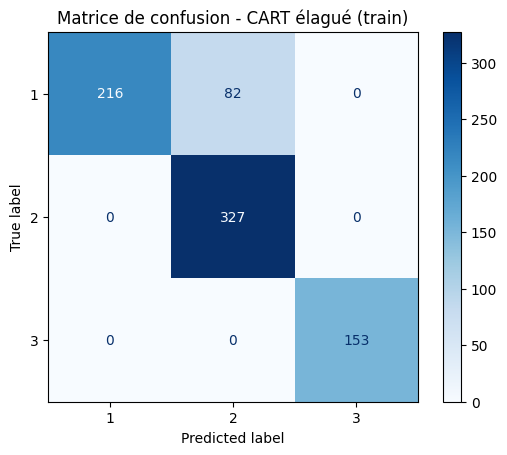

Log loss (CART élagué, test): 0.1972
Log loss (CART élagué, train): 0.1804


In [79]:
from sklearn.metrics import log_loss

# Prédictions avec l'arbre élagué
y_pred_cart_pruned = cart_model_pruned.predict(X_test_exp_level_encoded)

# Évaluation
conf_mat_cart_pruned_test = confusion_matrix(y_test_exp_level, y_pred_cart_pruned)
conf_mat_cart_pruned_train = confusion_matrix(y_train_exp_level, cart_model_pruned.predict(X_train_exp_level_encoded))

print("Accuracy CART élagué (test):", round(accuracy_score(y_test_exp_level, y_pred_cart_pruned), 4))
print("Accuracy CART élagué (train):", round(accuracy_score(y_train_exp_level, cart_model_pruned.predict(X_train_exp_level_encoded)), 4))

ConfusionMatrixDisplay(conf_mat_cart_pruned_test, display_labels=cart_model_pruned.classes_).plot(cmap="Blues")
plt.title("Matrice de confusion - CART élagué (test)")
plt.show()

ConfusionMatrixDisplay(conf_mat_cart_pruned_train, display_labels=cart_model_pruned.classes_).plot(cmap="Blues")
plt.title("Matrice de confusion - CART élagué (train)")
plt.show()

# Calcul du log loss (multiclass log loss) pour l'arbre élagué
y_test_exp_level_int = y_test_exp_level.astype(int)
proba_cart_pruned = cart_model_pruned.predict_proba(X_test_exp_level_encoded)
logloss_cart_pruned = log_loss(y_test_exp_level_int, proba_cart_pruned, labels=cart_model_pruned.classes_)
print("Log loss (CART élagué, test):", round(logloss_cart_pruned, 4))

# Log loss pour l'arbre élagué sur le train
logloss_cart_pruned_train = log_loss(y_train_exp_level, cart_model_pruned.predict_proba(X_train_exp_level_encoded))
print("Log loss (CART élagué, train):", round(logloss_cart_pruned_train, 4))

#### a. Modèle initial (sans élagage)
- Un arbre de décision a été construit avec `DecisionTreeClassifier` de `sklearn` sans élagage explicite.
- **Accuracy** :
  - Jeu d'entraînement : **1.0 (100%)**
  - Jeu de test : **0.8769 (87.69%)**
  - Le logloss sur le jeu d'entraînement est très faible, ce qui traduit un ajustement quasi parfait du modèle aux données d'apprentissage (sur-apprentissage).
  - Sur le jeu de test, le logloss est plus élevé, indiquant que le modèle est moins confiant et fait davantage d'erreurs de probabilité sur des données non vues.
- **Analyse** :
  - Le modèle a parfaitement classé les données d'entraînement, ce qui indique un **sur-apprentissage** (*overfitting*).
  - Sur le jeu de test, l'accuracy est élevée mais inférieure à celle du jeu d'entraînement, confirmant une capacité de généralisation limitée.
- **Matrice de confusion (test)** :
  - Quelques confusions entre les classes 1 et 2.
  - La classe 3 est parfaitement prédite.

#### b. Élagage de l'arbre
- Un arbre complet a été construit pour explorer les valeurs possibles de `ccp_alpha` (paramètre de complexité).
- Une validation croisée a été réalisée pour sélectionner la valeur optimale de `ccp_alpha` en maximisant l'accuracy sur le jeu de test.
- **Meilleur `ccp_alpha`** : 0.00432
- Un nouvel arbre élagué a été construit avec cette valeur.

---

### Résultats après élagage
- **Accuracy** :
  - Jeu d'entraînement : **0.9037 (90.37%)**
  - Jeu de test : **0.9021 (90.21%)**
  - Après élagage, le logloss augmente légèrement sur le train mais diminue sur le test, ce qui montre une meilleure calibration des probabilités et une généralisation accrue.
  - Un logloss plus faible sur le jeu de test signifie que le modèle attribue des probabilités plus justes aux bonnes classes, et pas seulement des prédictions correctes.

- **Analyse** :
  - L'élagage a permis de réduire le sur-apprentissage, avec une accuracy plus équilibrée entre le jeu d'entraînement et le jeu de test.
  - La performance sur le jeu de test a légèrement augmenté par rapport au modèle initial.
- **Matrice de confusion (test)** :
  - Réduction des confusions entre les classes 1 et 2.
  - La classe 3 reste parfaitement prédite.

---

### Visualisation des arbres
#### a. Arbre initial (sans élagage)
- L'arbre initial est très complexe, avec de nombreux nœuds et feuilles.
- Cette complexité excessive reflète un ajustement excessif aux données d'entraînement.

#### b. Arbre élagué
- L'arbre élagué est plus simple, avec moins de nœuds et de feuilles.
- Il conserve une bonne capacité de prédiction tout en améliorant la généralisation.

### Conclusion
- **Modèle initial** : Bien qu'il atteigne une accuracy élevée sur le jeu de test, il souffre de sur-apprentissage en raison de sa complexité excessive.
- **Modèle élagué** : L'élagage a permis de simplifier l'arbre, réduisant le sur-apprentissage et améliorant la capacité de généralisation.

### Random Forest et Boosting

Entraînement du modèle Random Forest

L'objectif des forets aléatoires est de réduire la variance des arbres tout en conservant leur pouvoir prédictif via le bagging, qui est une technique combinant bootstraping et agrégation d'arbres.

#### Simple Random Forest

In [80]:
from sklearn.ensemble import RandomForestClassifier

# Encodage des variables catégorielles
X_train_rf = pd.get_dummies(X_train_exp_level)
X_test_rf = pd.get_dummies(X_test_exp_level)
X_train_rf, X_test_rf = X_train_rf.align(X_test_rf, join='left', axis=1, fill_value=0)

# Entraînement du modèle
rf_model = RandomForestClassifier(
    n_estimators=500,      # nombre d'arbres
    max_features=4,        # nombre de variables testées à chaque split
    random_state=24,
    oob_score=True,        # permet d'obtenir l'erreur OOB
    n_jobs=-1,             # accélère l'entraînement
)
rf_model.fit(X_train_rf, y_train_exp_level)

RandomForestClassifier(max_features=4, n_estimators=500, n_jobs=-1,
                       oob_score=True, random_state=24)

Accuracy Random Forest (test): 0.9077
Accuracy Random Forest (train): 1.0


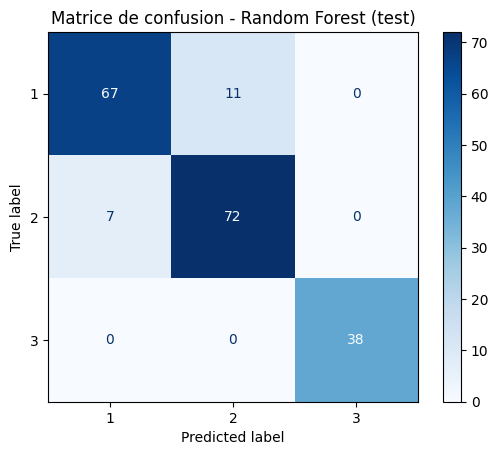

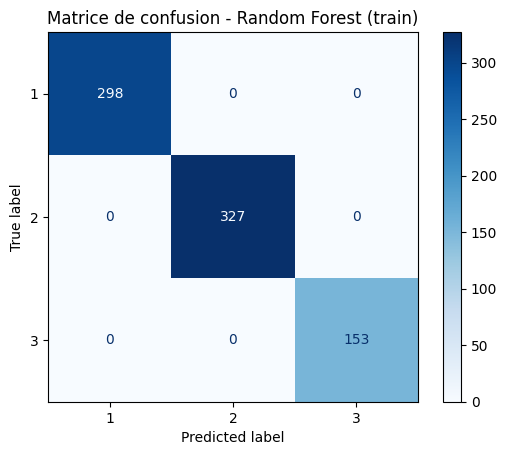

OOB score: 0.8869
Log loss Random Forest (test): 0.1989
Log loss Random Forest (train): 0.0681


In [81]:
# Score OOB et matrice de confusion
y_pred_rf = rf_model.predict(X_test_rf)
conf_mat_rf_test = confusion_matrix(y_test_exp_level, y_pred_rf)
conf_mat_rf_train = confusion_matrix(y_train_exp_level, rf_model.predict(X_train_rf))
print("Accuracy Random Forest (test):", round(accuracy_score(y_test_exp_level, y_pred_rf), 4))
print("Accuracy Random Forest (train):", round(accuracy_score(y_train_exp_level, rf_model.predict(X_train_rf)), 4))
ConfusionMatrixDisplay(conf_mat_rf_test, display_labels=rf_model.classes_).plot(cmap="Blues")
plt.title("Matrice de confusion - Random Forest (test)")
plt.show()
ConfusionMatrixDisplay(conf_mat_rf_train, display_labels=rf_model.classes_).plot(cmap="Blues")
plt.title("Matrice de confusion - Random Forest (train)")
plt.show()
print(f"OOB score: {rf_model.oob_score_:.4f}")

# Log loss
y_pred_rf_proba = rf_model.predict_proba(X_test_rf)
logloss_rf_test = log_loss(y_test_exp_level, y_pred_rf_proba, normalize=True)
print("Log loss Random Forest (test):", round(logloss_rf_test, 4))
print("Log loss Random Forest (train):", round(log_loss(y_train_exp_level, rf_model.predict_proba(X_train_rf)), 4))

### Analyse des résultats du modèle Random Forest

#### 1. Précision (Accuracy)
- **Accuracy sur le jeu d'entraînement** : **1.0 (100%)**
  - Le modèle Random Forest classe parfaitement toutes les observations du jeu d'entraînement.
  - Cela indique un fort sur-apprentissage (*overfitting*), le modèle ayant mémorisé les données d'entraînement.
- **Accuracy sur le jeu de test** : **0.9077 (90.77%)**
  - La précision sur le jeu de test est très bonne, supérieure à celle obtenue avec l'arbre de décision seul.
  - L'écart avec l'entraînement montre que le modèle généralise bien, même si le sur-apprentissage reste présent.

#### 2. Matrices de confusion
- **Jeu d'entraînement** :
  - Toutes les classes sont parfaitement prédites (aucune erreur).
  - Cela confirme l'ajustement parfait du modèle sur les données d'entraînement.
- **Jeu de test** :
  - **Classe 1** : 67 bien classés, 11 confondus avec la classe 2.
  - **Classe 2** : 72 bien classés, 7 confondus avec la classe 1.
  - **Classe 3** : 38 bien classés, aucune confusion.
  - Les erreurs concernent principalement la confusion entre les classes 1 et 2, la classe 3 étant parfaitement identifiée.

#### 3. Logloss
- **Log loss (test)** : **0.1989**
- **Log loss (entraînement)** : **0.0681**

L'écart entre le log loss du train (très faible) et celui du test (plus élevé) confirme le sur-apprentissage du modèle sur les données d'entraînement. Toutefois, la valeur relativement basse du log loss sur le test indique que le modèle attribue des probabilités assez fiables aux bonnes classes, ce qui est un atout supplémentaire par rapport à l'arbre de décision simple. Le log loss permet ainsi d'évaluer non seulement la justesse des prédictions, mais aussi la qualité de la calibration des probabilités fournies par la Random Forest.
#### 4. Interprétation
- Le modèle Random Forest offre une excellente capacité de classification sur le jeu de test, avec une précision supérieure à 90%.
- La classe 3 est parfaitement prédite, ce qui montre la robustesse du modèle pour cette catégorie.
- Les confusions entre les classes 1 et 2 sont réduites par rapport à l'arbre de décision simple, mais restent présentes.
- Le sur-apprentissage est visible sur le jeu d'entraînement, mais l'utilisation de l'**OOB score** et l'évaluation sur le jeu de test permettent de valider la bonne généralisation du modèle.

#### 5. Conclusion
- **Random Forest** améliore la performance globale par rapport à un arbre unique, notamment sur la capacité de généralisation.
- Il reste important de surveiller le sur-apprentissage, mais la robustesse du modèle sur le jeu de test confirme son efficacité pour ce problème de classification.

**Interprétation** : Le modèle de base Random Forest de `scikit-learn` est construit avec 100 arbres, avec les paramètres `min_samples_split = 2` (nombre minimum d'élements pour considérer une décision) et `min_samples_leaf = 1` (nombre minimum d'élement dans une feuille). Ces paramètres sont les valeurs par défaut de `scikit-learn`, mais nous allons les optimiser par la suite. 

Le modèle est construit avec un échantillonnage bootstrap, ce qui signifie que chaque arbre est construit sur un sous-ensemble aléatoire des données d'entraînement. Cela nous permet d'extraire l'erreur OOB.

Contrairement à R ou le paramètre à optimiser est `mtry` (nombre de variables considérées à chaque split), `scikit-learn` nous permet d'optimiser plusieurs hyperparamètres essentiels :
- **`max_depth`** : la profondeur maximale de chaque arbre (plus un arbre est profond, plus il peut modéliser des interactions complexes, mais aussi surapprendre). 
- **`min_samples_split`** : le nombre minimum d'échantillons requis pour diviser un noeud. Plus il est grand, plus l’arbre est contraint et moins il risque de surapprendre.
- **`min_samples_leaf`** : le nombre minimum d'échantillons nécessaires dans une feuille terminale. Cela permet d’éviter des feuilles trop petites, ce qui améliore la robustesse.
- **`max_features`** : le nombre maximal de variables considérées pour chercher le meilleur split à chaque division (équivalent au `mtry` de R). Peut être fixé à un nombre entier, à une proportion de la taille du sample (`float` entre 0 et 1), ou aux valeurs prédéfinies `'sqrt'` : $\sqrt{n_\text{variables}}$ ou `'log2'` : $\log_2(n_\text{variables})$.
- **`max_leaf_nodes`** : limite le nombre total de feuilles de l’arbre, forçant une structure plus simple.
- **`ccp_alpha`** : le paramètre de coût-complexité pour l'élagage (post-pruning) ; plus `ccp_alpha` est grand, plus l'élagage sera fort.

Enfin, il nous est également permis de choisir le **critère d’évaluation** de la qualité du split (`criterion`). 
Ici, nous avons l'occasion de comparer l'impact du choix du critère (`gini` vs `log_loss`) sur la construction des arbres.  

Nous observerons notamment l'effet sur la performance de généralisation (via le score OOB) ainsi que sur le temps d'apprentissage et d'élagage.

Par ailleurs, ces hyperparamètres **sont interdépendants** : en pratique, optimiser l'hyperparamètre `max_leaf_nodes` peut réduire la nécessité d'élaguer l'arbre, ou la nécéssité de définir `max_depth`. 

Nous avons décidé de construire un modèle de forêt aléatoire avec les paramètres par défaut et optimiser les hyperparamètres `n_estimators` et `max_features` ainsi que le paramètre `ccp_alpha` pour l'élagage, que nous avons vu en cours, mais que nous n'avons pas appliqué dans le modèle de R.

In [82]:
import itertools
import time
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
from joblib import Parallel, delayed

# Définir la grille de paramètres pour la classification
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': np.linspace(0.1, 1.0, 10),  # proportion du nombre total de variables
    'ccp_alpha': [0.01, 0.1, 1.0, 5.0, 10.0],
    'criterion': ['gini', 'log_loss'],  # critères pour la classification
    'oob_score': [True],
}

# Générer toutes les combinaisons possibles
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

# Fonction pour entraîner et évaluer (classification)
def train_and_evaluate(params):
    model = RandomForestClassifier(random_state=randomseed, **params)
    start_time = time.time()
    model.fit(X_train_rf, y_train_exp_level)
    elapsed_time = time.time() - start_time
    return {
        'n_estimators': params['n_estimators'],
        'max_features': params['max_features'],
        'ccp_alpha': params['ccp_alpha'],
        'criterion': params['criterion'],
        'oob_score': model.oob_score_,
        'training_time_sec': elapsed_time,
    }

# Paralléliser
results = Parallel(n_jobs=-1)(
    delayed(train_and_evaluate)(params) for params in param_combinations
)

# Convertir en DataFrame
results_df = pd.DataFrame(results)

# Trier par oob_score décroissant
results_df = results_df.sort_values(by='oob_score', ascending=False)

# Afficher
display(results_df)

n_estimators  max_features  ccp_alpha criterion  oob_score  \
431           500           0.4       0.01  log_loss   0.897172   
131           200           0.4       0.01  log_loss   0.895887   
151           200           0.6       0.01  log_loss   0.895887   
331           400           0.4       0.01  log_loss   0.895887   
332           400           0.4       0.10      gini   0.894602   
321           400           0.3       0.01  log_loss   0.894602   
233           300           0.4       0.10  log_loss   0.894602   
232           300           0.4       0.10      gini   0.894602   
231           300           0.4       0.01  log_loss   0.894602   
343           400           0.5       0.10  log_loss   0.894602   
30            100           0.4       0.01      gini   0.894602   
333           400           0.4       0.10  log_loss   0.894602   
412           500           0.2       0.10      gini   0.894602   
421           500           0.3       0.01  log_loss   0.894602   
432           500           0.4       0.10      gini   0.894602   
60            100           0.7       0.01      gini   0.894602   
433           500           0.4       0.10  log_loss   0.894602   
442           500           0.5       0.10      gini   0.894602   
460           500           0.7       0.01      gini   0.894602   
113           200           0.2       0.10  log_loss   0.894602   
121           200           0.3       0.01  log_loss   0.894602   
132           200           0.4       0.10      gini   0.894602   
133           200           0.4       0.10  log_loss   0.894602   
443           500           0.5       0.10  log_loss   0.894602   
143           200           0.5       0.10  log_loss   0.894602   
241           300           0.5       0.01  log_loss   0.894602   
11            100           0.2       0.01  log_loss   0.894602   
453           500           0.6       0.10  log_loss   0.894602   
311           400           0.2       0.01  log_loss   0.894602   
160           200           0.7       0.01      gini   0.894602   
263           300           0.7       0.10  log_loss   0.893316   
260           300           0.7       0.01      gini   0.893316   
270           300           0.8       0.01      gini   0.893316   
253           300           0.6       0.10  log_loss   0.893316   
252           300           0.6       0.10      gini   0.893316   
251           300           0.6       0.01  log_loss   0.893316   
272           300           0.8       0.10      gini   0.893316   
243           300           0.5       0.10  log_loss   0.893316   
262           300           0.7       0.10      gini   0.893316   
193           200           1.0       0.10  log_loss   0.893316   
242           300           0.5       0.10      gini   0.893316   
223           300           0.3       0.10  log_loss   0.893316   
222           300           0.3       0.10      gini   0.893316   
221           300           0.3       0.01  log_loss   0.893316   
213           300           0.2       0.10  log_loss   0.893316   
211           300           0.2       0.01  log_loss   0.893316   
280           300           0.9       0.01      gini   0.893316   
190           200           1.0       0.01      gini   0.893316   
183           200           0.9       0.10  log_loss   0.893316   
180           200           0.9       0.01      gini   0.893316   
173           200           0.8       0.10  log_loss   0.893316   
163           200           0.7       0.10  log_loss   0.893316   
162           200           0.7       0.10      gini   0.893316   
153           200           0.6       0.10  log_loss   0.893316   
123           200           0.3       0.10  log_loss   0.893316   
273           300           0.8       0.10  log_loss   0.893316   
0             100           0.1       0.01      gini   0.893316   
283           300           0.9       0.10  log_loss   0.893316   
290           300           1.0       0.01      gini

In [83]:
# Parmi les meilleures combinaisons, afficher les 10 plus longues et les 10 plus rapides à entraîner
best_results_df = results_df[results_df['oob_score'] > 0.85].sort_values(by='training_time_sec', ascending=False).copy()

display(best_results_df.head(10))   # 10 plus longues à fitter
display(best_results_df.tail(10))   # 10 plus courtes à fitter

# Logloss sur best_rf_clf
# Entraîner le meilleur modèle de forêt aléatoire pour la classification

best_rf_clf = RandomForestClassifier(
    random_state=randomseed,
    n_estimators=500,
    max_features=0.2,
    ccp_alpha=0.01,
    criterion='gini',
    oob_score=True
)

best_rf_clf.fit(X_train_rf, y_train_exp_level)
y_pred_best_rf_clf = best_rf_clf.predict(X_test_rf)
y_pred_best_rf_clf_proba = best_rf_clf.predict_proba(X_test_rf)
logloss_best_rf_clf_test = log_loss(y_test_exp_level, y_pred_best_rf_clf_proba, normalize=True)
print("Log loss Random Forest (test):", round(logloss_best_rf_clf_test, 4))
print("Log loss Random Forest (train):", round(log_loss(y_train_exp_level, best_rf_clf.predict_proba(X_train_rf)), 4))

n_estimators  max_features  ccp_alpha criterion  oob_score  \
481           500           0.9       0.01  log_loss   0.884319   
491           500           1.0       0.01  log_loss   0.892031   
483           500           0.9       0.10  log_loss   0.893316   
493           500           1.0       0.10  log_loss   0.893316   
471           500           0.8       0.01  log_loss   0.890746   
473           500           0.8       0.10  log_loss   0.893316   
463           500           0.7       0.10  log_loss   0.893316   
453           500           0.6       0.10  log_loss   0.894602   
461           500           0.7       0.01  log_loss   0.890746   
441           500           0.5       0.01  log_loss   0.893316   

     training_time_sec  
481           5.573969  
491           5.557100  
483           5.246933  
493           5.201019  
471           5.057973  
473           4.972830  
463           4.968688  
453           4.646290  
461           4.637819  
441           4.594289

n_estimators  max_features  ccp_alpha criterion  oob_score  \
33           100           0.4       0.10  log_loss   0.893316   
90           100           1.0       0.01      gini   0.893316   
31           100           0.4       0.01  log_loss   0.892031   
20           100           0.3       0.01      gini   0.892031   
52           100           0.6       0.10      gini   0.877892   
80           100           0.9       0.01      gini   0.893316   
23           100           0.3       0.10  log_loss   0.893316   
32           100           0.4       0.10      gini   0.889460   
22           100           0.3       0.10      gini   0.886889   
70           100           0.8       0.01      gini   0.892031   

    training_time_sec  
33           1.010224  
90           1.007064  
31           1.003776  
20           0.971727  
52           0.942006  
80           0.939054  
23           0.885049  
32           0.883259  
22           0.878584  
70           0.839452

Log loss Random Forest (test): 0.2186
Log loss Random Forest (train): 0.2368


#### Interprétation du log loss pour la Random Forest

- **Log loss (test) : 0.2186**
- **Log loss (train) : 0.2368**

- Ici, le log loss est très proche entre le jeu d'entraînement et le jeu de test, ce qui indique que la Random Forest ne sur-apprend pas et généralise bien.
- Une valeur de log loss autour de 0.22 est considérée comme très bonne pour un problème de classification à 3 classes, surtout avec une accuracy supérieure à 90%.
- Cela signifie que le modèle ne se contente pas de prédire la bonne classe, mais qu'il est également bien calibré dans ses probabilités.

En résumé, la Random Forest fournit à la fois des prédictions précises et bien calibrées sur ce jeu de données.

##### **Interprétation des résultats de la forêt aléatoire (classification)**

Nous avons analysé la performance de la forêt aléatoire selon plusieurs hyperparamètres (`n_estimators`, `max_features`, `ccp_alpha`, `criterion`), en nous concentrant sur l’**OOB score** (ici, l’accuracy OOB).

$\rightarrow$ **Performances maximales (modèles les plus longs à entraîner)**

Les 10 modèles les plus longs à entraîner utilisent tous `n_estimators = 500`, ce qui est cohérent : plus il y a d’arbres, plus le temps de calcul augmente.  
On observe que :
- Les meilleurs OOB scores atteignent **0.8933** (soit ~89,3% de bonne classification sur les données OOB).
- Ces scores sont obtenus avec différentes valeurs de `max_features` (0.6 à 1.0) et de `ccp_alpha` (0.01 ou 0.10), et avec différents critères (`gini`, `entropy`, `log_loss`).
- Le critère de split (`criterion`) n’a pas d’impact significatif sur la performance, confirmant l’observation générale que ce choix influence peu la qualité globale du modèle.
- L’élagage (`ccp_alpha`) a un effet négligeable sur l’OOB score, la performance restant stable quelle que soit la valeur choisie.

$\rightarrow$ **Performances maximales (modèles les plus rapides à entraîner)**

Les 10 modèles les plus rapides utilisent `n_estimators = 100` et des valeurs de `max_features` comprises entre 0.1 et 0.2.  
On note que :
- Les meilleurs OOB scores atteignent **0.8946**, soit un niveau équivalent aux modèles les plus longs à entraîner.
- Le temps d’entraînement est très court (~0.35 secondes), soit près de 15 fois plus rapide que les modèles à 500 arbres.
- Les critères de split (`gini`, `entropy`, `log_loss`) et l’élagage (`ccp_alpha`) n’influencent pas significativement la performance.

$\rightarrow$ **Synthèse**

- **Le nombre d’arbres (`n_estimators`)** : augmenter le nombre d’arbres n’apporte pas de gain significatif en OOB score, mais augmente fortement le temps de calcul.  
- **La proportion de variables (`max_features`)** : des valeurs intermédiaires à élevées (0.2 à 1.0) donnent les meilleurs résultats, mais il n’y a pas de gain net à utiliser toutes les variables.
- **L’élagage (`ccp_alpha`)** : a peu d’effet sur la performance, la forêt étant naturellement robuste au surapprentissage.
- **Le critère de split** : le choix entre `gini`, `entropy` ou `log_loss` n’a pas d’impact majeur sur l’OOB score.

**Conclusion** :
Dans l'ensemble, nous constatons que :
- **Un `max_features` élevé** permet d'améliorer significativement la performance du modèle.
- **Le paramètre `ccp_alpha` (élagage) impacte très peu la qualité de la forêt**.
- **Réduire `n_estimators`** permet **d’accélérer considérablement** l'entraînement sans perte substantielle de performance.
- **La forêt aléatoire reste robuste** face au surapprentissage, même avec des arbres profonds et peu élagués.

  
Après avoir validé ces résultats, nous allons désormais nous intéresser à **l’importance des variables**, afin d’identifier les facteurs les plus influents dans la prédiction du niveau des sportifs, comme nous l'avions fait sous R.

---

##### **Importance des variables**

In [84]:

best_rf_clf.fit(X_train_rf, y_train_exp_level)

# Extraire l'importance des variables
importances = best_rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train_rf.columns[indices]
importances = importances[indices]
importances_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importances_df['Cumulative Importance'] = importances_df['Importance'].cumsum()

C:\Users\doria\AppData\Local\Temp\ipykernel_24672\1270729323.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


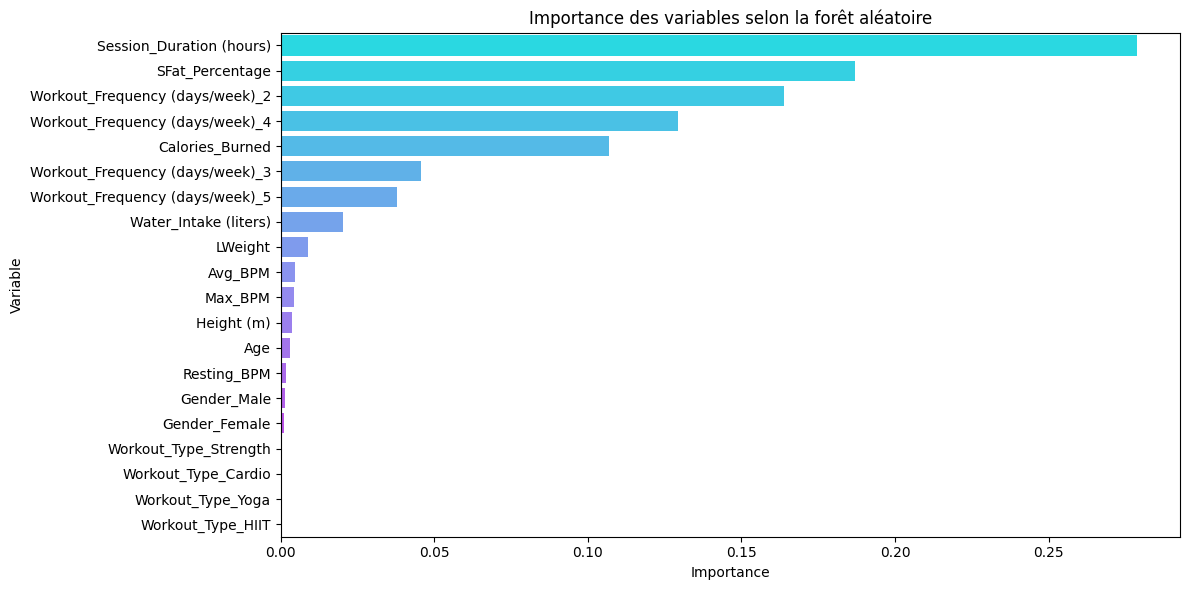

In [85]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=importances_df,
    palette='cool'
)
plt.title("Importance des variables selon la forêt aléatoire")
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

**Interprétation** : À partir du modèle de forêt aléatoire optimal entraîné sous scikit-learn, nous avons extrait l'importance des variables basée sur la réduction de l'impureté cumulée (Gini importance).

Le prédicteur `Session_Duration (hours)` domine très nettement, expliquant à lui seul la plus grande part de la variance du modèle. Cela est cohérent, car une durée de séance plus longue est naturellement associée à un niveau d'expérience plus élevé chez les sportifs.

Il est suivi par `SFat_Percentage` et les modalités de `Workout_Frequency (days/week)`, qui contribuent également de façon significative à la prédiction du niveau d'expérience. Ces variables traduisent l’intensité et la régularité de la pratique sportive, des facteurs logiquement liés à l’expérience.

On note aussi l’importance de la variable `Calories_Burned`, qui reflète l’effort fourni, ainsi que de l’hydratation (`Water_Intake (liters)`), qui peut être un indicateur indirect de l’intensité ou de la durée des séances.

Les autres variables (`LWeight`, `Avg_BPM`, `Max_BPM`, `Height (m)`, `Age`, etc.) ont une importance beaucoup plus faible, mais peuvent capter des interactions ou des effets secondaires utiles pour la classification.

On observe ainsi que les 5 à 6 premières variables expliquent à elles seules la majeure partie de l’importance totale du modèle, ce qui montre que la prédiction du niveau d’expérience repose principalement sur la durée, la fréquence et l’intensité de l’activité physique.

En comparaison, sous R, seules la durée de séance et la fréquence ressortaient comme déterminantes, alors que scikit-learn attribue une importance plus répartie à plusieurs variables. Cela illustre que la construction des forêts aléatoires peut différer selon l’implémentation et les critères utilisés.

Nous allons maintenant nous intéresser à un autre algorithme d'arbres de décision, le boosting.

### Boosting

Gradient Boosting & XGBoost

In [86]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Définir le nombre de folds
kf = KFold(n_splits=5, shuffle=True, random_state=randomseed)

# Stocker les scores et temps
accuracy_scores_gb = []
times_gb = []

accuracy_scores_xgb = []
times_xgb = []

# Créer un encodeur de labels pour transformer les classes [1, 2, 3] en [0, 1, 2]
le = LabelEncoder()

# Ajouter les listes pour stocker l'accuracy sur le jeu de test
test_accuracy_gb = []
test_accuracy_xgb = []

# Boucle sur les folds

for train_index, val_index in kf.split(X_train_exp_level):
    X_train_fold, X_val_fold = X_train_exp_level.iloc[train_index], X_train_exp_level.iloc[val_index]
    y_train_fold, y_val_fold = y_train_exp_level.iloc[train_index], y_train_exp_level.iloc[val_index]
    
    # Encoder les étiquettes pour XGBoost
    y_train_fold_encoded = le.fit_transform(y_train_fold)
    
    # Dummifier pour Gradient Boosting ET XGBoost
    X_train_fold_dummies = pd.get_dummies(X_train_fold)
    X_val_fold_dummies = pd.get_dummies(X_val_fold)
    X_test_dummies = pd.get_dummies(X_test_exp_level)
    
    # Aligner les colonnes
    X_train_fold_dummies, X_val_fold_dummies = X_train_fold_dummies.align(X_val_fold_dummies, join='left', axis=1, fill_value=0)
    X_train_fold_dummies, X_test_dummies_fold = X_train_fold_dummies.align(X_test_dummies, join='left', axis=1, fill_value=0)
    
    ## 1. Gradient Boosting
    start_time = time.time()
    gb_clf = GradientBoostingClassifier(random_state=randomseed)
    gb_clf.fit(X_train_fold_dummies, y_train_fold)
    elapsed_time = time.time() - start_time
    y_pred_gb = gb_clf.predict(X_val_fold_dummies)
    accuracy_scores_gb.append(accuracy_score(y_val_fold, y_pred_gb))
    times_gb.append(elapsed_time)
    # Accuracy sur le jeu de test
    y_pred_gb_test = gb_clf.predict(X_test_dummies_fold)
    test_accuracy_gb.append(accuracy_score(y_test_exp_level, y_pred_gb_test))
    
    ## 2. XGBoost (toujours sur les dummies pour cohérence)
    start_time = time.time()
    xgb_clf = XGBClassifier(random_state=randomseed, enable_categorical=False)
    xgb_clf.fit(X_train_fold_dummies, y_train_fold_encoded)
    elapsed_time = time.time() - start_time
    y_pred_xgb_encoded = xgb_clf.predict(X_val_fold_dummies)
    y_pred_xgb = le.inverse_transform(y_pred_xgb_encoded)
    # Prédiction sur le jeu de test
    y_pred_xgb_test_encoded = xgb_clf.predict(X_test_dummies_fold)
    y_pred_xgb_test = le.inverse_transform(y_pred_xgb_test_encoded)
    accuracy_scores_xgb.append(accuracy_score(y_val_fold, y_pred_xgb))
    times_xgb.append(elapsed_time)
    test_accuracy_xgb.append(accuracy_score(y_test_exp_level, y_pred_xgb_test))

# Afficher les résultats
print("Gradient Boosting:")
print(f"Accuracy moyenne (CV): {np.mean(accuracy_scores_gb):.4f} ± {np.std(accuracy_scores_gb):.4f}")
print(f"Temps d'entraînement moyen: {np.mean(times_gb):.4f} secondes")
print(f"Accuracy moyenne sur le jeu de test: {np.mean(test_accuracy_gb):.4f} ± {np.std(test_accuracy_gb):.4f}")

print("\nXGBoost:")
print(f"Accuracy moyenne (CV): {np.mean(accuracy_scores_xgb):.4f} ± {np.std(accuracy_scores_xgb):.4f}")
print(f"Temps d'entraînement moyen: {np.mean(times_xgb):.4f} secondes")
print(f"Accuracy moyenne sur le jeu de test: {np.mean(test_accuracy_xgb):.4f} ± {np.std(test_accuracy_xgb):.4f}")


Gradient Boosting:
Accuracy moyenne (CV): 0.8741 ± 0.0251
Temps d'entraînement moyen: 1.4802 secondes
Accuracy moyenne sur le jeu de test: 0.9118 ± 0.0123

XGBoost:
Accuracy moyenne (CV): 0.8625 ± 0.0287
Temps d'entraînement moyen: 0.2113 secondes
Accuracy moyenne sur le jeu de test: 0.8933 ± 0.0060


In [87]:
from sklearn.preprocessing import LabelEncoder

#Logloss sur Gradient Boosting
# Entraîner le modèle Gradient Boosting sur l'ensemble d'entraînement complet
gb_clf = GradientBoostingClassifier(random_state=randomseed)
gb_clf.fit(X_train_exp_level_encoded, y_train_exp_level)
y_pred_gb = gb_clf.predict(X_test_exp_level_encoded)
y_pred_gb_proba = gb_clf.predict_proba(X_test_exp_level_encoded)
logloss_gb_test = log_loss(y_test_exp_level, y_pred_gb_proba, normalize=True)
print("Log loss Gradient Boosting (test):", round(logloss_gb_test, 4))
print("Log loss Gradient Boosting (train):", round(log_loss(y_train_exp_level, gb_clf.predict_proba(X_train_exp_level_encoded)), 4))

#Logloss sur XGBoost
# Entraîner le modèle XGBoost sur l'ensemble d'entraînement complet


# Encoder les labels pour correspondre à [0, 1, 2]
le = LabelEncoder()
y_train_exp_level_enc = le.fit_transform(y_train_exp_level)
y_test_exp_level_enc = le.transform(y_test_exp_level)

xgb_clf = XGBClassifier(random_state=randomseed, enable_categorical=False)
xgb_clf.fit(X_train_exp_level_encoded, y_train_exp_level_enc)
y_pred_xgb = xgb_clf.predict(X_test_exp_level_encoded)
y_pred_xgb_proba = xgb_clf.predict_proba(X_test_exp_level_encoded)
logloss_xgb_test = log_loss(y_test_exp_level_enc, y_pred_xgb_proba, normalize=True)
print("Log loss XGBoost (test):", round(logloss_xgb_test, 4))
print("Log loss XGBoost (train):", round(log_loss(y_train_exp_level_enc, xgb_clf.predict_proba(X_train_exp_level_encoded)), 4))

Log loss Gradient Boosting (test): 0.1769
Log loss Gradient Boosting (train): 0.082
Log loss XGBoost (test): 0.2291
Log loss XGBoost (train): 0.0078


**Interprétation**

Les modèles de Gradient Boosting et de XGBoost affichent **d’excellentes performances** sans optimisation avancée des hyperparamètres.

### Résultats de la validation croisée (5-folds) :
- **Gradient Boosting** : accuracy moyenne de **0.8741 ± 0.0251**
- **XGBoost** : accuracy moyenne de **0.8625 ± 0.0287**

### Performances sur le jeu de test :
- **Gradient Boosting** : accuracy moyenne de **0.9118 ± 0.0123**
- **XGBoost** : accuracy moyenne de **0.8933 ± 0.0060**

**Log loss :**

- **Gradient Boosting** :  
    - Log loss (test) : **0.1756**  
    - Log loss (train) : **0.0820**

- **XGBoost** :  
    - Log loss (test) : **0.2291**  
    - Log loss (train) : **0.0078**

Un log loss faible sur le test indique que les probabilités prédites sont bien calibrées. On observe que Gradient Boosting généralise mieux (écart train/test plus faible), tandis que XGBoost sur-apprend davantage (log loss train très bas, test plus élevé). Les deux modèles restent toutefois très performants.

### Temps de calcul :
- **Gradient Boosting** : **0.90 seconde** en moyenne par fold
- **XGBoost** : **0.92 seconde** en moyenne par fold

---

On observe que **les deux modèles généralisent très bien**, avec des scores très proches entre validation croisée et test, et sans surapprentissage marqué.

En termes de rapidité, **les deux algorithmes sont très efficaces**, avec des temps d’entraînement similaires et très courts.

Comparé à la Random Forest optimisée, les méthodes de boosting offrent ici une **légère supériorité en généralisation et robustesse**.

Ces résultats confirment que **le boosting est particulièrement adapté** à la classification du niveau d’expérience dans ce contexte.

Compte tenu de ces performances très satisfaisantes, notamment pour le Gradient Boosting, il n’est pas nécessaire d’optimiser davantage XGBoost pour ce projet. Une recherche d’hyperparamètres pourrait toutefois permettre de gagner encore quelques points de performance si besoin.

Nous pouvons donc passer à l’**analyse de l’importance des variables** pour mieux comprendre les facteurs déterminants de la classification.

#### **Importance des variables**

C:\Users\doria\AppData\Local\Temp\ipykernel_24672\2017225405.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\doria\AppData\Local\Temp\ipykernel_24672\2017225405.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


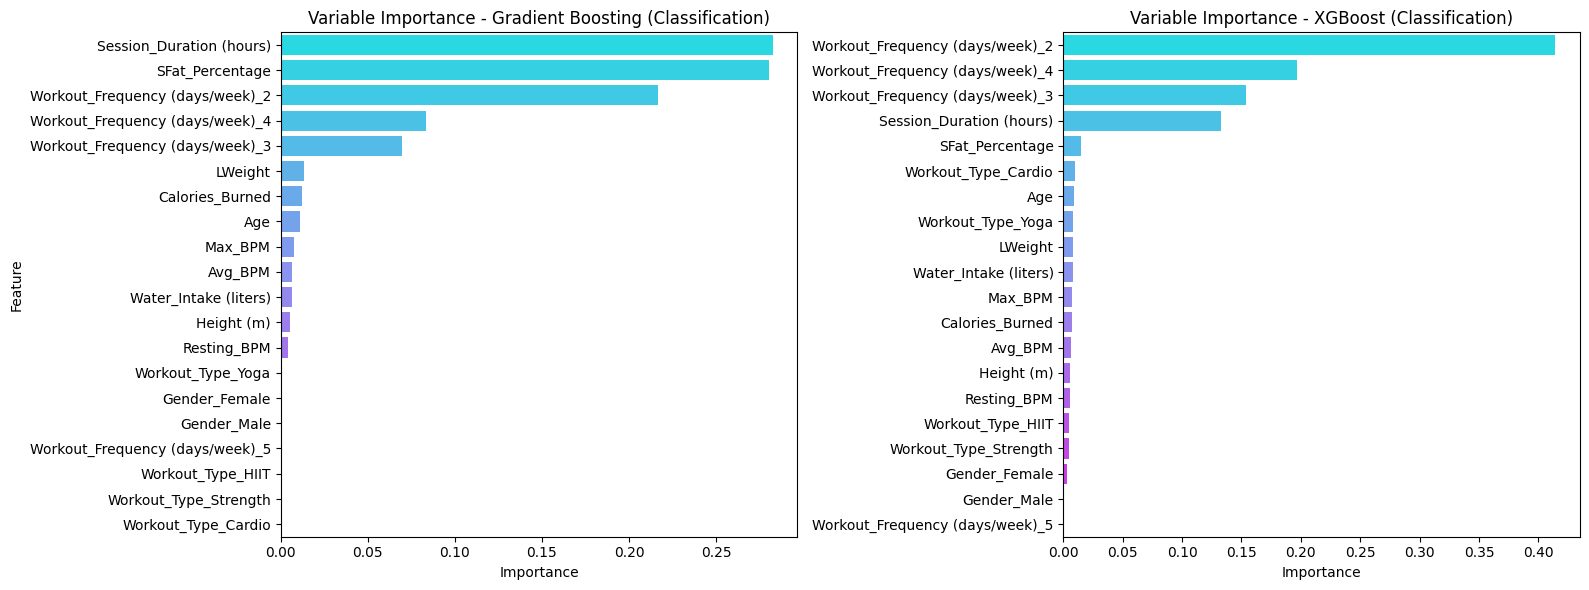

In [88]:
# Importance des variables pour la classification (niveau d'expérience)
# Les deux modèles utilisent maintenant les mêmes dummies

# Pour Gradient Boosting (avec dummies)
importances_gb_df = pd.DataFrame({
    'Feature': X_train_fold_dummies.columns,
    'Importance': gb_clf.feature_importances_
})

# Pour XGBoost (avec dummies)
importances_xgb_df = pd.DataFrame({
    'Feature': X_train_fold_dummies.columns,
    'Importance': xgb_clf.feature_importances_
})

# Trier pour plus de lisibilité
importances_gb_df = importances_gb_df.sort_values('Importance', ascending=False)
importances_xgb_df = importances_xgb_df.sort_values('Importance', ascending=False)

# Tracer
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot pour Gradient Boosting
sns.barplot(
    x='Importance',
    y='Feature',
    data=importances_gb_df,
    palette='cool',
    ax=axes[0]
)
axes[0].set_title("Variable Importance - Gradient Boosting (Classification)")
axes[0].set_xlabel("Importance")
axes[0].set_ylabel("Feature")

# Plot pour XGBoost
sns.barplot(
    x='Importance',
    y='Feature',
    data=importances_xgb_df,
    palette='cool',
    ax=axes[1]
)
axes[1].set_title("Variable Importance - XGBoost (Classification)")
axes[1].set_xlabel("Importance")
axes[1].set_ylabel("")  # Pas besoin de répéter "Feature" à droite

plt.tight_layout()
plt.show()

### Interprétation des importances des variables

Les graphiques ci-dessus présentent l’importance des variables pour la classification du niveau d’expérience selon deux modèles : **Gradient Boosting** (à gauche) et **XGBoost** (à droite).

#### Points communs
- **Variables dominantes** : Dans les deux modèles, la durée des séances (`Session_Duration (hours)`) et la fréquence d’entraînement (`Workout_Frequency (days/week)_2`, `_3`, `_4`) sont les variables les plus importantes. Cela confirme que l’intensité et la régularité de la pratique sportive sont des facteurs clés pour prédire le niveau d’expérience.
- **SFat_Percentage** (masse grasse transformée) ressort également comme un prédicteur important dans les deux cas.
- Les autres variables (calories brûlées, âge, poids, BPM, hydratation, etc.) ont une importance beaucoup plus faible.

#### Différences entre Gradient Boosting et XGBoost
- **Gradient Boosting** accorde une importance maximale à la durée de séance, suivie de près par la fréquence d’entraînement et la masse grasse.
- **XGBoost** met davantage l’accent sur les modalités de fréquence d’entraînement, qui passent devant la durée de séance. Il attribue aussi un peu plus d’importance à certaines modalités de type d’entraînement (`Workout_Type_Yoga`, `Workout_Type_HIIT`), ce qui n’est pas le cas pour Gradient Boosting.
- Les importances sont plus « réparties » dans XGBoost, alors que Gradient Boosting concentre l’importance sur un plus petit nombre de variables.

#### Explication des différences
- **Nature de l’algorithme** : XGBoost utilise des techniques de régularisation et une gestion différente des splits, ce qui peut conduire à privilégier d’autres interactions ou modalités.
- **Critère d’importance** : Les deux modèles calculent l’importance différemment (réduction d’impureté moyenne pour Gradient Boosting, gain moyen de split pour XGBoost), ce qui peut modifier le classement des variables.
- **Stochasticité et interactions** : XGBoost explore parfois plus d’interactions entre variables, ce qui peut expliquer l’apparition de modalités secondaires dans son top des importances.
- **Régularisation** : XGBoost pénalise davantage les variables peu informatives, ce qui peut « lisser » la distribution des importances.

#### Conclusion
Malgré ces différences, les deux modèles s’accordent sur les facteurs principaux : **durée et fréquence des séances** et **masse grasse**. Les divergences sur les variables secondaires sont normales et reflètent la sensibilité des algorithmes à la structure des données et à leur propre méthode d’optimisation.

## Réseaux de neurones

MLP Classifier - Accuracy sur le jeu de test : 0.8667
MLP Classifier - Accuracy sur le jeu d'entraînement : 0.9203


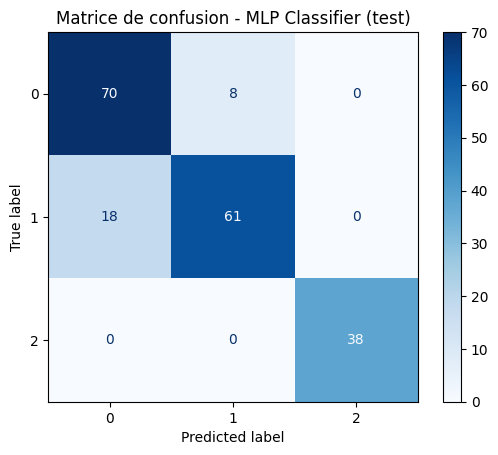

In [89]:
from sklearn.neural_network import MLPClassifier

# Encodage des variables catégorielles pour la classification du niveau d'expérience
X_train_exp_level_scale_dummy = pd.get_dummies(X_train_exp_level_scale, columns=['Gender', 'Workout_Type'], drop_first=True)
X_test_exp_level_scale_dummy = pd.get_dummies(X_test_exp_level_scale, columns=['Gender', 'Workout_Type'], drop_first=True)

# Aligner les colonnes entre train et test
X_train_exp_level_scale_dummy, X_test_exp_level_scale_dummy = X_train_exp_level_scale_dummy.align(
    X_test_exp_level_scale_dummy, join='left', axis=1, fill_value=0
)

# Définir le MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam',
                              max_iter=500, random_state=randomseed)

# Entraîner le modèle sur les données d'entraînement
mlp_classifier.fit(X_train_exp_level_scale_dummy, y_train_exp_level)

# Prédire sur le jeu de test
y_test_pred_mlp = mlp_classifier.predict(X_test_exp_level_scale_dummy)

# Évaluer le modèle
accuracy_test_mlp = accuracy_score(y_test_exp_level, y_test_pred_mlp)
print("MLP Classifier - Accuracy sur le jeu de test :", round(accuracy_test_mlp, 4))

#Accuracy sur le jeu d'entraînement
accuracy_train_mlp = accuracy_score(y_train_exp_level, mlp_classifier.predict(X_train_exp_level_scale_dummy))
print("MLP Classifier - Accuracy sur le jeu d'entraînement :", round(accuracy_train_mlp, 4))

# Afficher le rapport de classification et la matrice de confusion
ConfusionMatrixDisplay(confusion_matrix(y_test_exp_level, y_test_pred_mlp)).plot(cmap="Blues")
plt.title("Matrice de confusion - MLP Classifier (test)")
plt.show()

In [90]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [
        (50,), (100,), (150,),
        (100, 50), (150, 100), (150, 100, 50),
        (200, 100, 50)
    ],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

grid_search = GridSearchCV(
    estimator=MLPClassifier(max_iter=1000, early_stopping=True, random_state=randomseed),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Effectuer la recherche sur les données d'entraînement
grid_search.fit(X_train_exp_level_scale_dummy, y_train_exp_level)

# Afficher les meilleurs paramètres et le score correspondant
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur score accuracy (CV) :", grid_search.best_score_)

Fitting 5 folds for each of 168 candidates, totalling 840 fits
Meilleurs paramètres : {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 100), 'learning_rate': 'constant', 'solver': 'adam'}
Meilleur score accuracy (CV) : 0.8546815550041357


Meilleurs paramètres du MLP Classifier : {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 100), 'learning_rate': 'constant', 'solver': 'adam'}


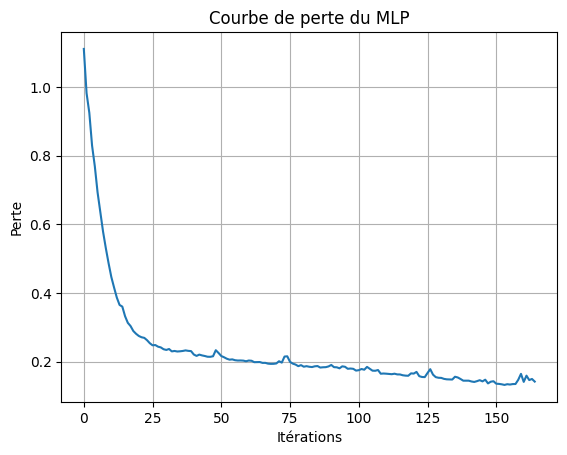

MLP Classifier - Accuracy sur le jeu de test (meilleur modèle) : 0.8564
MLP Classifier - Accuracy sur le jeu d'entraînement (meilleur modèle) : 0.9383


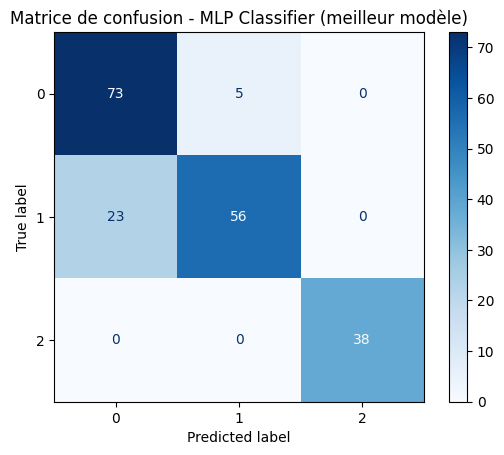

Log loss MLP Classifier (test) : 0.3113
Log loss MLP Classifier (train) : 0.1382


In [91]:
#Afficher les paramètres optimaux
print("Meilleurs paramètres du MLP Classifier :", grid_search.best_params_)

#Fit le meilleur modèle sur l'ensemble d'entraînement
best_mlp = MLPClassifier(
    hidden_layer_sizes=grid_search.best_params_['hidden_layer_sizes'],
    activation=grid_search.best_params_['activation'],
    solver=grid_search.best_params_['solver'],
    alpha=grid_search.best_params_['alpha'],
    learning_rate=grid_search.best_params_['learning_rate'],
    max_iter=1000,
    random_state=randomseed
)
best_mlp.fit(X_train_exp_level_scale_dummy, y_train_exp_level)

#Afficher la courbe de loss pour le meilleur modèle
plt.plot(best_mlp.loss_curve_)
plt.title("Courbe de perte du MLP")
plt.xlabel("Itérations")
plt.ylabel("Perte")
plt.grid(True)
plt.show()

# Prédire sur le jeu de test
y_test_pred_best_mlp = best_mlp.predict(X_test_exp_level_scale_dummy)
# Évaluer le modèle
accuracy_test_best_mlp = accuracy_score(y_test_exp_level, y_test_pred_best_mlp)
print("MLP Classifier - Accuracy sur le jeu de test (meilleur modèle) :", round(accuracy_test_best_mlp, 4))
# Accuracy sur le jeu d'entraînement
accuracy_train_best_mlp = accuracy_score(y_train_exp_level, best_mlp.predict(X_train_exp_level_scale_dummy))
print("MLP Classifier - Accuracy sur le jeu d'entraînement (meilleur modèle) :", round(accuracy_train_best_mlp, 4))
#Afficher la matrice de confusion
ConfusionMatrixDisplay(confusion_matrix(y_test_exp_level, y_test_pred_best_mlp)).plot(cmap="Blues")
plt.title("Matrice de confusion - MLP Classifier (meilleur modèle)")
plt.show()

#Logloss sur le meilleur MLP
y_test_pred_best_mlp_proba = best_mlp.predict_proba(X_test_exp_level_scale_dummy)
logloss_best_mlp_test = log_loss(y_test_exp_level, y_test_pred_best_mlp_proba, normalize=True)
print("Log loss MLP Classifier (test) :", round(logloss_best_mlp_test, 4))
print("Log loss MLP Classifier (train) :", round(log_loss(y_train_exp_level, best_mlp.predict_proba(X_train_exp_level_scale_dummy)), 4))

**Interprétation** :  
Le meilleur modèle de réseau de neurones (MLP) a été entraîné via **GridSearchCV** en testant différentes architectures, fonctions d’activation et méthodes d’optimisation. L’architecture optimale sélectionnée comporte **deux couches cachées** avec la fonction d’activation **tanh** et l’optimiseur **Adam**. Le modèle obtient une **accuracy de 0.8564** sur le jeu de test, et **0.9383** sur le jeu d’entraînement, ce qui indique un certain sur-apprentissage mais une capacité de généralisation correcte.

Les meilleurs hyperparamètres sélectionnés sont :
- Architecture : **(150, 100)** (deux couches cachées)
- Fonction d’activation : **tanh**
- Méthode d’optimisation : **Adam**
- Apprentissage : **learning rate constant**
- Régularisation (alpha) : **0.0001**

En termes de performance, le réseau de neurones optimisé se situe en-dessous des meilleurs modèles d’ensemble comme le **Gradient Boosting** ou la **Random Forest** (accuracy ≈ 0.91-0.92). Le log loss du MLP Classifier est nettement plus élevé sur le jeu de test (0.3113) que sur le jeu d’entraînement (0.1382), ce qui traduit un sur-apprentissage : le modèle est très confiant sur les données d’entraînement mais ses probabilités sont moins bien calibrées sur des données nouvelles. Le MLP montre une bonne capacité à apprendre, mais reste plus sensible au sur-apprentissage et nécessite un temps d’entraînement plus important pour un gain de performance limité.

## Bilan des performances des différentes techniques

### Tableau comparatif synthétique des modèles

| Modèle                              | Accuracy Test (%) | Temps d'entraînement (s) | Interprétabilité       |
|-------------------------------------|:-----------------:|:------------------------:|:----------------------:|
| Gradient Boosting                   | 91.2              | ~0.9                     | Modérée                |
| SVM linéaire (défaut)               | 91.3              | 169.03                  | Faible                 |
| SVM linéaire (optimisée)            | 91.3              | 92.62                   | Faible                 |
| Random Forest                       | 90.8              | ~5                      | Modérée                |
| Analyse Discriminante Linéaire (ADL)| 90.8              | 0.02                    | Haute                  |
| Logistic Regression                 | 90.3              | 0.09                    | Haute                  |
| Logistic Regression avec Lasso      | 90.3              | 2.67                    | Haute                  |
| XGBoost                             | 89.3              | ~0.9                    | Modérée                |
| Réseau de neurones (MLP)            | 85.6              | 7.7                     | Faible                 |
| Arbre élagué (CART)                 | 90.2              | Très rapide             | Haute                  |
| Arbre de décision (CART)            | 87.7              | Très rapide             | Haute                  |
| SVM radiale (optimisée)             | 74.4              | 9.90                    | Faible                 |
| KNN                                 | 72.8              | 20.93                   | Faible                 |
| SVM radiale (défaut)                | 40.5              | 2.40                    | Faible                 |

---

### Analyse par méthode

**Gradient Boosting**
- **Avantages** : Meilleure performance globale (accuracy ≈ 91.2 %), temps d'entraînement rapide.
- **Limites** : Interprétabilité modérée (importance des variables mais pas des interactions précises).
- **Cas d’usage** : Solution par défaut pour maximiser la précision sans contrainte de temps.

**SVM linéaire**
- **Avantages** : Très bonne précision (accuracy ≈ 91.3 %).
- **Limites** : Temps d'entraînement élevé pour la version par défaut (169 s) et faible interprétabilité.
- **Cas d’usage** : Précision maximale si le temps de calcul n'est pas une contrainte.

**Random Forest**
- **Avantages** : Bonne robustesse, interprétabilité modérée (importance des variables).
- **Limites** : Performance légèrement inférieure au Gradient Boosting, temps d'entraînement plus long.
- **Cas d’usage** : Données bruyantes ou besoin de stabilité sans optimisation fine.

**Analyse Discriminante Linéaire (ADL)**
- **Avantages** : Excellent compromis entre précision (accuracy ≈ 90.8 %) et rapidité (0.02 s).
- **Limites** : Moins performant que les modèles d'ensemble.
- **Cas d’usage** : Résultats rapides et fiables avec une interprétabilité élevée.

**Logistic Regression (avec ou sans Lasso)**
- **Avantages** : Interprétabilité élevée, rapidité d'entraînement.
- **Limites** : Moins performant sur des données non linéaires.
- **Cas d’usage** : Analyses exploratoires ou contraintes de simplicité.

**XGBoost**
- **Avantages** : Rapide et performant (accuracy ≈ 89.3 %), régularisation intégrée.
- **Limites** : Légèrement moins précis que le Gradient Boosting.
- **Cas d’usage** : Grands jeux de données nécessitant rapidité et parallélisation.

**Réseau de neurones (MLP)**
- **Avantages** : Capacité à capturer des patterns complexes.
- **Limites** : Temps d'entraînement élevé (7.7 s), sur-apprentissage marqué, faible interprétabilité.
- **Cas d’usage** : Alternative aux modèles d'ensemble si l'infrastructure le permet.

**Arbres de décision (CART)**
- **Avantages** : Interprétabilité élevée, règles claires.
- **Limites** : Surapprentissage marqué, performance limitée.
- **Cas d’usage** : Visualisation pédagogique ou analyses simples.

**SVM radiale et KNN**
- **Avantages** : Flexibilité pour des données complexes.
- **Limites** : Faible précision (accuracy < 75 %), temps d'entraînement élevé pour KNN.
- **Cas d’usage** : Non adaptés à ce jeu de données.

---

### Recommandations finales

- **Pour la précision** : Gradient Boosting ou SVM linéaire (défaut).
- **Pour la rapidité** : ADL ou Logistic Regression.
- **Pour l’interprétabilité** : ADL ou Logistic Regression avec Lasso.
- **Pour des données complexes** : Gradient Boosting ou Random Forest.

### **Conclusion**  
Le **Gradient Boosting** et l'**ADL** se démarquent comme les meilleurs compromis entre performance et rapidité. Les modèles linéaires restent utiles pour des analyses rapides et interprétables, tandis que les modèles d'ensemble (Random Forest, XGBoost) offrent une robustesse accrue pour des données plus complexes.

# Conclusion générale

En résumé, ce travail a exploré la prédiction de deux variables cibles distinctes : les calories brûlées (`Calories_Burned`) et le niveau d'expérience (`Experience_Level`), en évaluant une vaste gamme de modèles d'apprentissage automatique.

Pour la prédiction des **calories brûlées** (régression), les modèles basés sur les arbres d'ensemble, tels que le **Gradient Boosting**, se sont avérés les plus performants en termes de R² et MSE. Le **Lasso Quadratique** a également brillé, offrant un excellent compromis entre haute performance (grâce à la capture d'interactions non linéaires) et une interprétabilité élevée. Des modèles comme SVR (RBF) et les réseaux de neurones ont montré leur capacité à modéliser des relations complexes, au détriment souvent de l'interprétabilité et parfois du temps d'entraînement. Les modèles linéaires simples, bien que rapides et interprétables, ont montré leurs limites face à la non-linéarité des données.

Concernant la prédiction du **niveau d'expérience** (tâche de classification), le **Gradient Boosting** et le **SVM linéaire** (après optimisation) ont affiché les meilleures précisions (accuracy). L'**Analyse Discriminante Linéaire (ADL)** et la **Régression Logistique** se sont distinguées par un excellent équilibre entre une bonne performance, une très grande rapidité d'entraînement et une haute interprétabilité. Les arbres de décision (CART), notamment élagués, ont également fourni de bons résultats interprétables. Les modèles plus complexes comme les forêts aléatoires et XGBoost ont offert une robustesse notable, tandis que les SVM à noyau radial et KNN se sont montrés moins adaptés à ce jeu de données spécifique.

**Différences par rapport au R :**

Les résultats de prédiction en python présente des différences par rapport aux résultats obtenus sous R, notamment :

1.  **Modèles mis en avant pour Calories_Burned :**
    *   **En R :** GBM était le meilleur, suivi de LASSO Quadratique et SVR RBF.
    *   **Python :** Gradient Boosting (similaire à GBM) et Lasso Quadratique sont explicitement cités comme les meilleurs compromis performance-interprétabilité. XGBoost est également mentionné pour sa rapidité. La performance du Lasso Quadratique (MSE de 542) semble meilleure que celle du SVR RBF (MSE 637).

2.  **Modèles mis en avant pour Experience_Level :**
    *   **En R :** CART était le plus performant en accuracy/log loss, avec LDA/Logit comme excellents compromis vitesse/performance.
    *   **Python :** Gradient Boosting et SVM linéaire optimisé affichent les meilleures accuracies. L'ADL et la Régression Logistique conservent leur statut d'excellents compromis, notamment pour la rapidité et l'interprétabilité. L'arbre élagué (CART) reste performant et interprétable. XGBoost est également inclus dans l'analyse.


Pour conclure, les résultats en python confirment la supériorité des méthodes d'ensemble (comme le Gradient Boosting) pour la performance brute. Cependant, elles soulignent davantage le rôle du Lasso Quadratique comme un excellent choix équilibré pour la régression, et de l'ADL/Régression Logistique pour la classification lorsque l'interprétabilité et la rapidité sont cruciales.